## Setup

In [1]:
import numpy as np
from tensorflow.keras.optimizers import Adam
import tf_agents

In [2]:
from tf_agents.agents import DdpgAgent
from tf_agents.agents import ddpg

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.metrics import py_metrics
from tf_agents.drivers import py_driver,dynamic_episode_driver,dynamic_step_driver
from tf_agents.policies import random_py_policy,random_tf_policy,PyTFEagerPolicy
from tf_agents.replay_buffers import tf_uniform_replay_buffer,py_uniform_replay_buffer

In [3]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

## Hyperparameters

In [4]:
# from Maxime
nb_actions = 10
replay_buffer_capacity = 1000
log_interval=100
eval_interval=1000

# from DQN Tutorial
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration = 1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

## Environement

In [71]:
tuile = 1 # tuile choisie

reward = 0
ELEM1 = (1,4,3,'tomate')

if tuile==ELEM1[0]:
    reward += ELEM1[1]*2
    print(f'{ELEM1[3].capitalize()}: {ELEM1[2]}kg, {ELEM1[1]}€')
    print(f'Reward : {reward}')
else:
    print('Tuile inexistante')
    
'salut'

Tomate: 3kg, 4€
Reward : 8


'salut'

In [6]:
# Définir l'ensemble des quotas à produire

quota_tomates = 3
quota_carottes = 2
quota_broccolis = 0
ensemble_des_quotas = quota_tomates + quota_carottes + quota_broccolis

In [7]:
# Définir l'ensemble des tuiles name = [id, prix, rendement, quota]

ensemble_des_tuiles = dict()

ensemble_des_tuiles['tomate'] = [1,4,3,quota_tomates]
ensemble_des_tuiles['carotte'] = [2,2,5,quota_carottes]
ensemble_des_tuiles['broccoli'] = [3,6,2,quota_broccolis]

nb_ensemble_des_tuiles = len(ensemble_des_tuiles)
print(nb_ensemble_des_tuiles)
ensemble_des_tuiles

3


{'tomate': [1, 4, 3, 3], 'carotte': [2, 2, 5, 2], 'broccoli': [3, 6, 2, 0]}

In [8]:
# Définir l'ensemble des actions possibles

import itertools

nb_tuiles = nb_ensemble_des_tuiles
dim_x = 10
dim_y = 1
ensemble_des_possibles = dict()

compteur = -1
for x,y,t in itertools.product(range(dim_x),range(dim_y),range(1, nb_tuiles+1)):
    compteur += 1
    ensemble_des_possibles[compteur] = [x,y,t]
    
nb_ensemble_des_possibles = len(ensemble_des_possibles)
print(nb_ensemble_des_possibles)
ensemble_des_possibles

30


{0: [0, 0, 1],
 1: [0, 0, 2],
 2: [0, 0, 3],
 3: [1, 0, 1],
 4: [1, 0, 2],
 5: [1, 0, 3],
 6: [2, 0, 1],
 7: [2, 0, 2],
 8: [2, 0, 3],
 9: [3, 0, 1],
 10: [3, 0, 2],
 11: [3, 0, 3],
 12: [4, 0, 1],
 13: [4, 0, 2],
 14: [4, 0, 3],
 15: [5, 0, 1],
 16: [5, 0, 2],
 17: [5, 0, 3],
 18: [6, 0, 1],
 19: [6, 0, 2],
 20: [6, 0, 3],
 21: [7, 0, 1],
 22: [7, 0, 2],
 23: [7, 0, 3],
 24: [8, 0, 1],
 25: [8, 0, 2],
 26: [8, 0, 3],
 27: [9, 0, 1],
 28: [9, 0, 2],
 29: [9, 0, 3]}

In [9]:
ensemble_des_possibles.get(29)

[9, 0, 3]

In [53]:
class IArchitectEnv(py_environment.PyEnvironment):
    def __init__(self,verbose=False):
        # Initialisation environment
        self._state = np.zeros((dim_x,),dtype=np.int32)
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=nb_ensemble_des_possibles-1, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(self._state.shape[0],), dtype=np.int32, minimum=0, maximum=nb_tuiles, name='observation')
        self._episode_ended = False
        self.verbose = verbose
        
        # Initialisation rewards
        self.REWARD = 100
        self.PENALTY_ALREADY_FILLED = -100
        self.DEFAULT_REWARD = 1
        self.DEFAULT_REWARD_1 = 4
        self.DEFAULT_REWARD_2 = 2
        self.DEFAULT_REWARD_3 = 6
        
        # Initialisation quotas (inputs)
        self.QUOTA1 = 3
        self.QUOTA2 = 2
        self.QUOTA3 = 0

        
    def action_spec(self):
        return self._action_spec

    
    def observation_spec(self):
        return self._observation_spec

    
    def _reset(self):
        self._state = np.zeros((nb_actions,),dtype=np.int32)
        self._episode_ended = False
        return ts.restart(self._state)


    def _step(self, action):
        
        x, y, t = ensemble_des_possibles[int(action)]
        
        unique, counts = np.unique(self._state, return_counts=True)
        quota_restant = dict(zip(unique, counts))
        
        quota_1 = self.QUOTA1 - quota_restant.get(1,0)
        quota_2 = self.QUOTA2 - quota_restant.get(2,0)
        quota_3 = self.QUOTA3 - quota_restant.get(3,0)
        
        if self._episode_ended:
            return self.reset()

        if self.verbose:
            print(self._state,action,x,y,t, quota_restant)

        # Définition de la reward par défaut
        reward = self.DEFAULT_REWARD

        # Analyse des conditions de défaite
        if self._state[x] > 0: # Contrôler la défaite
            reward = self.PENALTY_ALREADY_FILLED
            self._episode_ended = True
        else: # Réaliser l'action
            self._state[x] = t # Définition de l'action
            
            # Définition de la reward
            if quota_1+quota_2+quota_3 <= 0:
                if t==1:
                    reward = self.DEFAULT_REWARD_1
                elif t==2:
                    reward = self.DEFAULT_REWARD_2
                elif t==3:
                    reward = self.DEFAULT_REWARD_3
                else:
                    reward = self.DEFAULT_REWARD
            else:
                if t==1 and quota_1 > 0:
                    reward = self.DEFAULT_REWARD_1 * 2
                elif t==2 and quota_2 > 0:
                    reward = self.DEFAULT_REWARD_2 * 2
                elif t==3 and quota_3 > 0:
                    reward = self.DEFAULT_REWARD_3 * 2
                else:
                    reward = 0
        
# Contrôler la victoire
        # Analyse des conditions de victoire
        if 0 not in self._state:
            self._episode_ended = True
            reward = self.REWARD
        
        if not self._episode_ended:
            result = ts.transition(self._state, reward=reward, discount=1.0)
        else:
            result = ts.termination(self._state, reward=reward)
        
        if self.verbose:
            print(result.observation,reward)
            
        return result


In [54]:
class MyObserver:
    def __init__(self,verbose=False):
        self.results = []
        self.verbose = verbose
    def __call__(self,traj):
        obs = traj.observation
        if isinstance(obs,Tensor):
            obs = obs.numpy().copy()
        else:
            obs = obs.copy()
        self.results.append({"observation":obs,"reward":traj.reward,"traj":traj})
        if self.verbose:
            print("\tMyObserver:",traj.observation,traj.reward)
    def plot(self):
        n = len(self.results)
        x = list(range(n))
        fig = plt.figure()
        plt.plot([t.get("reward") for t in self.results])
#         plt.bar(x=x,height=[int(t.get("traj").is_last())*8 for t in results],color="g")
#         plt.bar(x=x,height=[int(t.get("traj").is_boundary())*8 for t in results],color="r")
#         plt.bar(x=x,height=[int(t.get("traj").is_first())*8 for t in results],color="k")
        return fig

In [55]:
a = np.array([0, 3, 0, 1, 0, 1, 2, 1, 0, 0, 0, 0, 1, 3, 4])
unique, counts = np.unique(a, return_counts=True)
bitch = dict(zip(unique, counts))
bitch.get('1')

In [56]:
# Initialiser les environnement
environment = IArchitectEnv(verbose=True)
train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(environment)

utils.validate_py_environment(environment, episodes=5)





[0 0 0 0 0 0 0 0 0 0] 23 7 0 3 {0: 10}
[0 0 0 0 0 0 0 3 0 0] 0
[0 0 0 0 0 0 0 3 0 0] 3 1 0 1 {0: 9, 3: 1}
[0 1 0 0 0 0 0 3 0 0] 8
[0 1 0 0 0 0 0 3 0 0] 13 4 0 2 {0: 8, 1: 1, 3: 1}
[0 1 0 0 2 0 0 3 0 0] 4
[0 1 0 0 2 0 0 3 0 0] 16 5 0 2 {0: 7, 1: 1, 2: 1, 3: 1}
[0 1 0 0 2 2 0 3 0 0] 4
[0 1 0 0 2 2 0 3 0 0] 13 4 0 2 {0: 6, 1: 1, 2: 2, 3: 1}
[0 1 0 0 2 2 0 3 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 25 8 0 2 {0: 10}
[0 0 0 0 0 0 0 0 2 0] 4
[0 0 0 0 0 0 0 0 2 0] 0 0 0 1 {0: 9, 2: 1}
[1 0 0 0 0 0 0 0 2 0] 8
[1 0 0 0 0 0 0 0 2 0] 1 0 0 2 {0: 8, 1: 1, 2: 1}
[1 0 0 0 0 0 0 0 2 0] -100
[0 0 0 0 0 0 0 0 0 0] 14 4 0 3 {0: 10}
[0 0 0 0 3 0 0 0 0 0] 0
[0 0 0 0 3 0 0 0 0 0] 16 5 0 2 {0: 9, 3: 1}
[0 0 0 0 3 2 0 0 0 0] 4
[0 0 0 0 3 2 0 0 0 0] 6 2 0 1 {0: 8, 2: 1, 3: 1}
[0 0 1 0 3 2 0 0 0 0] 8
[0 0 1 0 3 2 0 0 0 0] 0 0 0 1 {0: 7, 1: 1, 2: 1, 3: 1}
[1 0 1 0 3 2 0 0 0 0] 8
[1 0 1 0 3 2 0 0 0 0] 26 8 0 3 {0: 6, 1: 2, 2: 1, 3: 1}
[1 0 1 0 3 2 0 0 3 0] 0
[1 0 1 0 3 2 0 0 3 0] 2 0 0 3 {0: 5, 1: 2, 2: 1, 3: 2}
[1 0 1 0 

## Agent

In [57]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(environment.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
      return tf.keras.layers.Dense(
          num_units,
          activation=tf.keras.activations.relu,
          kernel_initializer=tf.keras.initializers.VarianceScaling(
              scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [58]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [59]:
q_net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  1100      
_________________________________________________________________
dense_4 (Dense)              multiple                  5050      
_________________________________________________________________
dense_5 (Dense)              multiple                  1530      
Total params: 7,680
Trainable params: 7,680
Non-trainable params: 0
_________________________________________________________________


## Policies

In [60]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [61]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

## Metrics

In [62]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [63]:
avg_return = compute_avg_return(eval_env, random_policy, num_eval_episodes)
returns = [avg_return]

[0 0 0 0 0 0 0 0 0 0] 22 7 0 2 {0: 10}
[0 0 0 0 0 0 0 2 0 0] 4
[0 0 0 0 0 0 0 2 0 0] 29 9 0 3 {0: 9, 2: 1}
[0 0 0 0 0 0 0 2 0 3] 0
[0 0 0 0 0 0 0 2 0 3] 3 1 0 1 {0: 8, 2: 1, 3: 1}
[0 1 0 0 0 0 0 2 0 3] 8
[0 1 0 0 0 0 0 2 0 3] 0 0 0 1 {0: 7, 1: 1, 2: 1, 3: 1}
[1 1 0 0 0 0 0 2 0 3] 8
[1 1 0 0 0 0 0 2 0 3] 1 0 0 2 {0: 6, 1: 2, 2: 1, 3: 1}
[1 1 0 0 0 0 0 2 0 3] -100
[0 0 0 0 0 0 0 0 0 0] 7 2 0 2 {0: 10}
[0 0 2 0 0 0 0 0 0 0] 4
[0 0 2 0 0 0 0 0 0 0] 25 8 0 2 {0: 9, 2: 1}
[0 0 2 0 0 0 0 0 2 0] 4
[0 0 2 0 0 0 0 0 2 0] 23 7 0 3 {0: 8, 2: 2}
[0 0 2 0 0 0 0 3 2 0] 0
[0 0 2 0 0 0 0 3 2 0] 4 1 0 2 {0: 7, 2: 2, 3: 1}
[0 2 2 0 0 0 0 3 2 0] 0
[0 2 2 0 0 0 0 3 2 0] 14 4 0 3 {0: 6, 2: 3, 3: 1}
[0 2 2 0 3 0 0 3 2 0] 0
[0 2 2 0 3 0 0 3 2 0] 23 7 0 3 {0: 5, 2: 3, 3: 2}
[0 2 2 0 3 0 0 3 2 0] -100
[0 0 0 0 0 0 0 0 0 0] 12 4 0 1 {0: 10}
[0 0 0 0 1 0 0 0 0 0] 8
[0 0 0 0 1 0 0 0 0 0] 28 9 0 2 {0: 9, 1: 1}
[0 0 0 0 1 0 0 0 0 2] 4
[0 0 0 0 1 0 0 0 0 2] 24 8 0 1 {0: 8, 1: 1, 2: 1}
[0 0 0 0 1 0 0 0 1 2] 8
[0 0 0 0

## Replay Buffer

In [64]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
                                data_spec=agent.collect_data_spec,                                                     
                                batch_size=train_env.batch_size,                                                             
                                max_length=100000)

def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, 
                                      action_step, 
                                      next_time_step)
# Add trajectory to the replay buffer
    buffer.add_batch(traj)

In [65]:
train_env.batch_size

1

In [66]:
collect_steps_per_iteration = 1
batch_size = 64
dataset = replay_buffer.as_dataset(num_parallel_calls=3, 
                                   sample_batch_size=batch_size, 
                                   num_steps=2).prefetch(3)
iterator = iter(dataset)

In [67]:
result_loss = []
num_iterations = 20000
train_env.reset()
for _ in range(batch_size):
    collect_step(train_env, agent.policy, replay_buffer)
for _ in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)
    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss
    step = agent.train_step_counter.numpy()
    # Print loss every 200 steps.
    if step % 200 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
        result_loss.append(train_loss)
    # Evaluate agent's performance every 1000 steps.
    if step % 1000 == 0:
        avg_return = compute_avg_return(train_env, agent.policy, 5)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 9, 1: 1}
[1 2 0 0 0 0 0 0 0 0] 4
[1 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 2: 1}
[1 2 0 0 0 0 3 0 0 0] 0
[1 2 0 0 0 0 3 0 0 0] 28 9 0 2 {0: 7, 1: 1, 2: 1, 3: 1}
[1 2 0 0 0 0 3 0 0 2] 4
[1 2 0 0 0 0 3 0 0 2] 20 6 0 3 {0: 6, 1: 1, 2: 2, 3: 1}
[1 2 0 0 0 0 3 0 0 2] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 9, 1: 1}
[1 2 0 0 0 0 0 0 0 0] 4
[1 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 2: 1}
[1 2 0 0 0 0 3 0 0 0] 0
[1 2 0 0 0 0 3 0 0 0] 28 9 0 2 {0: 7, 1: 1, 2: 1, 3: 1}
[1 2 0 0 0 0 3 0 0 2] 4
[1 2 0 0 0 0 3 0 0 2] 20 6 0 3 {0: 6, 1: 1, 2: 2, 3: 1}
[1 2 0 0 0 0 3 0 0 2] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 9, 1: 1}
[1 2 0 0 0 0 0 0 0 0] 4
[1 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 2: 1}
[1 2 0 0 0 0 3 0 0 0] 0
[1 2 0 0 0 0 3 0 0 0] 28 9 0 2 {0: 7, 1: 1, 2: 1, 3: 1}
[1 2 0 0 

[0 0 0 0 0 0 0 0 0 3] 29 9 0 3 {0: 9, 3: 1}
[0 0 0 0 0 0 0 0 0 3] -100
[0 0 0 0 0 0 0 0 0 0] 29 9 0 3 {0: 10}
[0 0 0 0 0 0 0 0 0 3] 0
[0 0 0 0 0 0 0 0 0 3] 0 0 0 1 {0: 9, 3: 1}
[1 0 0 0 0 0 0 0 0 3] 8
[1 0 0 0 0 0 0 0 0 3] 29 9 0 3 {0: 8, 1: 1, 3: 1}
[1 0 0 0 0 0 0 0 0 3] -100
[0 0 0 0 0 0 0 0 0 0] 29 9 0 3 {0: 10}
[0 0 0 0 0 0 0 0 0 3] 0
[0 0 0 0 0 0 0 0 0 3] 29 9 0 3 {0: 9, 3: 1}
[0 0 0 0 0 0 0 0 0 3] -100
[0 0 0 0 0 0 0 0 0 0] 29 9 0 3 {0: 10}
[0 0 0 0 0 0 0 0 0 3] 0
[0 0 0 0 0 0 0 0 0 3] 29 9 0 3 {0: 9, 3: 1}
[0 0 0 0 0 0 0 0 0 3] -100
[0 0 0 0 0 0 0 0 0 0] 29 9 0 3 {0: 10}
[0 0 0 0 0 0 0 0 0 3] 0
[0 0 0 0 0 0 0 0 0 3] 5 1 0 3 {0: 9, 3: 1}
[0 3 0 0 0 0 0 0 0 3] 0
[0 3 0 0 0 0 0 0 0 3] 29 9 0 3 {0: 8, 3: 2}
[0 3 0 0 0 0 0 0 0 3] -100
[0 0 0 0 0 0 0 0 0 0] 29 9 0 3 {0: 10}
[0 0 0 0 0 0 0 0 0 3] 0
[0 0 0 0 0 0 0 0 0 3] 29 9 0 3 {0: 9, 3: 1}
[0 0 0 0 0 0 0 0 0 3] -100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 29 9 0 3 {0: 9, 2: 1}
[0 2 0 0 0 0 

[0 0 0 3 0 0 0 0 0 2] 11 3 0 3 {0: 8, 2: 1, 3: 1}
[0 0 0 3 0 0 0 0 0 2] -100
[0 0 0 0 0 0 0 0 0 0] 28 9 0 2 {0: 10}
[0 0 0 0 0 0 0 0 0 2] 4
[0 0 0 0 0 0 0 0 0 2] 11 3 0 3 {0: 9, 2: 1}
[0 0 0 3 0 0 0 0 0 2] 0
[0 0 0 3 0 0 0 0 0 2] 11 3 0 3 {0: 8, 2: 1, 3: 1}
[0 0 0 3 0 0 0 0 0 2] -100
[0 0 0 0 0 0 0 0 0 0] 28 9 0 2 {0: 10}
[0 0 0 0 0 0 0 0 0 2] 4
[0 0 0 0 0 0 0 0 0 2] 11 3 0 3 {0: 9, 2: 1}
[0 0 0 3 0 0 0 0 0 2] 0
[0 0 0 3 0 0 0 0 0 2] 11 3 0 3 {0: 8, 2: 1, 3: 1}
[0 0 0 3 0 0 0 0 0 2] -100
[0 0 0 0 0 0 0 0 0 0] 28 9 0 2 {0: 10}
[0 0 0 0 0 0 0 0 0 2] 4
[0 0 0 0 0 0 0 0 0 2] 11 3 0 3 {0: 9, 2: 1}
[0 0 0 3 0 0 0 0 0 2] 0
[0 0 0 3 0 0 0 0 0 2] 11 3 0 3 {0: 8, 2: 1, 3: 1}
[0 0 0 3 0 0 0 0 0 2] -100
[0 0 0 0 0 0 0 0 0 0] 28 9 0 2 {0: 10}
[0 0 0 0 0 0 0 0 0 2] 4
[0 0 0 0 0 0 0 0 0 2] 6 2 0 1 {0: 9, 2: 1}
[0 0 1 0 0 0 0 0 0 2] 8
[0 0 1 0 0 0 0 0 0 2] 6 2 0 1 {0: 8, 1: 1, 2: 1}
[0 0 1 0 0 0 0 0 0 2] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 28 9 0 2

[0 2 0 0 0 0 0 0 0 0] 25 8 0 2 {0: 9, 2: 1}
[0 2 0 0 0 0 0 0 2 0] 4
[0 2 0 0 0 0 0 0 2 0] 25 8 0 2 {0: 8, 2: 2}
[0 2 0 0 0 0 0 0 2 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 25 8 0 2 {0: 9, 2: 1}
[0 2 0 0 0 0 0 0 2 0] 4
[0 2 0 0 0 0 0 0 2 0] 25 8 0 2 {0: 8, 2: 2}
[0 2 0 0 0 0 0 0 2 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 2: 1}
[0 2 0 0 0 0 3 0 0 0] 0
[0 2 0 0 0 0 3 0 0 0] 28 9 0 2 {0: 8, 2: 1, 3: 1}
[0 2 0 0 0 0 3 0 0 2] 4
[0 2 0 0 0 0 3 0 0 2] 25 8 0 2 {0: 7, 2: 2, 3: 1}
[0 2 0 0 0 0 3 0 2 2] 0
[0 2 0 0 0 0 3 0 2 2] 25 8 0 2 {0: 6, 2: 3, 3: 1}
[0 2 0 0 0 0 3 0 2 2] -100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 2: 1}
[0 2 0 0 0 0 3 0 0 0] 0
[0 2 0 0 0 0 3 0 0 0] 13 4 0 2 {0: 8, 2: 1, 3: 1}
[0 2 0 0 2 0 3 0 0 0] 4
[0 2 0 0 2 0 3 0 0 0] 28 9 0 2 {0: 7, 2: 2, 3: 1}
[0 2 0 0 2 0 3 0 0 2] 0
[0 2 0 0 2 0 3 0 0 2] 14 4 

[0 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 10}
[0 0 0 0 0 0 3 0 0 0] 0
[0 0 0 0 0 0 3 0 0 0] 0 0 0 1 {0: 9, 3: 1}
[1 0 0 0 0 0 3 0 0 0] 8
[1 0 0 0 0 0 3 0 0 0] 0 0 0 1 {0: 8, 1: 1, 3: 1}
[1 0 0 0 0 0 3 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 9, 1: 1}
[1 2 0 0 0 0 0 0 0 0] 4
[1 2 0 0 0 0 0 0 0 0] 26 8 0 3 {0: 8, 1: 1, 2: 1}
[1 2 0 0 0 0 0 0 3 0] 0
[1 2 0 0 0 0 0 0 3 0] 1 0 0 2 {0: 7, 1: 1, 2: 1, 3: 1}
[1 2 0 0 0 0 0 0 3 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 9, 1: 1}
[1 2 0 0 0 0 0 0 0 0] 4
[1 2 0 0 0 0 0 0 0 0] 1 0 0 2 {0: 8, 1: 1, 2: 1}
[1 2 0 0 0 0 0 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 10}
[0 0 0 0 0 0 3 0 0 0] 0
[0 0 0 0 0 0 3 0 0 0] 0 0 0 1 {0: 9, 3: 1}
[1 0 0 0 0 0 3 0 0 0] 8
[1 0 0 0 0 0 3 0 0 0] 0 0 0 1 {0: 8, 1: 1, 3: 1}
[1 0 0 0 0 0 3 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 9,

[1 0 1 0 0 0 3 0 2 0] 12 4 0 1 {0: 6, 1: 2, 2: 1, 3: 1}
[1 0 1 0 1 0 3 0 2 0] 8
[1 0 1 0 1 0 3 0 2 0] 20 6 0 3 {0: 5, 1: 3, 2: 1, 3: 1}
[1 0 1 0 1 0 3 0 2 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 1: 1}
[1 0 0 0 0 0 3 0 0 0] 0
[1 0 0 0 0 0 3 0 0 0] 25 8 0 2 {0: 8, 1: 1, 3: 1}
[1 0 0 0 0 0 3 0 2 0] 4
[1 0 0 0 0 0 3 0 2 0] 17 5 0 3 {0: 7, 1: 1, 2: 1, 3: 1}
[1 0 0 0 0 3 3 0 2 0] 0
[1 0 0 0 0 3 3 0 2 0] 26 8 0 3 {0: 6, 1: 1, 2: 1, 3: 2}
[1 0 0 0 0 3 3 0 2 0] -100
[0 0 0 0 0 0 0 0 0 0] 17 5 0 3 {0: 10}
[0 0 0 0 0 3 0 0 0 0] 0
[0 0 0 0 0 3 0 0 0 0] 20 6 0 3 {0: 9, 3: 1}
[0 0 0 0 0 3 3 0 0 0] 0
[0 0 0 0 0 3 3 0 0 0] 20 6 0 3 {0: 8, 3: 2}
[0 0 0 0 0 3 3 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 23 7 0 3 {0: 9, 1: 1}
[1 0 0 0 0 0 0 3 0 0] 0
[1 0 0 0 0 0 0 3 0 0] 17 5 0 3 {0: 8, 1: 1, 3: 1}
[1 0 0 0 0 3 0 3 0 0] 0
[1 0 0 0 0 3 0 3 0 0] 20 6 0 3 {0: 7, 1: 1, 3: 2}
[1 0 0 0 0 3 3

[0 1 0 0 0 0 0 1 0 0] 21 7 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 16 5 0 2 {0: 10}
[0 0 0 0 0 2 0 0 0 0] 4
[0 0 0 0 0 2 0 0 0 0] 22 7 0 2 {0: 9, 2: 1}
[0 0 0 0 0 2 0 2 0 0] 4
[0 0 0 0 0 2 0 2 0 0] 12 4 0 1 {0: 8, 2: 2}
[0 0 0 0 1 2 0 2 0 0] 8
[0 0 0 0 1 2 0 2 0 0] 12 4 0 1 {0: 7, 1: 1, 2: 2}
[0 0 0 0 1 2 0 2 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 16 5 0 2 {0: 10}
[0 0 0 0 0 2 0 0 0 0] 4
[0 0 0 0 0 2 0 0 0 0] 22 7 0 2 {0: 9, 2: 1}
[0 0 0 0 0 2 0 2 0 0] 4
[0 0 0 0 0 2 0 2 0 0] 17 5 0 3 {0: 8, 2: 2}
[0 0 0 0 0 2 0 2 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 10}
[0 3 0 0 0 0 0 0 0 0] 0
[0 3 0 0 0 0 0 0 0 0] 21 7 0 1 {0: 9, 3: 1}
[0 3 0 0 0 0 0 1 0 0] 8
[0 3 0 0 0 0 0 1 0 0] 21 7 0 1 {0: 8, 1: 1, 3: 1}
[0 3 0 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 10}
[3 0 0 0 0 0 0 0 0 0] 0
[3 0 0 0 0 0 0 0 0 0] 21 7 0 1 {0: 9, 3: 1}
[3 0 0 0 0 0 0 1 0 0] 8
[3 0 0 0 0 0 0 1 0 0] 21 7 0 1 {0: 8, 1: 1, 3: 1}
[3 0 0 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 21 7 0 1 {0: 10

[1 2 0 1 0 0 1 0 0 0] 6 2 0 1 {0: 6, 1: 3, 2: 1}
[1 2 1 1 0 0 1 0 0 0] 0
[1 2 1 1 0 0 1 0 0 0] 6 2 0 1 {0: 5, 1: 4, 2: 1}
[1 2 1 1 0 0 1 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 10}
[0 0 0 0 0 0 3 0 0 0] 0
[0 0 0 0 0 0 3 0 0 0] 4 1 0 2 {0: 9, 3: 1}
[0 2 0 0 0 0 3 0 0 0] 4
[0 2 0 0 0 0 3 0 0 0] 28 9 0 2 {0: 8, 2: 1, 3: 1}
[0 2 0 0 0 0 3 0 0 2] 4
[0 2 0 0 0 0 3 0 0 2] 16 5 0 2 {0: 7, 2: 2, 3: 1}
[0 2 0 0 0 2 3 0 0 2] 0
[0 2 0 0 0 2 3 0 0 2] 20 6 0 3 {0: 6, 2: 3, 3: 1}
[0 2 0 0 0 2 3 0 0 2] -100
[0 0 0 0 0 0 0 0 0 0] 21 7 0 1 {0: 10}
[0 0 0 0 0 0 0 1 0 0] 8
[0 0 0 0 0 0 0 1 0 0] 18 6 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 1 1 0 0] 8
[0 0 0 0 0 0 1 1 0 0] 4 1 0 2 {0: 8, 1: 2}
[0 2 0 0 0 0 1 1 0 0] 4
[0 2 0 0 0 0 1 1 0 0] 6 2 0 1 {0: 7, 1: 2, 2: 1}
[0 2 1 0 0 0 1 1 0 0] 8
[0 2 1 0 0 0 1 1 0 0] 6 2 0 1 {0: 6, 1: 3, 2: 1}
[0 2 1 0 0 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 21 7 0 1 {0: 10}
[0 0 0 0 0 0 0 1 0 0] 8
[0 0 0 0 0 0 0 1 0 0] 0 0 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 0 1 0 0] 8
[1 0 0 0 0 0 0 1 0 

[1 2 0 0 0 2 1 0 0 2] 21 7 0 1 {0: 5, 1: 2, 2: 3}
[1 2 0 0 0 2 1 1 0 2] 4
[1 2 0 0 0 2 1 1 0 2] 21 7 0 1 {0: 4, 1: 3, 2: 3}
[1 2 0 0 0 2 1 1 0 2] -100
[0 0 0 0 0 0 0 0 0 0] 21 7 0 1 {0: 10}
[0 0 0 0 0 0 0 1 0 0] 8
[0 0 0 0 0 0 0 1 0 0] 0 0 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 0 1 0 0] 8
[1 0 0 0 0 0 0 1 0 0] 4 1 0 2 {0: 8, 1: 2}
[1 2 0 0 0 0 0 1 0 0] 4
[1 2 0 0 0 0 0 1 0 0] 18 6 0 1 {0: 7, 1: 2, 2: 1}
[1 2 0 0 0 0 1 1 0 0] 8
[1 2 0 0 0 0 1 1 0 0] 6 2 0 1 {0: 6, 1: 3, 2: 1}
[1 2 1 0 0 0 1 1 0 0] 0
[1 2 1 0 0 0 1 1 0 0] 9 3 0 1 {0: 5, 1: 4, 2: 1}
[1 2 1 1 0 0 1 1 0 0] 4
[1 2 1 1 0 0 1 1 0 0] 9 3 0 1 {0: 4, 1: 5, 2: 1}
[1 2 1 1 0 0 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 12 4 0 1 {0: 9, 1: 1}
[1 0 0 0 1 0 0 0 0 0] 8
[1 0 0 0 1 0 0 0 0 0] 4 1 0 2 {0: 8, 1: 2}
[1 2 0 0 1 0 0 0 0 0] 4
[1 2 0 0 1 0 0 0 0 0] 18 6 0 1 {0: 7, 1: 2, 2: 1}
[1 2 0 0 1 0 1 0 0 0] 8
[1 2 0 0 1 0 1 0 0 0] 6 2 0 1 {0: 6, 1: 3, 2: 1}
[1 2 1 0 1 0 1 0 0 0] 0
[1 2 1 0 1 0

[1 2 0 0 1 2 1 0 0 2] 0 0 0 1 {0: 4, 1: 3, 2: 3}
[1 2 0 0 1 2 1 0 0 2] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 1 0 0 0] 8
[1 0 0 0 0 0 1 0 0 0] 28 9 0 2 {0: 8, 1: 2}
[1 0 0 0 0 0 1 0 0 2] 4
[1 0 0 0 0 0 1 0 0 2] 4 1 0 2 {0: 7, 1: 2, 2: 1}
[1 2 0 0 0 0 1 0 0 2] 4
[1 2 0 0 0 0 1 0 0 2] 16 5 0 2 {0: 6, 1: 2, 2: 2}
[1 2 0 0 0 2 1 0 0 2] 0
[1 2 0 0 0 2 1 0 0 2] 12 4 0 1 {0: 5, 1: 2, 2: 3}
[1 2 0 0 1 2 1 0 0 2] 4
[1 2 0 0 1 2 1 0 0 2] 12 4 0 1 {0: 4, 1: 3, 2: 3}
[1 2 0 0 1 2 1 0 0 2] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 1 0 1 0] 8
[0 0 0 0 0 0 1 0 1 0] 4 1 0 2 {0: 8, 1: 2}
[0 2 0 0 0 0 1 0 1 0] 4
[0 2 0 0 0 0 1 0 1 0] 12 4 0 1 {0: 7, 1: 2, 2: 1}
[0 2 0 0 1 0 1 0 1 0] 8
[0 2 0 0 1 0 1 0 1 0] 12 4 0 1 {0: 6, 1: 3, 2: 1}
[0 2 0 0 1 0 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0

[1 2 0 0 1 2 1 2 1 0] 17 5 0 3 {0: 3, 1: 4, 2: 3}
[1 2 0 0 1 2 1 2 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 1 0 1 0] 8
[0 0 0 0 0 0 1 0 1 0] 0 0 0 1 {0: 8, 1: 2}
[1 0 0 0 0 0 1 0 1 0] 8
[1 0 0 0 0 0 1 0 1 0] 12 4 0 1 {0: 7, 1: 3}
[1 0 0 0 1 0 1 0 1 0] 0
[1 0 0 0 1 0 1 0 1 0] 4 1 0 2 {0: 6, 1: 4}
[1 2 0 0 1 0 1 0 1 0] 4
[1 2 0 0 1 0 1 0 1 0] 9 3 0 1 {0: 5, 1: 4, 2: 1}
[1 2 0 1 1 0 1 0 1 0] 4
[1 2 0 1 1 0 1 0 1 0] 9 3 0 1 {0: 4, 1: 5, 2: 1}
[1 2 0 1 1 0 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 1 0 1 0] 8
[0 0 0 0 0 0 1 0 1 0] 0 0 0 1 {0: 8, 1: 2}
[1 0 0 0 0 0 1 0 1 0] 8
[1 0 0 0 0 0 1 0 1 0] 9 3 0 1 {0: 7, 1: 3}
[1 0 0 1 0 0 1 0 1 0] 0
[1 0 0 1 0 0 1 0 1 0] 9 3 0 1 {0: 6, 1: 4}
[1 0 0 1 0 0 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 9, 1: 1}

[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 1 0 1 0] 8
[0 0 0 0 0 0 1 0 1 0] 12 4 0 1 {0: 8, 1: 2}
[0 0 0 0 1 0 1 0 1 0] 8
[0 0 0 0 1 0 1 0 1 0] 0 0 0 1 {0: 7, 1: 3}
[1 0 0 0 1 0 1 0 1 0] 0
[1 0 0 0 1 0 1 0 1 0] 4 1 0 2 {0: 6, 1: 4}
[1 2 0 0 1 0 1 0 1 0] 4
[1 2 0 0 1 0 1 0 1 0] 6 2 0 1 {0: 5, 1: 4, 2: 1}
[1 2 1 0 1 0 1 0 1 0] 4
[1 2 1 0 1 0 1 0 1 0] 2 0 0 3 {0: 4, 1: 5, 2: 1}
[1 2 1 0 1 0 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 1 0 1 0] 8
[0 0 0 0 0 0 1 0 1 0] 12 4 0 1 {0: 8, 1: 2}
[0 0 0 0 1 0 1 0 1 0] 8
[0 0 0 0 1 0 1 0 1 0] 0 0 0 1 {0: 7, 1: 3}
[1 0 0 0 1 0 1 0 1 0] 0
[1 0 0 0 1 0 1 0 1 0] 4 1 0 2 {0: 6, 1: 4}
[1 2 0 0 1 0 1 0 1 0] 4
[1 2 0 0 1 0 1 0 1 0] 2 0 0 3 {0: 5, 1: 4, 2: 1}
[1 2 0 0 1 0 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 9, 1: 1}
[0

[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 1 0 0 0] 8
step = 1800: loss = 40.677696228027344
[1 0 0 0 0 0 1 0 0 0] 12 4 0 1 {0: 8, 1: 2}
[1 0 0 0 1 0 1 0 0 0] 8
[1 0 0 0 1 0 1 0 0 0] 4 1 0 2 {0: 7, 1: 3}
[1 2 0 0 1 0 1 0 0 0] 4
[1 2 0 0 1 0 1 0 0 0] 6 2 0 1 {0: 6, 1: 3, 2: 1}
[1 2 1 0 1 0 1 0 0 0] 0
[1 2 1 0 1 0 1 0 0 0] 6 2 0 1 {0: 5, 1: 4, 2: 1}
[1 2 1 0 1 0 1 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 25 8 0 2 {0: 10}
[0 0 0 0 0 0 0 0 2 0] 4
[0 0 0 0 0 0 0 0 2 0] 18 6 0 1 {0: 9, 2: 1}
[0 0 0 0 0 0 1 0 2 0] 8
[0 0 0 0 0 0 1 0 2 0] 12 4 0 1 {0: 8, 1: 1, 2: 1}
[0 0 0 0 1 0 1 0 2 0] 8
[0 0 0 0 1 0 1 0 2 0] 1 0 0 2 {0: 7, 1: 2, 2: 1}
[2 0 0 0 1 0 1 0 2 0] 4
[2 0 0 0 1 0 1 0 2 0] 4 1 0 2 {0: 6, 1: 2, 2: 2}
[2 2 0 0 1 0 1 0 2 0] 0
[2 2 0 0 1 0 1 0 2 0] 2 0 0 3 {0: 5, 1: 2, 2: 3}
[2 2 0 0 1 0 1 0 2 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 1

[1 0 0 0 0 1 1 0 1 2] 4 1 0 2 {0: 5, 1: 4, 2: 1}
[1 2 0 0 0 1 1 0 1 2] 2
[1 2 0 0 0 1 1 0 1 2] 2 0 0 3 {0: 4, 1: 4, 2: 2}
[1 2 0 0 0 1 1 0 1 2] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 1 0 0 0] 8
[1 0 0 0 0 0 1 0 0 0] 28 9 0 2 {0: 8, 1: 2}
[1 0 0 0 0 0 1 0 0 2] 4
[1 0 0 0 0 0 1 0 0 2] 15 5 0 1 {0: 7, 1: 2, 2: 1}
[1 0 0 0 0 1 1 0 0 2] 8
[1 0 0 0 0 1 1 0 0 2] 2 0 0 3 {0: 6, 1: 3, 2: 1}
[1 0 0 0 0 1 1 0 0 2] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 1 0 1 0] 8
[0 0 0 0 0 0 1 0 1 0] 15 5 0 1 {0: 8, 1: 2}
[0 0 0 0 0 1 1 0 1 0] 8
[0 0 0 0 0 1 1 0 1 0] 0 0 0 1 {0: 7, 1: 3}
[1 0 0 0 0 1 1 0 1 0] 0
[1 0 0 0 0 1 1 0 1 0] 9 3 0 1 {0: 6, 1: 4}
[1 0 0 1 0 1 1 0 1 0] 0
[1 0 0 1 0 1 1 0 1 0] 9 3 0 1 {0: 5, 1: 5}
[1 0 0 1 0 1 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 15 5 0 1 {0: 9,

[0 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 10}
[0 3 0 0 0 0 0 0 0 0] 0
[0 3 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 3: 1}
[0 3 0 0 0 0 1 0 0 0] 8
[0 3 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 1, 3: 1}
[0 3 0 0 0 0 1 0 0 1] 8
[0 3 0 0 0 0 1 0 0 1] 12 4 0 1 {0: 7, 1: 2, 3: 1}
[0 3 0 0 1 0 1 0 0 1] 8
[0 3 0 0 1 0 1 0 0 1] 2 0 0 3 {0: 6, 1: 3, 3: 1}
[3 3 0 0 1 0 1 0 0 1] 0
[3 3 0 0 1 0 1 0 0 1] 2 0 0 3 {0: 5, 1: 3, 3: 2}
[3 3 0 0 1 0 1 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 1 0 1 0] 8
[0 0 0 0 0 0 1 0 1 0] 12 4 0 1 {0: 8, 1: 2}
[0 0 0 0 1 0 1 0 1 0] 8
[0 0 0 0 1 0 1 0 1 0] 4 1 0 2 {0: 7, 1: 3}
[0 2 0 0 1 0 1 0 1 0] 4
[0 2 0 0 1 0 1 0 1 0] 6 2 0 1 {0: 6, 1: 3, 2: 1}
[0 2 1 0 1 0 1 0 1 0] 0
[0 2 1 0 1 0 1 0 1 0] 2 0 0 3 {0: 5, 1: 4, 2: 1}
[3 2 1 0 1 0 1 0 1 0] 6
[3 2 1 0 1 0 1 0 1 0] 2 0 0 3 {0: 4, 1: 4, 2: 1, 3: 1}
[3 2 1 0 1 0 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0

[1 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 1 0 0 0] 8
[1 0 0 0 0 0 1 0 0 0] 28 9 0 2 {0: 8, 1: 2}
[1 0 0 0 0 0 1 0 0 2] 4
[1 0 0 0 0 0 1 0 0 2] 4 1 0 2 {0: 7, 1: 2, 2: 1}
[1 2 0 0 0 0 1 0 0 2] 4
[1 2 0 0 0 0 1 0 0 2] 14 4 0 3 {0: 6, 1: 2, 2: 2}
[1 2 0 0 3 0 1 0 0 2] 0
[1 2 0 0 3 0 1 0 0 2] 4 1 0 2 {0: 5, 1: 2, 2: 2, 3: 1}
[1 2 0 0 3 0 1 0 0 2] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
step = 2200: loss = 39.308990478515625
[0 0 0 0 0 0 0 0 1 0] 26 8 0 3 {0: 9, 1: 1}
[0 0 0 0 0 0 0 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 1 0 1 0] 8
[0 0 0 0 0 0 1 0 1 0] 3 1 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 1 0] 8
[0 1 0 0 0 0 1 0 1 0] 12 4 0 1 {0: 7, 1: 3}
[0 1 0 0 1 0 1 0 1 0] 0
[0 1 0 0 1 0 1 0 1 0] 6 2 0 1 {0: 6, 1: 4}
[0 1 1 0 1 0 1 0 1 0] 0
[0 1 1 0 1 0 1 0 1 0] 5 1 0 3 {0: 5, 1: 5}
[0 1 1 0 1 0 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0

[1 0 0 0 0 0 1 0 0 0] 12 4 0 1 {0: 8, 1: 2}
[1 0 0 0 1 0 1 0 0 0] 8
[1 0 0 0 1 0 1 0 0 0] 4 1 0 2 {0: 7, 1: 3}
[1 2 0 0 1 0 1 0 0 0] 4
[1 2 0 0 1 0 1 0 0 0] 27 9 0 1 {0: 6, 1: 3, 2: 1}
[1 2 0 0 1 0 1 0 0 1] 0
[1 2 0 0 1 0 1 0 0 1] 12 4 0 1 {0: 5, 1: 4, 2: 1}
[1 2 0 0 1 0 1 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 1 0 0 0] 8
[1 0 0 0 0 0 1 0 0 0] 25 8 0 2 {0: 8, 1: 2}
[1 0 0 0 0 0 1 0 2 0] 4
[1 0 0 0 0 0 1 0 2 0] 15 5 0 1 {0: 7, 1: 2, 2: 1}
[1 0 0 0 0 1 1 0 2 0] 8
[1 0 0 0 0 1 1 0 2 0] 6 2 0 1 {0: 6, 1: 3, 2: 1}
[1 0 1 0 0 1 1 0 2 0] 0
[1 0 1 0 0 1 1 0 2 0] 20 6 0 3 {0: 5, 1: 4, 2: 1}
[1 0 1 0 0 1 1 0 2 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 1 0 0 0] 8
[1 0 0 0 0 0 1 0 0 0] 28 9 0 2 {0: 8, 1: 2}
[1 0 0 0 0 0 1 0 0 2] 4
[1 0 0 0 0 0 1 0 0 2] 15 5 0 1 {0: 7, 1: 2, 2: 1}
[1 0 0 0 0 1 1 0 0 2] 8
[1 0 0 0 0 1 1 0 0 2

[0 1 2 0 0 3 1 0 0 1] 25 8 0 2 {0: 5, 1: 3, 2: 1, 3: 1}
[0 1 2 0 0 3 1 0 2 1] 2
[0 1 2 0 0 3 1 0 2 1] 20 6 0 3 {0: 4, 1: 3, 2: 2, 3: 1}
[0 1 2 0 0 3 1 0 2 1] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 1 0 1 0] 8
[0 0 0 0 0 0 1 0 1 0] 3 1 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 1 0] 8
[0 1 0 0 0 0 1 0 1 0] 12 4 0 1 {0: 7, 1: 3}
[0 1 0 0 1 0 1 0 1 0] 0
[0 1 0 0 1 0 1 0 1 0] 6 2 0 1 {0: 6, 1: 4}
[0 1 1 0 1 0 1 0 1 0] 0
[0 1 1 0 1 0 1 0 1 0] 4 1 0 2 {0: 5, 1: 5}
[0 1 1 0 1 0 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 9, 1: 1}
[1 2 0 0 0 0 0 0 0 0] 4
[1 2 0 0 0 0 0 0 0 0] 27 9 0 1 {0: 8, 1: 1, 2: 1}
[1 2 0 0 0 0 0 0 0 1] 8
[1 2 0 0 0 0 0 0 0 1] 18 6 0 1 {0: 7, 1: 2, 2: 1}
[1 2 0 0 0 0 1 0 0 1] 8
[1 2 0 0 0 0 1 0 0 1] 12 4 0 1 {0: 6, 1: 3, 2: 1}
[1 2 0 0 1 0 1 0 0 1] 0
[1 2 0 0 1 0 1 0 0 1] 21 7 0 1 {0: 5, 1: 4, 2: 1}
[1 2 0 0 1 0 1 1 0 1] 4
[1 2 0 0 

[0 0 0 0 0 0 0 0 0 1] 15 5 0 1 {0: 9, 1: 1}
[0 0 0 0 0 1 0 0 0 1] 8
[0 0 0 0 0 1 0 0 0 1] 0 0 0 1 {0: 8, 1: 2}
[1 0 0 0 0 1 0 0 0 1] 8
[1 0 0 0 0 1 0 0 0 1] 21 7 0 1 {0: 7, 1: 3}
[1 0 0 0 0 1 0 1 0 1] 0
[1 0 0 0 0 1 0 1 0 1] 12 4 0 1 {0: 6, 1: 4}
[1 0 0 0 1 1 0 1 0 1] 0
[1 0 0 0 1 1 0 1 0 1] 4 1 0 2 {0: 5, 1: 5}
[1 2 0 0 1 1 0 1 0 1] 2
[1 2 0 0 1 1 0 1 0 1] 19 6 0 2 {0: 4, 1: 5, 2: 1}
[1 2 0 0 1 1 2 1 0 1] 2
[1 2 0 0 1 1 2 1 0 1] 25 8 0 2 {0: 3, 1: 5, 2: 2}
[1 2 0 0 1 1 2 1 2 1] 2
[1 2 0 0 1 1 2 1 2 1] 26 8 0 3 {0: 2, 1: 5, 2: 3}
[1 2 0 0 1 1 2 1 2 1] -100
[0 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 10}
[0 0 0 0 0 0 1 0 0 0] 8
[0 0 0 0 0 0 1 0 0 0] 3 1 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 1 0 0 0] 8
[0 1 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 0 1] 8
[0 1 0 0 0 0 1 0 0 1] 3 1 0 1 {0: 7, 1: 3}
[0 1 0 0 0 0 1 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 12 4 0 1 {0: 10}
[0 0 0 0 1 0 0 0 0 0] 8
[0 0 0 0 1 0 0 0 0 0] 4 1 0 2 {0: 9, 1: 1}
[0 2 0 0 1 0 0 0 0 0] 4
[0 2 0 0 1 0 0 0 0 0] 27 9 0 1 {0: 8, 1

[0 0 0 0 0 0 1 0 1 0] 21 7 0 1 {0: 8, 1: 2}
[0 0 0 0 0 0 1 1 1 0] 8
[0 0 0 0 0 0 1 1 1 0] 3 1 0 1 {0: 7, 1: 3}
[0 1 0 0 0 0 1 1 1 0] 0
[0 1 0 0 0 0 1 1 1 0] 12 4 0 1 {0: 6, 1: 4}
[0 1 0 0 1 0 1 1 1 0] 0
[0 1 0 0 1 0 1 1 1 0] 26 8 0 3 {0: 5, 1: 5}
[0 1 0 0 1 0 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 1 0 1 0] 8
[0 0 0 0 0 0 1 0 1 0] 15 5 0 1 {0: 8, 1: 2}
[0 0 0 0 0 1 1 0 1 0] 8
[0 0 0 0 0 1 1 0 1 0] 6 2 0 1 {0: 7, 1: 3}
[0 0 1 0 0 1 1 0 1 0] 0
[0 0 1 0 0 1 1 0 1 0] 12 4 0 1 {0: 6, 1: 4}
[0 0 1 0 1 1 1 0 1 0] 0
[0 0 1 0 1 1 1 0 1 0] 23 7 0 3 {0: 5, 1: 5}
[0 0 1 0 1 1 1 3 1 0] 6
[0 0 1 0 1 1 1 3 1 0] 26 8 0 3 {0: 4, 1: 5, 3: 1}
[0 0 1 0 1 1 1 3 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 1 0 1 0] 8
[0 0 0 0 0 0 1 0 1 0] 24 8 0 1 {0: 8, 1: 2}
[0 0 0 0 0 0 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 

[1 2 0 0 0 0 0 0 0 0] 27 9 0 1 {0: 8, 1: 1, 2: 1}
[1 2 0 0 0 0 0 0 0 1] 8
[1 2 0 0 0 0 0 0 0 1] 18 6 0 1 {0: 7, 1: 2, 2: 1}
[1 2 0 0 0 0 1 0 0 1] 8
[1 2 0 0 0 0 1 0 0 1] 25 8 0 2 {0: 6, 1: 3, 2: 1}
[1 2 0 0 0 0 1 0 2 1] 4
[1 2 0 0 0 0 1 0 2 1] 26 8 0 3 {0: 5, 1: 3, 2: 2}
[1 2 0 0 0 0 1 0 2 1] -100
[0 0 0 0 0 0 0 0 0 0] 16 5 0 2 {0: 10}
[0 0 0 0 0 2 0 0 0 0] 4
[0 0 0 0 0 2 0 0 0 0] 27 9 0 1 {0: 9, 2: 1}
[0 0 0 0 0 2 0 0 0 1] 8
[0 0 0 0 0 2 0 0 0 1] 21 7 0 1 {0: 8, 1: 1, 2: 1}
[0 0 0 0 0 2 0 1 0 1] 8
[0 0 0 0 0 2 0 1 0 1] 0 0 0 1 {0: 7, 1: 2, 2: 1}
[1 0 0 0 0 2 0 1 0 1] 8
[1 0 0 0 0 2 0 1 0 1] 21 7 0 1 {0: 6, 1: 3, 2: 1}
[1 0 0 0 0 2 0 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 12 4 0 1 {0: 9, 1: 1}
[0 0 0 0 1 0 0 0 1 0] 8
[0 0 0 0 1 0 0 0 1 0] 4 1 0 2 {0: 8, 1: 2}
[0 2 0 0 1 0 0 0 1 0] 4
[0 2 0 0 1 0 0 0 1 0] 18 6 0 1 {0: 7, 1: 2, 2: 1}
[0 2 0 0 1 0 1 0 1 0] 8
[0 2 0 0 1 0 1 0 1 0] 14 4 0 3 {0: 6, 1: 3, 2: 1}
[0 2 0 0 1 0 1 0 1 0] -1

[0 1 1 0 0 0 1 0 1 0] 12 4 0 1 {0: 6, 1: 4}
[0 1 1 0 1 0 1 0 1 0] 0
[0 1 1 0 1 0 1 0 1 0] 16 5 0 2 {0: 5, 1: 5}
[0 1 1 0 1 2 1 0 1 0] 2
[0 1 1 0 1 2 1 0 1 0] 23 7 0 3 {0: 4, 1: 5, 2: 1}
[0 1 1 0 1 2 1 3 1 0] 6
[0 1 1 0 1 2 1 3 1 0] 23 7 0 3 {0: 3, 1: 5, 2: 1, 3: 1}
[0 1 1 0 1 2 1 3 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 1 0 1 0] 8
[0 0 0 0 0 0 1 0 1 0] 3 1 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 1 0] 8
[0 1 0 0 0 0 1 0 1 0] 6 2 0 1 {0: 7, 1: 3}
[0 1 1 0 0 0 1 0 1 0] 0
[0 1 1 0 0 0 1 0 1 0] 12 4 0 1 {0: 6, 1: 4}
[0 1 1 0 1 0 1 0 1 0] 0
[0 1 1 0 1 0 1 0 1 0] 16 5 0 2 {0: 5, 1: 5}
[0 1 1 0 1 2 1 0 1 0] 2
[0 1 1 0 1 2 1 0 1 0] 23 7 0 3 {0: 4, 1: 5, 2: 1}
[0 1 1 0 1 2 1 3 1 0] 6
[0 1 1 0 1 2 1 3 1 0] 23 7 0 3 {0: 3, 1: 5, 2: 1, 3: 1}
[0 1 1 0 1 2 1 3 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 9, 1: 1}
[1 2 0 0 0 0 0 0 0 0] 4
[1 2 0 0 0 0 0 0 0 0

[0 1 0 0 1 0 1 0 0 1] 0 0 0 1 {0: 6, 1: 4}
[1 1 0 0 1 0 1 0 0 1] 0
[1 1 0 0 1 0 1 0 0 1] 2 0 0 3 {0: 5, 1: 5}
[1 1 0 0 1 0 1 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 10}
[0 0 0 0 0 0 1 0 0 0] 8
[0 0 0 0 0 0 1 0 0 0] 3 1 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 1 0 0 0] 8
[0 1 0 0 0 0 1 0 0 0] 12 4 0 1 {0: 8, 1: 2}
[0 1 0 0 1 0 1 0 0 0] 8
[0 1 0 0 1 0 1 0 0 0] 6 2 0 1 {0: 7, 1: 3}
[0 1 1 0 1 0 1 0 0 0] 0
[0 1 1 0 1 0 1 0 0 0] 7 2 0 2 {0: 6, 1: 4}
[0 1 1 0 1 0 1 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 10}
[0 0 0 0 0 0 1 0 0 0] 8
[0 0 0 0 0 0 1 0 0 0] 3 1 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 1 0 0 0] 8
[0 1 0 0 0 0 1 0 0 0] 12 4 0 1 {0: 8, 1: 2}
[0 1 0 0 1 0 1 0 0 0] 8
[0 1 0 0 1 0 1 0 0 0] 7 2 0 2 {0: 7, 1: 3}
[0 1 2 0 1 0 1 0 0 0] 4
[0 1 2 0 1 0 1 0 0 0] 24 8 0 1 {0: 6, 1: 3, 2: 1}
[0 1 2 0 1 0 1 0 1 0] 0
[0 1 2 0 1 0 1 0 1 0] 7 2 0 2 {0: 5, 1: 4, 2: 1}
[0 1 2 0 1 0 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[0 1 0 

[0 1 0 0 0 0 2 0 0 1] 7 2 0 2 {0: 7, 1: 2, 2: 1}
[0 1 2 0 0 0 2 0 0 1] 4
[0 1 2 0 0 0 2 0 0 1] 12 4 0 1 {0: 6, 1: 2, 2: 2}
[0 1 2 0 1 0 2 0 0 1] 8
[0 1 2 0 1 0 2 0 0 1] 7 2 0 2 {0: 5, 1: 3, 2: 2}
[0 1 2 0 1 0 2 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 1 0 0 0] 8
[0 1 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 0 1] 8
[0 1 0 0 0 0 1 0 0 1] 7 2 0 2 {0: 7, 1: 3}
[0 1 2 0 0 0 1 0 0 1] 4
[0 1 2 0 0 0 1 0 0 1] 12 4 0 1 {0: 6, 1: 3, 2: 1}
[0 1 2 0 1 0 1 0 0 1] 0
[0 1 2 0 1 0 1 0 0 1] 16 5 0 2 {0: 5, 1: 4, 2: 1}
[0 1 2 0 1 2 1 0 0 1] 2
[0 1 2 0 1 2 1 0 0 1] 23 7 0 3 {0: 4, 1: 4, 2: 2}
[0 1 2 0 1 2 1 3 0 1] 6
[0 1 2 0 1 2 1 3 0 1] 29 9 0 3 {0: 3, 1: 4, 2: 2, 3: 1}
[0 1 2 0 1 2 1 3 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 1 0 0 0] 8
[0 1 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 0 1] 8
[0 1 0 0 

[0 0 0 0 0 0 1 0 1 0] 3 1 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 1 0] 8
[0 1 0 0 0 0 1 0 1 0] 27 9 0 1 {0: 7, 1: 3}
[0 1 0 0 0 0 1 0 1 1] 0
[0 1 0 0 0 0 1 0 1 1] 9 3 0 1 {0: 6, 1: 4}
[0 1 0 1 0 0 1 0 1 1] 0
[0 1 0 1 0 0 1 0 1 1] 20 6 0 3 {0: 5, 1: 5}
[0 1 0 1 0 0 1 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 1 0 1 0] 8
[0 0 0 0 0 0 1 0 1 0] 3 1 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 1 0] 8
[0 1 0 0 0 0 1 0 1 0] 27 9 0 1 {0: 7, 1: 3}
[0 1 0 0 0 0 1 0 1 1] 0
[0 1 0 0 0 0 1 0 1 1] 16 5 0 2 {0: 6, 1: 4}
[0 1 0 0 0 2 1 0 1 1] 4
[0 1 0 0 0 2 1 0 1 1] 20 6 0 3 {0: 5, 1: 4, 2: 1}
[0 1 0 0 0 2 1 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 1 0 0 0] 8
[0 1 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 0 1] 8
[0 1 0 0 0 0 1 0 0 1] 7 2 0 2 {0: 7, 1: 3}
[0 1 2 0 0 0 1 0 0 1] 4
[0 1 2 0 0 0 1 0 0 1] 13 4 0 2 {0: 6, 1: 3, 2: 1}
[

[1 1 1 0 2 2 1 0 0 1] 6 2 0 1 {0: 3, 1: 5, 2: 2}
[1 1 1 0 2 2 1 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 1 0 0 0] 8
[0 1 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 0 1] 8
[0 1 0 0 0 0 1 0 0 1] 16 5 0 2 {0: 7, 1: 3}
[0 1 0 0 0 2 1 0 0 1] 4
[0 1 0 0 0 2 1 0 0 1] 6 2 0 1 {0: 6, 1: 3, 2: 1}
[0 1 1 0 0 2 1 0 0 1] 0
[0 1 1 0 0 2 1 0 0 1] 12 4 0 1 {0: 5, 1: 4, 2: 1}
[0 1 1 0 1 2 1 0 0 1] 4
[0 1 1 0 1 2 1 0 0 1] 17 5 0 3 {0: 4, 1: 5, 2: 1}
[0 1 1 0 1 2 1 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 1 0 0 0] 8
[0 1 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 0 1] 8
[0 1 0 0 0 0 1 0 0 1] 12 4 0 1 {0: 7, 1: 3}
[0 1 0 0 1 0 1 0 0 1] 0
[0 1 0 0 1 0 1 0 0 1] 9 3 0 1 {0: 6, 1: 4}
[0 1 0 1 1 0 1 0 0 1] 0
[0 1 0 1 1 0 1 0 0 1] 0 0 0 1 {0: 5, 1: 5}
[1 1 0 1 1 0 1 0 0 1] 4
[1 1 0 1 1 0 1 0 0 1] 2 0 0 3 {0: 

[0 1 1 0 2 0 2 1 0 1] 16 5 0 2 {0: 4, 1: 4, 2: 2}
[0 1 1 0 2 2 2 1 0 1] 2
[0 1 1 0 2 2 2 1 0 1] 29 9 0 3 {0: 3, 1: 4, 2: 3}
[0 1 1 0 2 2 2 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 1 0 0 0] 8
[0 1 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 0 1] 8
[0 1 0 0 0 0 1 0 0 1] 13 4 0 2 {0: 7, 1: 3}
[0 1 0 0 2 0 1 0 0 1] 4
[0 1 0 0 2 0 1 0 0 1] 4 1 0 2 {0: 6, 1: 3, 2: 1}
[0 1 0 0 2 0 1 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 1 0 0 0] 8
[0 1 0 0 0 0 1 0 0 0] 8 2 0 3 {0: 8, 1: 2}
[0 1 3 0 0 0 1 0 0 0] 0
[0 1 3 0 0 0 1 0 0 0] 13 4 0 2 {0: 7, 1: 2, 3: 1}
[0 1 3 0 2 0 1 0 0 0] 4
[0 1 3 0 2 0 1 0 0 0] 2 0 0 3 {0: 6, 1: 2, 2: 1, 3: 1}
[3 1 3 0 2 0 1 0 0 0] 0
[3 1 3 0 2 0 1 0 0 0] 4 1 0 2 {0: 5, 1: 2, 2: 1, 3: 2}
[3 1 3 0 2 0 1 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 7 2 0 2 {0: 10}
[0 0 2 0 0 0 0 0 0 0] 4
[0 0 2 0 0 0 

[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 1 0 0 0] 8
[0 1 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 0 1] 8
[0 1 0 0 0 0 1 0 0 1] 12 4 0 1 {0: 7, 1: 3}
[0 1 0 0 1 0 1 0 0 1] 0
[0 1 0 0 1 0 1 0 0 1] 0 0 0 1 {0: 6, 1: 4}
[1 1 0 0 1 0 1 0 0 1] 0
[1 1 0 0 1 0 1 0 0 1] 16 5 0 2 {0: 5, 1: 5}
[1 1 0 0 1 2 1 0 0 1] 2
[1 1 0 0 1 2 1 0 0 1] 6 2 0 1 {0: 4, 1: 5, 2: 1}
[1 1 1 0 1 2 1 0 0 1] 4
[1 1 1 0 1 2 1 0 0 1] 23 7 0 3 {0: 3, 1: 6, 2: 1}
[1 1 1 0 1 2 1 3 0 1] 6
[1 1 1 0 1 2 1 3 0 1] 23 7 0 3 {0: 2, 1: 6, 2: 1, 3: 1}
[1 1 1 0 1 2 1 3 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 1 0 0 0] 8
[0 1 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 0 1] 8
[0 1 0 0 0 0 1 0 0 1] 7 2 0 2 {0: 7, 1: 3}
[0 1 2 0 0 0 1 0 0 1] 4
[0 1 2 0 0 0 1 0 0 1] 13 4 0 2 {0: 6, 1: 3, 2: 1}
[0 1 2 0 2 0 1 0 0 1] 4
[0 1 2 0 2 0 1 0 0 1] 4 1 0 2 

[1 0 0 0 1 1 2 0 0 2] 6 2 0 1 {0: 5, 1: 3, 2: 2}
[1 0 1 0 1 1 2 0 0 2] 4
[1 0 1 0 1 1 2 0 0 2] 26 8 0 3 {0: 4, 1: 4, 2: 2}
[1 0 1 0 1 1 2 0 3 2] 6
[1 0 1 0 1 1 2 0 3 2] 26 8 0 3 {0: 3, 1: 4, 2: 2, 3: 1}
[1 0 1 0 1 1 2 0 3 2] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 1 0 0 0] 8
[1 0 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 2}
[1 0 0 0 0 0 1 0 0 1] 8
[1 0 0 0 0 0 1 0 0 1] 15 5 0 1 {0: 7, 1: 3}
[1 0 0 0 0 1 1 0 0 1] 0
[1 0 0 0 0 1 1 0 0 1] 12 4 0 1 {0: 6, 1: 4}
[1 0 0 0 1 1 1 0 0 1] 0
[1 0 0 0 1 1 1 0 0 1] 4 1 0 2 {0: 5, 1: 5}
[1 2 0 0 1 1 1 0 0 1] 2
[1 2 0 0 1 1 1 0 0 1] 6 2 0 1 {0: 4, 1: 5, 2: 1}
[1 2 1 0 1 1 1 0 0 1] 4
[1 2 1 0 1 1 1 0 0 1] 16 5 0 2 {0: 3, 1: 6, 2: 1}
[1 2 1 0 1 1 1 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 10}
[0 0 0 0 0 0 1 0 0 0] 8
[0 0 0 0 0 0 1 0 0 0] 3 1 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 1 0 0 0] 8
step = 4000: loss = 16.53604507446289
[0 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 10}
[0 0 0 0 0 0

[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 9, 1: 1}
[1 2 0 0 0 0 0 0 0 0] 4
[1 2 0 0 0 0 0 0 0 0] 27 9 0 1 {0: 8, 1: 1, 2: 1}
[1 2 0 0 0 0 0 0 0 1] 8
[1 2 0 0 0 0 0 0 0 1] 18 6 0 1 {0: 7, 1: 2, 2: 1}
[1 2 0 0 0 0 1 0 0 1] 8
[1 2 0 0 0 0 1 0 0 1] 21 7 0 1 {0: 6, 1: 3, 2: 1}
[1 2 0 0 0 0 1 1 0 1] 0
[1 2 0 0 0 0 1 1 0 1] 12 4 0 1 {0: 5, 1: 4, 2: 1}
[1 2 0 0 1 0 1 1 0 1] 4
[1 2 0 0 1 0 1 1 0 1] 6 2 0 1 {0: 4, 1: 5, 2: 1}
[1 2 1 0 1 0 1 1 0 1] 4
[1 2 1 0 1 0 1 1 0 1] 16 5 0 2 {0: 3, 1: 6, 2: 1}
[1 2 1 0 1 2 1 1 0 1] 2
[1 2 1 0 1 2 1 1 0 1] 16 5 0 2 {0: 2, 1: 6, 2: 2}
[1 2 1 0 1 2 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 10}
[0 0 0 0 0 0 1 0 0 0] 8
[0 0 0 0 0 0 1 0 0 0] 3 1 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 1 0 0 0] 8
[0 1 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 0 1] 8
[0 1 0 0 0 0 1 0 0 1] 13 4 0 2 {0: 7, 1: 3}
[0 1 0 0 2 0 1 0 0 1] 4
[0 1 0 0 2 0 1 0 0 1] 6 2 0 1 {0: 6, 1: 3, 2: 1}
[0 1 1 0 2 0 1 0 0 1] 0
[0 1 1 0 2 0

[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 9, 1: 1}
[1 2 0 0 0 0 0 0 0 0] 4
[1 2 0 0 0 0 0 0 0 0] 27 9 0 1 {0: 8, 1: 1, 2: 1}
[1 2 0 0 0 0 0 0 0 1] 8
[1 2 0 0 0 0 0 0 0 1] 18 6 0 1 {0: 7, 1: 2, 2: 1}
[1 2 0 0 0 0 1 0 0 1] 8
[1 2 0 0 0 0 1 0 0 1] 21 7 0 1 {0: 6, 1: 3, 2: 1}
[1 2 0 0 0 0 1 1 0 1] 0
[1 2 0 0 0 0 1 1 0 1] 12 4 0 1 {0: 5, 1: 4, 2: 1}
[1 2 0 0 1 0 1 1 0 1] 4
[1 2 0 0 1 0 1 1 0 1] 6 2 0 1 {0: 4, 1: 5, 2: 1}
[1 2 1 0 1 0 1 1 0 1] 4
[1 2 1 0 1 0 1 1 0 1] 16 5 0 2 {0: 3, 1: 6, 2: 1}
[1 2 1 0 1 2 1 1 0 1] 2
[1 2 1 0 1 2 1 1 0 1] 23 7 0 3 {0: 2, 1: 6, 2: 2}
[1 2 1 0 1 2 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 27 9 0 1 {0: 10}
[0 0 0 0 0 0 0 0 0 1] 8
[0 0 0 0 0 0 0 0 0 1] 18 6 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 1 0 0 1] 8
[0 0 0 0 0 0 1 0 0 1] 15 5 0 1 {0: 8, 1: 2}
[0 0 0 0 0 1 1 0 0 1] 8
[0 0 0 0 0 1 1 0 0 1] 0 0 0 1 {0: 7, 1: 3}
[1 0 0 0 0 1 1 0 0 1] 0
[1 0 0 0 0 1 1 0 0 1] 12 4 0 1 {0: 6, 1: 4}
[1 0 0 0 1 1 1 0 0 1] 0
[1 0 0 0 1 1 1 0 

[0 0 0 0 0 0 1 0 0 0] 3 1 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 1 0 0 0] 8
[0 1 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 0 1] 8
[0 1 0 0 0 0 1 0 0 1] 24 8 0 1 {0: 7, 1: 3}
[0 1 0 0 0 0 1 0 1 1] 0
[0 1 0 0 0 0 1 0 1 1] 22 7 0 2 {0: 6, 1: 4}
[0 1 0 0 0 0 1 2 1 1] 4
[0 1 0 0 0 0 1 2 1 1] 14 4 0 3 {0: 5, 1: 4, 2: 1}
[0 1 0 0 3 0 1 2 1 1] 6
[0 1 0 0 3 0 1 2 1 1] 4 1 0 2 {0: 4, 1: 4, 2: 1, 3: 1}
[0 1 0 0 3 0 1 2 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 6 2 0 1 {0: 10}
[0 0 1 0 0 0 0 0 0 0] 8
[0 0 1 0 0 0 0 0 0 0] 0 0 0 1 {0: 9, 1: 1}
[1 0 1 0 0 0 0 0 0 0] 8
[1 0 1 0 0 0 0 0 0 0] 4 1 0 2 {0: 8, 1: 2}
[1 2 1 0 0 0 0 0 0 0] 4
[1 2 1 0 0 0 0 0 0 0] 18 6 0 1 {0: 7, 1: 2, 2: 1}
[1 2 1 0 0 0 1 0 0 0] 8
[1 2 1 0 0 0 1 0 0 0] 12 4 0 1 {0: 6, 1: 3, 2: 1}
[1 2 1 0 1 0 1 0 0 0] 0
[1 2 1 0 1 0 1 0 0 0] 21 7 0 1 {0: 5, 1: 4, 2: 1}
[1 2 1 0 1 0 1 1 0 0] 4
[1 2 1 0 1 0 1 1 0 0] 16 5 0 2 {0: 4, 1: 5, 2: 1}
[1 2 1 0 1 2 1 1 0 0] 2
[1 2 1 0 1 2 1 1 0 0] 29 9 0 3 {0: 3, 1: 5, 2: 2}
[1 2 1 0 1 2 1 1 0 3] 6
[1 2 1 

[0 1 0 0 0 2 1 0 1 0] 12 4 0 1 {0: 6, 1: 3, 2: 1}
[0 1 0 0 1 2 1 0 1 0] 0
[0 1 0 0 1 2 1 0 1 0] 21 7 0 1 {0: 5, 1: 4, 2: 1}
[0 1 0 0 1 2 1 1 1 0] 4
[0 1 0 0 1 2 1 1 1 0] 6 2 0 1 {0: 4, 1: 5, 2: 1}
[0 1 1 0 1 2 1 1 1 0] 4
[0 1 1 0 1 2 1 1 1 0] 23 7 0 3 {0: 3, 1: 6, 2: 1}
[0 1 1 0 1 2 1 1 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 21 7 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 0 1 0 0] 8
[1 0 0 0 0 0 0 1 0 0] 15 5 0 1 {0: 8, 1: 2}
[1 0 0 0 0 1 0 1 0 0] 8
[1 0 0 0 0 1 0 1 0 0] 12 4 0 1 {0: 7, 1: 3}
[1 0 0 0 1 1 0 1 0 0] 0
[1 0 0 0 1 1 0 1 0 0] 4 1 0 2 {0: 6, 1: 4}
[1 2 0 0 1 1 0 1 0 0] 4
[1 2 0 0 1 1 0 1 0 0] 6 2 0 1 {0: 5, 1: 4, 2: 1}
[1 2 1 0 1 1 0 1 0 0] 4
[1 2 1 0 1 1 0 1 0 0] 18 6 0 1 {0: 4, 1: 5, 2: 1}
[1 2 1 0 1 1 1 1 0 0] 4
[1 2 1 0 1 1 1 1 0 0] 26 8 0 3 {0: 3, 1: 6, 2: 1}
[1 2 1 0 1 1 1 1 3 0] 6
[1 2 1 0 1 1 1 1 3 0] 26 8 0 3 {0: 2, 1: 6, 2: 1, 3: 1}
[1 2 1 0 1 1 1 1 3 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 

[0 0 0 0 0 0 0 0 0 0] 27 9 0 1 {0: 10}
[0 0 0 0 0 0 0 0 0 1] 8
[0 0 0 0 0 0 0 0 0 1] 18 6 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 1 0 0 1] 8
[0 0 0 0 0 0 1 0 0 1] 3 1 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 0 1] 8
[0 1 0 0 0 0 1 0 0 1] 16 5 0 2 {0: 7, 1: 3}
[0 1 0 0 0 2 1 0 0 1] 4
[0 1 0 0 0 2 1 0 0 1] 21 7 0 1 {0: 6, 1: 3, 2: 1}
[0 1 0 0 0 2 1 1 0 1] 0
[0 1 0 0 0 2 1 1 0 1] 1 0 0 2 {0: 5, 1: 4, 2: 1}
[2 1 0 0 0 2 1 1 0 1] 2
[2 1 0 0 0 2 1 1 0 1] 12 4 0 1 {0: 4, 1: 4, 2: 2}
[2 1 0 0 1 2 1 1 0 1] 4
[2 1 0 0 1 2 1 1 0 1] 6 2 0 1 {0: 3, 1: 5, 2: 2}
[2 1 1 0 1 2 1 1 0 1] 4
[2 1 1 0 1 2 1 1 0 1] 2 0 0 3 {0: 2, 1: 6, 2: 2}
[2 1 1 0 1 2 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 10}
[0 0 0 0 0 0 1 0 0 0] 8
[0 0 0 0 0 0 1 0 0 0] 3 1 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 1 0 0 0] 8
[0 1 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 0 1] 8
[0 1 0 0 0 0 1 0 0 1] 21 7 0 1 {0: 7, 1: 3}
[0 1 0 0 0 0 1 1 0 1] 0
[0 1 0 0 0 0 1 1 0 1] 16 5 0 2 {0: 6, 1: 4}
[0 1 0 0 0 2 1 1 0 1] 4
[0 1 0 0 0 2 1 1 0 1] 12 4 0 1

[1 0 0 0 0 0 0 0 0 0] 6 2 0 1 {0: 9, 1: 1}
[1 0 1 0 0 0 0 0 0 0] 8
[1 0 1 0 0 0 0 0 0 0] 4 1 0 2 {0: 8, 1: 2}
[1 2 1 0 0 0 0 0 0 0] 4
[1 2 1 0 0 0 0 0 0 0] 27 9 0 1 {0: 7, 1: 2, 2: 1}
[1 2 1 0 0 0 0 0 0 1] 8
[1 2 1 0 0 0 0 0 0 1] 18 6 0 1 {0: 6, 1: 3, 2: 1}
[1 2 1 0 0 0 1 0 0 1] 0
[1 2 1 0 0 0 1 0 0 1] 24 8 0 1 {0: 5, 1: 4, 2: 1}
[1 2 1 0 0 0 1 0 1 1] 4
[1 2 1 0 0 0 1 0 1 1] 12 4 0 1 {0: 4, 1: 5, 2: 1}
[1 2 1 0 1 0 1 0 1 1] 4
[1 2 1 0 1 0 1 0 1 1] 22 7 0 2 {0: 3, 1: 6, 2: 1}
[1 2 1 0 1 0 1 2 1 1] 2
[1 2 1 0 1 0 1 2 1 1] 26 8 0 3 {0: 2, 1: 6, 2: 2}
[1 2 1 0 1 0 1 2 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 0 0 1 0] 8
[0 1 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 1 0] 8
[0 1 0 0 0 0 1 0 1 0] 27 9 0 1 {0: 7, 1: 3}
[0 1 0 0 0 0 1 0 1 1] 0
[0 1 0 0 0 0 1 0 1 1] 22 7 0 2 {0: 6, 1: 4}
[0 1 0 0 0 0 1 2 1 1] 4
[0 1 0 0 0 0 1 2 1 1] 15 5 0 1 {0: 5, 1: 4, 2: 1}
[0 1 0 0 0 1 1 2 1 1] 4
[0 1 0 0 0 

[0 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 10}
[0 0 0 0 0 0 1 0 0 0] 8
[0 0 0 0 0 0 1 0 0 0] 3 1 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 1 0 0 0] 8
[0 1 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 0 1] 8
[0 1 0 0 0 0 1 0 0 1] 16 5 0 2 {0: 7, 1: 3}
[0 1 0 0 0 2 1 0 0 1] 4
[0 1 0 0 0 2 1 0 0 1] 12 4 0 1 {0: 6, 1: 3, 2: 1}
[0 1 0 0 1 2 1 0 0 1] 0
[0 1 0 0 1 2 1 0 0 1] 0 0 0 1 {0: 5, 1: 4, 2: 1}
[1 1 0 0 1 2 1 0 0 1] 4
[1 1 0 0 1 2 1 0 0 1] 6 2 0 1 {0: 4, 1: 5, 2: 1}
[1 1 1 0 1 2 1 0 0 1] 4
[1 1 1 0 1 2 1 0 0 1] 24 8 0 1 {0: 3, 1: 6, 2: 1}
[1 1 1 0 1 2 1 0 1 1] 4
[1 1 1 0 1 2 1 0 1 1] 26 8 0 3 {0: 2, 1: 7, 2: 1}
[1 1 1 0 1 2 1 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 1 0 0 0] 8
[1 0 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 2}
[1 0 0 0 0 0 1 0 0 1] 8
[1 0 0 0 0 0 1 0 0 1] 15 5 0 1 {0: 7, 1: 3}
[1 0 0 0 0 1 1 0 0 1] 0
[1 0 0 0 0 1 1 0 0 1] 7 2 0 2 {0: 6, 1: 4}
[1 0 2 0 0 1 1 0 0 1] 4
[1 0 2 0 0 1 1 0 0 1] 12 4 0 1

[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 1 0 0 0] 8
[1 0 0 0 0 0 1 0 0 0] 12 4 0 1 {0: 8, 1: 2}
[1 0 0 0 1 0 1 0 0 0] 8
[1 0 0 0 1 0 1 0 0 0] 4 1 0 2 {0: 7, 1: 3}
[1 2 0 0 1 0 1 0 0 0] 4
[1 2 0 0 1 0 1 0 0 0] 27 9 0 1 {0: 6, 1: 3, 2: 1}
[1 2 0 0 1 0 1 0 0 1] 0
[1 2 0 0 1 0 1 0 0 1] 6 2 0 1 {0: 5, 1: 4, 2: 1}
[1 2 1 0 1 0 1 0 0 1] 4
[1 2 1 0 1 0 1 0 0 1] 24 8 0 1 {0: 4, 1: 5, 2: 1}
[1 2 1 0 1 0 1 0 1 1] 4
[1 2 1 0 1 0 1 0 1 1] 16 5 0 2 {0: 3, 1: 6, 2: 1}
[1 2 1 0 1 2 1 0 1 1] 2
[1 2 1 0 1 2 1 0 1 1] 23 7 0 3 {0: 2, 1: 6, 2: 2}
[1 2 1 0 1 2 1 3 1 1] 6
[1 2 1 0 1 2 1 3 1 1] 23 7 0 3 {0: 1, 1: 6, 2: 2, 3: 1}
[1 2 1 0 1 2 1 3 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 1 0 0 0] 8
[1 0 0 0 0 0 1 0 0 0] 12 4 0 1 {0: 8, 1: 2}
[1 0 0 0 1 0 1 0 0 0] 8
[1 0 0 0 1 0 1 0 0 0] 4 1 0 2 {0: 7, 1: 3}
[1 2 0 0 1 0 1 0 0 0] 4
[1 2 0 0 1 0 1 0 0

[1 2 0 0 1 0 2 0 0 0] 27 9 0 1 {0: 6, 1: 2, 2: 2}
[1 2 0 0 1 0 2 0 0 1] 8
[1 2 0 0 1 0 2 0 0 1] 10 3 0 2 {0: 5, 1: 3, 2: 2}
[1 2 0 2 1 0 2 0 0 1] 2
[1 2 0 2 1 0 2 0 0 1] 6 2 0 1 {0: 4, 1: 3, 2: 3}
[1 2 1 2 1 0 2 0 0 1] 4
[1 2 1 2 1 0 2 0 0 1] 21 7 0 1 {0: 3, 1: 4, 2: 3}
[1 2 1 2 1 0 2 1 0 1] 4
[1 2 1 2 1 0 2 1 0 1] 10 3 0 2 {0: 2, 1: 5, 2: 3}
[1 2 1 2 1 0 2 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 9, 1: 1}
[1 2 0 0 0 0 0 0 0 0] 4
[1 2 0 0 0 0 0 0 0 0] 27 9 0 1 {0: 8, 1: 1, 2: 1}
[1 2 0 0 0 0 0 0 0 1] 8
[1 2 0 0 0 0 0 0 0 1] 24 8 0 1 {0: 7, 1: 2, 2: 1}
[1 2 0 0 0 0 0 0 1 1] 8
[1 2 0 0 0 0 0 0 1 1] 18 6 0 1 {0: 6, 1: 3, 2: 1}
[1 2 0 0 0 0 1 0 1 1] 0
[1 2 0 0 0 0 1 0 1 1] 21 7 0 1 {0: 5, 1: 4, 2: 1}
[1 2 0 0 0 0 1 1 1 1] 4
[1 2 0 0 0 0 1 1 1 1] 10 3 0 2 {0: 4, 1: 5, 2: 1}
[1 2 0 2 0 0 1 1 1 1] 2
[1 2 0 2 0 0 1 1 1 1] 6 2 0 1 {0: 3, 1: 5, 2: 2}
[1 2 1 2 0 0 1 1 1 1] 4
[1 2 1 2 0 0 1 1 1 1] 29 9 0 3 {0: 2, 1: 6, 2: 2}
[1 2 1

[1 2 0 0 1 2 1 0 1 1] 6 2 0 1 {0: 3, 1: 5, 2: 2}
[1 2 1 0 1 2 1 0 1 1] 4
[1 2 1 0 1 2 1 0 1 1] 16 5 0 2 {0: 2, 1: 6, 2: 2}
[1 2 1 0 1 2 1 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 1 0 0 0] 8
[0 1 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 0 1] 8
[0 1 0 0 0 0 1 0 0 1] 16 5 0 2 {0: 7, 1: 3}
[0 1 0 0 0 2 1 0 0 1] 4
[0 1 0 0 0 2 1 0 0 1] 6 2 0 1 {0: 6, 1: 3, 2: 1}
[0 1 1 0 0 2 1 0 0 1] 0
[0 1 1 0 0 2 1 0 0 1] 12 4 0 1 {0: 5, 1: 4, 2: 1}
[0 1 1 0 1 2 1 0 0 1] 4
[0 1 1 0 1 2 1 0 0 1] 0 0 0 1 {0: 4, 1: 5, 2: 1}
[1 1 1 0 1 2 1 0 0 1] 4
[1 1 1 0 1 2 1 0 0 1] 24 8 0 1 {0: 3, 1: 6, 2: 1}
[1 1 1 0 1 2 1 0 1 1] 4
[1 1 1 0 1 2 1 0 1 1] 10 3 0 2 {0: 2, 1: 7, 2: 1}
[1 1 1 2 1 2 1 0 1 1] 2
[1 1 1 2 1 2 1 0 1 1] 6 2 0 1 {0: 1, 1: 7, 2: 2}
[1 1 1 2 1 2 1 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 1 0 0 0] 8
[1 0 0 0 0

[0 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 10}
[0 0 0 0 0 0 1 0 0 0] 8
[0 0 0 0 0 0 1 0 0 0] 10 3 0 2 {0: 9, 1: 1}
[0 0 0 2 0 0 1 0 0 0] 4
[0 0 0 2 0 0 1 0 0 0] 0 0 0 1 {0: 8, 1: 1, 2: 1}
[1 0 0 2 0 0 1 0 0 0] 8
[1 0 0 2 0 0 1 0 0 0] 17 5 0 3 {0: 7, 1: 2, 2: 1}
[1 0 0 2 0 3 1 0 0 0] 0
[1 0 0 2 0 3 1 0 0 0] 24 8 0 1 {0: 6, 1: 2, 2: 1, 3: 1}
[1 0 0 2 0 3 1 0 1 0] 8
[1 0 0 2 0 3 1 0 1 0] 6 2 0 1 {0: 5, 1: 3, 2: 1, 3: 1}
[1 0 1 2 0 3 1 0 1 0] 4
[1 0 1 2 0 3 1 0 1 0] 4 1 0 2 {0: 4, 1: 4, 2: 1, 3: 1}
[1 2 1 2 0 3 1 0 1 0] 2
[1 2 1 2 0 3 1 0 1 0] 12 4 0 1 {0: 3, 1: 4, 2: 2, 3: 1}
[1 2 1 2 1 3 1 0 1 0] 4
[1 2 1 2 1 3 1 0 1 0] 6 2 0 1 {0: 2, 1: 5, 2: 2, 3: 1}
[1 2 1 2 1 3 1 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 10}
[0 0 0 0 0 0 1 0 0 0] 8
[0 0 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 1 0 0 1] 8
[0 0 0 0 0 0 1 0 0 1] 0 0 0 1 {0: 8, 1: 2}
[1 0 0 0 0 0 1 0 0 1] 8
[1 0 0 0 0 0 1 0 0 1] 7 2 0 2 {0: 7, 1: 3}
[1 0 2 0 0 0 1 0 0 1] 4
[1 0 2 0 0 0 1 0 0 1] 10 3 0 2 {0: 6, 1: 3, 2: 1}
[1 0 2 

[0 0 0 0 0 1 1 0 0 2] 29 9 0 3 {0: 7, 1: 2, 2: 1}
[0 0 0 0 0 1 1 0 0 2] -100
[0 0 0 0 0 0 0 0 0 0] 27 9 0 1 {0: 10}
[0 0 0 0 0 0 0 0 0 1] 8
[0 0 0 0 0 0 0 0 0 1] 18 6 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 1 0 0 1] 8
[0 0 0 0 0 0 1 0 0 1] 16 5 0 2 {0: 8, 1: 2}
[0 0 0 0 0 2 1 0 0 1] 4
[0 0 0 0 0 2 1 0 0 1] 0 0 0 1 {0: 7, 1: 2, 2: 1}
[1 0 0 0 0 2 1 0 0 1] 8
[1 0 0 0 0 2 1 0 0 1] 7 2 0 2 {0: 6, 1: 3, 2: 1}
[1 0 2 0 0 2 1 0 0 1] 4
[1 0 2 0 0 2 1 0 0 1] 10 3 0 2 {0: 5, 1: 3, 2: 2}
[1 0 2 2 0 2 1 0 0 1] 2
[1 0 2 2 0 2 1 0 0 1] 4 1 0 2 {0: 4, 1: 3, 2: 3}
[1 2 2 2 0 2 1 0 0 1] 2
[1 2 2 2 0 2 1 0 0 1] 24 8 0 1 {0: 3, 1: 3, 2: 4}
[1 2 2 2 0 2 1 0 1 1] 4
[1 2 2 2 0 2 1 0 1 1] 12 4 0 1 {0: 2, 1: 4, 2: 4}
[1 2 2 2 1 2 1 0 1 1] 4
[1 2 2 2 1 2 1 0 1 1] 21 7 0 1 {0: 1, 1: 5, 2: 4}
[1 2 2 2 1 2 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 9, 1: 1}
[0 1 0 0 0 0 0 0 1 0] 8
[0 1 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 8, 1: 2}
[0 1 0 0 0 0 1 0 1 0] 8
[0 1 0 0 

[1 2 0 0 1 2 1 0 0 1] 6 2 0 1 {0: 4, 1: 4, 2: 2}
[1 2 1 0 1 2 1 0 0 1] 4
[1 2 1 0 1 2 1 0 0 1] 28 9 0 2 {0: 3, 1: 5, 2: 2}
[1 2 1 0 1 2 1 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 9, 1: 1}
[1 2 0 0 0 0 0 0 0 0] 4
[1 2 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 8, 1: 1, 2: 1}
[1 2 0 0 0 0 1 0 0 0] 8
[1 2 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 7, 1: 2, 2: 1}
[1 2 0 0 0 0 1 0 0 1] 8
[1 2 0 0 0 0 1 0 0 1] 28 9 0 2 {0: 6, 1: 3, 2: 1}
[1 2 0 0 0 0 1 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 9, 2: 1}
[3 2 0 0 0 0 0 0 0 0] 0
[3 2 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 8, 2: 1, 3: 1}
[3 2 0 0 0 0 1 0 0 0] 8
[3 2 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 7, 1: 1, 2: 1, 3: 1}
[3 2 0 0 0 0 1 0 0 1] 8
[3 2 0 0 0 0 1 0 0 1] 6 2 0 1 {0: 6, 1: 2, 2: 1, 3: 1}
[3 2 1 0 0 0 1 0 0 1] 8
[3 2 1 0 0 0 1 0 0 1] 10 3 0 2 {0: 5, 1: 3, 2: 1, 3: 1}
[3 2 1 2 0 0 1 0 0 1] 2
[3 2 1 2 0 0 1 0 0 1] 21 7 0 1 {0: 4, 1: 3, 2: 2, 3: 1

[1 0 0 0 1 0 1 0 0 0] 6 2 0 1 {0: 7, 1: 3}
[1 0 1 0 1 0 1 0 0 0] 0
[1 0 1 0 1 0 1 0 0 0] 10 3 0 2 {0: 6, 1: 4}
[1 0 1 2 1 0 1 0 0 0] 4
[1 0 1 2 1 0 1 0 0 0] 29 9 0 3 {0: 5, 1: 4, 2: 1}
[1 0 1 2 1 0 1 0 0 3] 6
[1 0 1 2 1 0 1 0 0 3] 21 7 0 1 {0: 4, 1: 4, 2: 1, 3: 1}
[1 0 1 2 1 0 1 1 0 3] 4
[1 0 1 2 1 0 1 1 0 3] 10 3 0 2 {0: 3, 1: 5, 2: 1, 3: 1}
[1 0 1 2 1 0 1 1 0 3] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 9, 1: 1}
[1 2 0 0 0 0 0 0 0 0] 4
[1 2 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 8, 1: 1, 2: 1}
[1 2 0 0 0 0 0 0 1 0] 8
[1 2 0 0 0 0 0 0 1 0] 27 9 0 1 {0: 7, 1: 2, 2: 1}
[1 2 0 0 0 0 0 0 1 1] 8
[1 2 0 0 0 0 0 0 1 1] 21 7 0 1 {0: 6, 1: 3, 2: 1}
[1 2 0 0 0 0 0 1 1 1] 0
[1 2 0 0 0 0 0 1 1 1] 10 3 0 2 {0: 5, 1: 4, 2: 1}
[1 2 0 2 0 0 0 1 1 1] 2
[1 2 0 2 0 0 0 1 1 1] 18 6 0 1 {0: 4, 1: 4, 2: 2}
[1 2 0 2 0 0 1 1 1 1] 4
[1 2 0 2 0 0 1 1 1 1] 18 6 0 1 {0: 3, 1: 5, 2: 2}
[1 2 0 2 0 0 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 10}
[0 0 0 0 0 0 

[1 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 1 0 0 0] 8
[1 0 0 0 0 0 1 0 0 0] 4 1 0 2 {0: 8, 1: 2}
[1 2 0 0 0 0 1 0 0 0] 4
[1 2 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 7, 1: 2, 2: 1}
[1 2 0 0 0 0 1 0 0 1] 8
[1 2 0 0 0 0 1 0 0 1] 24 8 0 1 {0: 6, 1: 3, 2: 1}
[1 2 0 0 0 0 1 0 1 1] 0
[1 2 0 0 0 0 1 0 1 1] 13 4 0 2 {0: 5, 1: 4, 2: 1}
[1 2 0 0 2 0 1 0 1 1] 2
[1 2 0 0 2 0 1 0 1 1] 20 6 0 3 {0: 4, 1: 4, 2: 2}
[1 2 0 0 2 0 1 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 10}
[0 0 0 0 0 0 1 0 0 0] 8
[0 0 0 0 0 0 1 0 0 0] 0 0 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 1 0 0 0] 8
[1 0 0 0 0 0 1 0 0 0] 4 1 0 2 {0: 8, 1: 2}
[1 2 0 0 0 0 1 0 0 0] 4
[1 2 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 7, 1: 2, 2: 1}
[1 2 0 0 0 0 1 0 0 1] 8
[1 2 0 0 0 0 1 0 0 1] 24 8 0 1 {0: 6, 1: 3, 2: 1}
[1 2 0 0 0 0 1 0 1 1] 0
step = 6000: loss = 180.7967529296875
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 9, 1: 1}
[1 2 0 0 0 0 0 0 0 0] 4
[1 2 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 8, 1: 1, 2: 1}
[1 2

[0 0 0 0 0 0 0 0 0 0] 16 5 0 2 {0: 10}
[0 0 0 0 0 2 0 0 0 0] 4
[0 0 0 0 0 2 0 0 0 0] 4 1 0 2 {0: 9, 2: 1}
[0 2 0 0 0 2 0 0 0 0] 4
[0 2 0 0 0 2 0 0 0 0] 24 8 0 1 {0: 8, 2: 2}
[0 2 0 0 0 2 0 0 1 0] 8
[0 2 0 0 0 2 0 0 1 0] 27 9 0 1 {0: 7, 1: 1, 2: 2}
[0 2 0 0 0 2 0 0 1 1] 8
[0 2 0 0 0 2 0 0 1 1] 13 4 0 2 {0: 6, 1: 2, 2: 2}
[0 2 0 0 2 2 0 0 1 1] 0
[0 2 0 0 2 2 0 0 1 1] 21 7 0 1 {0: 5, 1: 2, 2: 3}
[0 2 0 0 2 2 0 1 1 1] 4
[0 2 0 0 2 2 0 1 1 1] 6 2 0 1 {0: 4, 1: 3, 2: 3}
[0 2 1 0 2 2 0 1 1 1] 4
[0 2 1 0 2 2 0 1 1 1] 10 3 0 2 {0: 3, 1: 4, 2: 3}
[0 2 1 2 2 2 0 1 1 1] 2
[0 2 1 2 2 2 0 1 1 1] 21 7 0 1 {0: 2, 1: 4, 2: 4}
[0 2 1 2 2 2 0 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 10}
[0 0 0 0 0 0 1 0 0 0] 8
[0 0 0 0 0 0 1 0 0 0] 13 4 0 2 {0: 9, 1: 1}
[0 0 0 0 2 0 1 0 0 0] 4
[0 0 0 0 2 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 1, 2: 1}
[0 0 0 0 2 0 1 0 0 1] 8
[0 0 0 0 2 0 1 0 0 1] 6 2 0 1 {0: 7, 1: 2, 2: 1}
[0 0 1 0 2 0 1 0 0 1] 8
[0 0 1 0 2 0 1 0 0 1] 0 0 0 1 {0: 6, 1: 3, 2: 1}
[1 0 1 0 2 0 1 0 0 1] 0
[1 0 

[1 0 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 2}
[1 0 0 0 0 0 1 0 0 1] 8
[1 0 0 0 0 0 1 0 0 1] 12 4 0 1 {0: 7, 1: 3}
[1 0 0 0 1 0 1 0 0 1] 0
[1 0 0 0 1 0 1 0 0 1] 27 9 0 1 {0: 6, 1: 4}
[1 0 0 0 1 0 1 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 1 0 0 0] 8
[1 0 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 2}
[1 0 0 0 0 0 1 0 0 1] 8
[1 0 0 0 0 0 1 0 0 1] 7 2 0 2 {0: 7, 1: 3}
[1 0 2 0 0 0 1 0 0 1] 4
[1 0 2 0 0 0 1 0 0 1] 10 3 0 2 {0: 6, 1: 3, 2: 1}
[1 0 2 2 0 0 1 0 0 1] 4
[1 0 2 2 0 0 1 0 0 1] 23 7 0 3 {0: 5, 1: 3, 2: 2}
[1 0 2 2 0 0 1 3 0 1] 6
[1 0 2 2 0 0 1 3 0 1] 10 3 0 2 {0: 4, 1: 3, 2: 2, 3: 1}
[1 0 2 2 0 0 1 3 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 1 0 0 0] 8
[1 0 0 0 0 0 1 0 0 0] 12 4 0 1 {0: 8, 1: 2}
[1 0 0 0 1 0 1 0 0 0] 8
[1 0 0 0 1 0 1 0 0 0] 27 9 0 1 {0: 7, 1: 3}
[1 0 0 0 1 0 1 0 0 1] 0
[1 0 0 0 1 0 1 0 0 1] 10 3 0 2 

[1 2 0 0 2 2 1 0 1 1] 6 2 0 1 {0: 3, 1: 4, 2: 3}
[1 2 1 0 2 2 1 0 1 1] 4
[1 2 1 0 2 2 1 0 1 1] 21 7 0 1 {0: 2, 1: 5, 2: 3}
[1 2 1 0 2 2 1 1 1 1] 4
[1 2 1 0 2 2 1 1 1 1] 10 3 0 2 {0: 1, 1: 6, 2: 3}
[1 2 1 2 2 2 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 9, 1: 1}
[1 2 0 0 0 0 0 0 0 0] 4
[1 2 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 8, 1: 1, 2: 1}
[1 2 0 0 0 0 0 0 1 0] 8
[1 2 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 7, 1: 2, 2: 1}
[1 2 0 0 0 0 1 0 1 0] 8
[1 2 0 0 0 0 1 0 1 0] 16 5 0 2 {0: 6, 1: 3, 2: 1}
[1 2 0 0 0 2 1 0 1 0] 4
[1 2 0 0 0 2 1 0 1 0] 27 9 0 1 {0: 5, 1: 3, 2: 2}
[1 2 0 0 0 2 1 0 1 1] 4
[1 2 0 0 0 2 1 0 1 1] 6 2 0 1 {0: 4, 1: 4, 2: 2}
[1 2 1 0 0 2 1 0 1 1] 4
[1 2 1 0 0 2 1 0 1 1] 12 4 0 1 {0: 3, 1: 5, 2: 2}
[1 2 1 0 1 2 1 0 1 1] 4
[1 2 1 0 1 2 1 0 1 1] 10 3 0 2 {0: 2, 1: 6, 2: 2}
[1 2 1 2 1 2 1 0 1 1] 2
[1 2 1 2 1 2 1 0 1 1] 21 7 0 1 {0: 1, 1: 6, 2: 3}
[1 2 1 2 1 2 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 

[1 2 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 8, 1: 1, 2: 1}
[1 2 0 0 0 0 0 0 1 0] 8
[1 2 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 7, 1: 2, 2: 1}
[1 2 0 0 0 0 1 0 1 0] 8
[1 2 0 0 0 0 1 0 1 0] 17 5 0 3 {0: 6, 1: 3, 2: 1}
[1 2 0 0 0 3 1 0 1 0] 0
[1 2 0 0 0 3 1 0 1 0] 27 9 0 1 {0: 5, 1: 3, 2: 1, 3: 1}
[1 2 0 0 0 3 1 0 1 1] 4
[1 2 0 0 0 3 1 0 1 1] 12 4 0 1 {0: 4, 1: 4, 2: 1, 3: 1}
[1 2 0 0 1 3 1 0 1 1] 4
[1 2 0 0 1 3 1 0 1 1] 22 7 0 2 {0: 3, 1: 5, 2: 1, 3: 1}
[1 2 0 0 1 3 1 2 1 1] 2
[1 2 0 0 1 3 1 2 1 1] 6 2 0 1 {0: 2, 1: 5, 2: 2, 3: 1}
[1 2 1 0 1 3 1 2 1 1] 4
[1 2 1 0 1 3 1 2 1 1] 11 3 0 3 {0: 1, 1: 6, 2: 2, 3: 1}
[1 2 1 3 1 3 1 2 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 1 0 0 0] 8
[1 0 0 0 0 0 1 0 0 0] 4 1 0 2 {0: 8, 1: 2}
[1 2 0 0 0 0 1 0 0 0] 4
[1 2 0 0 0 0 1 0 0 0] 12 4 0 1 {0: 7, 1: 2, 2: 1}
[1 2 0 0 1 0 1 0 0 0] 8
[1 2 0 0 1 0 1 0 0 0] 16 5 0 2 {0: 6, 1: 3, 2: 1}
[1 2 0 0 1 2 1 0 0 0] 4
[1 2 0 0 1 2 1 0 0 0] 6 2 0 1 {0

[1 0 0 0 0 1 1 0 1 2] 6 2 0 1 {0: 5, 1: 4, 2: 1}
[1 0 1 0 0 1 1 0 1 2] 4
[1 0 1 0 0 1 1 0 1 2] 12 4 0 1 {0: 4, 1: 5, 2: 1}
[1 0 1 0 1 1 1 0 1 2] 4
[1 0 1 0 1 1 1 0 1 2] 22 7 0 2 {0: 3, 1: 6, 2: 1}
[1 0 1 0 1 1 1 2 1 2] 2
[1 0 1 0 1 1 1 2 1 2] 11 3 0 3 {0: 2, 1: 6, 2: 2}
[1 0 1 3 1 1 1 2 1 2] 6
[1 0 1 3 1 1 1 2 1 2] 8 2 0 3 {0: 1, 1: 6, 2: 2, 3: 1}
[1 0 1 3 1 1 1 2 1 2] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 0 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 0 0 1 0] 8
[1 0 0 0 0 0 0 0 1 0] 25 8 0 2 {0: 8, 1: 2}
[1 0 0 0 0 0 0 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 9, 1: 1}
[1 2 0 0 0 0 0 0 0 0] 4
[1 2 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 8, 1: 1, 2: 1}
[1 2 0 0 0 0 0 0 1 0] 8
[1 2 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 7, 1: 2, 2: 1}
[1 2 0 0 0 0 1 0 1 0] 8
[1 2 0 0 0 0 

[1 2 0 0 1 2 1 0 1 1] 10 3 0 2 {0: 3, 1: 5, 2: 2}
[1 2 0 2 1 2 1 0 1 1] 2
[1 2 0 2 1 2 1 0 1 1] 22 7 0 2 {0: 2, 1: 5, 2: 3}
[1 2 0 2 1 2 1 2 1 1] 2
[1 2 0 2 1 2 1 2 1 1] 25 8 0 2 {0: 1, 1: 5, 2: 4}
[1 2 0 2 1 2 1 2 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 9 3 0 1 {0: 9, 1: 1}
[1 0 0 1 0 0 0 0 0 0] 8
[1 0 0 1 0 0 0 0 0 0] 18 6 0 1 {0: 8, 1: 2}
[1 0 0 1 0 0 1 0 0 0] 8
[1 0 0 1 0 0 1 0 0 0] 4 1 0 2 {0: 7, 1: 3}
[1 2 0 1 0 0 1 0 0 0] 4
[1 2 0 1 0 0 1 0 0 0] 24 8 0 1 {0: 6, 1: 3, 2: 1}
[1 2 0 1 0 0 1 0 1 0] 0
[1 2 0 1 0 0 1 0 1 0] 27 9 0 1 {0: 5, 1: 4, 2: 1}
[1 2 0 1 0 0 1 0 1 1] 4
[1 2 0 1 0 0 1 0 1 1] 16 5 0 2 {0: 4, 1: 5, 2: 1}
[1 2 0 1 0 2 1 0 1 1] 2
[1 2 0 1 0 2 1 0 1 1] 13 4 0 2 {0: 3, 1: 5, 2: 2}
[1 2 0 1 2 2 1 0 1 1] 2
[1 2 0 1 2 2 1 0 1 1] 1 0 0 2 {0: 2, 1: 5, 2: 3}
[1 2 0 1 2 2 1 0 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 9, 1: 1}
[1 2 0 0 0 0 0 0 0 0] 4
[1 2 0 0 0

[1 2 0 0 0 1 0 0 1 0] 27 9 0 1 {0: 6, 1: 3, 2: 1}
[1 2 0 0 0 1 0 0 1 1] 0
[1 2 0 0 0 1 0 0 1 1] 18 6 0 1 {0: 5, 1: 4, 2: 1}
[1 2 0 0 0 1 1 0 1 1] 4
[1 2 0 0 0 1 1 0 1 1] 22 7 0 2 {0: 4, 1: 5, 2: 1}
[1 2 0 0 0 1 1 2 1 1] 2
[1 2 0 0 0 1 1 2 1 1] 11 3 0 3 {0: 3, 1: 5, 2: 2}
[1 2 0 3 0 1 1 2 1 1] 6
[1 2 0 3 0 1 1 2 1 1] 13 4 0 2 {0: 2, 1: 5, 2: 2, 3: 1}
[1 2 0 3 2 1 1 2 1 1] 2
[1 2 0 3 2 1 1 2 1 1] 1 0 0 2 {0: 1, 1: 5, 2: 3, 3: 1}
[1 2 0 3 2 1 1 2 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 10}
[0 0 0 0 0 0 2 0 0 0] 4
[0 0 0 0 0 0 2 0 0 0] 0 0 0 1 {0: 9, 2: 1}
[1 0 0 0 0 0 2 0 0 0] 8
[1 0 0 0 0 0 2 0 0 0] 15 5 0 1 {0: 8, 1: 1, 2: 1}
[1 0 0 0 0 1 2 0 0 0] 8
[1 0 0 0 0 1 2 0 0 0] 12 4 0 1 {0: 7, 1: 2, 2: 1}
[1 0 0 0 1 1 2 0 0 0] 8
[1 0 0 0 1 1 2 0 0 0] 11 3 0 3 {0: 6, 1: 3, 2: 1}
[1 0 0 3 1 1 2 0 0 0] 0
[1 0 0 3 1 1 2 0 0 0] 23 7 0 3 {0: 5, 1: 3, 2: 1, 3: 1}
[1 0 0 3 1 1 2 3 0 0] 6
[1 0 0 3 1 1 2 3 0 0] 8 2 0 3 {0: 4, 1: 3, 2: 1, 3: 2}
[1 0 3 3 1 1 2 3 0 0] 6
[1 0 3 3 1 1 2 3 0 0] 25 8 0 2 

[1 2 1 0 0 1 1 0 1 0] 10 3 0 2 {0: 4, 1: 5, 2: 1}
[1 2 1 2 0 1 1 0 1 0] 2
[1 2 1 2 0 1 1 0 1 0] 23 7 0 3 {0: 3, 1: 5, 2: 2}
[1 2 1 2 0 1 1 3 1 0] 6
[1 2 1 2 0 1 1 3 1 0] 17 5 0 3 {0: 2, 1: 5, 2: 2, 3: 1}
[1 2 1 2 0 1 1 3 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 0 0 1 0] 8
[1 0 0 0 0 0 0 0 1 0] 18 6 0 1 {0: 8, 1: 2}
[1 0 0 0 0 0 1 0 1 0] 8
[1 0 0 0 0 0 1 0 1 0] 15 5 0 1 {0: 7, 1: 3}
[1 0 0 0 0 1 1 0 1 0] 0
[1 0 0 0 0 1 1 0 1 0] 6 2 0 1 {0: 6, 1: 4}
[1 0 1 0 0 1 1 0 1 0] 0
[1 0 1 0 0 1 1 0 1 0] 4 1 0 2 {0: 5, 1: 5}
[1 2 1 0 0 1 1 0 1 0] 2
[1 2 1 0 0 1 1 0 1 0] 10 3 0 2 {0: 4, 1: 5, 2: 1}
[1 2 1 2 0 1 1 0 1 0] 2
[1 2 1 2 0 1 1 0 1 0] 23 7 0 3 {0: 3, 1: 5, 2: 2}
[1 2 1 2 0 1 1 3 1 0] 6
[1 2 1 2 0 1 1 3 1 0] 17 5 0 3 {0: 2, 1: 5, 2: 2, 3: 1}
[1 2 1 2 0 1 1 3 1 0] -100
step = 7000: Average Return = -66.0
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 9, 1:

[1 0 2 0 0 0 1 0 1 0] 14 4 0 3 {0: 6, 1: 3, 2: 1}
[1 0 2 0 3 0 1 0 1 0] 0
[1 0 2 0 3 0 1 0 1 0] 10 3 0 2 {0: 5, 1: 3, 2: 1, 3: 1}
[1 0 2 2 3 0 1 0 1 0] 2
[1 0 2 2 3 0 1 0 1 0] 28 9 0 2 {0: 4, 1: 3, 2: 2, 3: 1}
[1 0 2 2 3 0 1 0 1 2] 2
[1 0 2 2 3 0 1 0 1 2] 21 7 0 1 {0: 3, 1: 3, 2: 3, 3: 1}
[1 0 2 2 3 0 1 1 1 2] 4
[1 0 2 2 3 0 1 1 1 2] 17 5 0 3 {0: 2, 1: 4, 2: 3, 3: 1}
[1 0 2 2 3 3 1 1 1 2] 6
[1 0 2 2 3 3 1 1 1 2] 20 6 0 3 {0: 1, 1: 4, 2: 3, 3: 2}
[1 0 2 2 3 3 1 1 1 2] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 9, 1: 1}
[1 2 0 0 0 0 0 0 0 0] 4
[1 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 2: 1}
[1 2 0 0 0 0 3 0 0 0] 0
[1 2 0 0 0 0 3 0 0 0] 17 5 0 3 {0: 7, 1: 1, 2: 1, 3: 1}
[1 2 0 0 0 3 3 0 0 0] 0
[1 2 0 0 0 3 3 0 0 0] 11 3 0 3 {0: 6, 1: 1, 2: 1, 3: 2}
[1 2 0 3 0 3 3 0 0 0] 0
[1 2 0 3 0 3 3 0 0 0] 25 8 0 2 {0: 5, 1: 1, 2: 1, 3: 3}
[1 2 0 3 0 3 3 0 2 0] 2
[1 2 0 3 0 3 3 0 2 0] 23 7 0 3 {0: 4, 1: 1, 2: 2, 3: 3}
[1 2 0 3 0 3 3 3 2 0] 6


[1 0 3 2 1 1 3 3 2 3] 5 1 0 3 {0: 1, 1: 3, 2: 2, 3: 4}
[1 3 3 2 1 1 3 3 2 3] 100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 1: 1}
[1 0 0 0 0 0 3 0 0 0] 0
[1 0 0 0 0 0 3 0 0 0] 25 8 0 2 {0: 8, 1: 1, 3: 1}
[1 0 0 0 0 0 3 0 2 0] 4
[1 0 0 0 0 0 3 0 2 0] 8 2 0 3 {0: 7, 1: 1, 2: 1, 3: 1}
[1 0 3 0 0 0 3 0 2 0] 0
[1 0 3 0 0 0 3 0 2 0] 29 9 0 3 {0: 6, 1: 1, 2: 1, 3: 2}
[1 0 3 0 0 0 3 0 2 3] 0
[1 0 3 0 0 0 3 0 2 3] 12 4 0 1 {0: 5, 1: 1, 2: 1, 3: 3}
[1 0 3 0 1 0 3 0 2 3] 4
[1 0 3 0 1 0 3 0 2 3] 10 3 0 2 {0: 4, 1: 2, 2: 1, 3: 3}
[1 0 3 2 1 0 3 0 2 3] 2
[1 0 3 2 1 0 3 0 2 3] 23 7 0 3 {0: 3, 1: 2, 2: 2, 3: 3}
[1 0 3 2 1 0 3 3 2 3] 6
[1 0 3 2 1 0 3 3 2 3] 15 5 0 1 {0: 2, 1: 2, 2: 2, 3: 4}
[1 0 3 2 1 1 3 3 2 3] 4
[1 0 3 2 1 1 3 3 2 3] 5 1 0 3 {0: 1, 1: 3, 2: 2, 3: 4}
[1 3 3 2 1 1 3 3 2 3] 100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 1: 1}
[1 0 0 0 0 0 3 0 0 0] 0
[1 0 0 0 0 0 3 0 0 0] 15 

[1 3 0 2 1 1 3 1 2 2] 6 2 0 1 {0: 1, 1: 4, 2: 3, 3: 2}
[1 3 1 2 1 1 3 1 2 2] 100
step = 7400: loss = 4925.99853515625
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 1: 1}
[1 0 0 0 0 0 3 0 0 0] 0
[1 0 0 0 0 0 3 0 0 0] 25 8 0 2 {0: 8, 1: 1, 3: 1}
[1 0 0 0 0 0 3 0 2 0] 4
[1 0 0 0 0 0 3 0 2 0] 28 9 0 2 {0: 7, 1: 1, 2: 1, 3: 1}
[1 0 0 0 0 0 3 0 2 2] 4
[1 0 0 0 0 0 3 0 2 2] 6 2 0 1 {0: 6, 1: 1, 2: 2, 3: 1}
[1 0 1 0 0 0 3 0 2 2] 8
[1 0 1 0 0 0 3 0 2 2] 15 5 0 1 {0: 5, 1: 2, 2: 2, 3: 1}
[1 0 1 0 0 1 3 0 2 2] 4
[1 0 1 0 0 1 3 0 2 2] 2 0 0 3 {0: 4, 1: 3, 2: 2, 3: 1}
[1 0 1 0 0 1 3 0 2 2] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 1: 1}
[1 0 0 0 0 0 3 0 0 0] 0
[1 0 0 0 0 0 3 0 0 0] 28 9 0 2 {0: 8, 1: 1, 3: 1}
[1 0 0 0 0 0 3 0 0 2] 4
[1 0 0 0 0 0 3 0 0 2] 25 8 0 2 {0: 7, 1: 1, 2: 1, 3: 1}
[1 0 0 0 0 0 3 0 2 2] 4
[1 0 0 0 0 0 3 0 2 2] 6 2 0 1 {0: 6, 1: 1, 2: 2, 3: 1}
[1 0 1 0 0 0 3 0 2

[0 0 1 0 3 0 0 0 1 1] 18 6 0 1 {0: 6, 1: 3, 3: 1}
[0 0 1 0 3 0 1 0 1 1] 0
[0 0 1 0 3 0 1 0 1 1] 3 1 0 1 {0: 5, 1: 4, 3: 1}
[0 1 1 0 3 0 1 0 1 1] 4
[0 1 1 0 3 0 1 0 1 1] 0 0 0 1 {0: 4, 1: 5, 3: 1}
[1 1 1 0 3 0 1 0 1 1] 4
[1 1 1 0 3 0 1 0 1 1] 10 3 0 2 {0: 3, 1: 6, 3: 1}
[1 1 1 2 3 0 1 0 1 1] 2
[1 1 1 2 3 0 1 0 1 1] 21 7 0 1 {0: 2, 1: 6, 2: 1, 3: 1}
[1 1 1 2 3 0 1 1 1 1] 4
[1 1 1 2 3 0 1 1 1 1] 19 6 0 2 {0: 1, 1: 7, 2: 1, 3: 1}
[1 1 1 2 3 0 1 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 14 4 0 3 {0: 10}
[0 0 0 0 3 0 0 0 0 0] 0
[0 0 0 0 3 0 0 0 0 0] 24 8 0 1 {0: 9, 3: 1}
[0 0 0 0 3 0 0 0 1 0] 8
[0 0 0 0 3 0 0 0 1 0] 27 9 0 1 {0: 8, 1: 1, 3: 1}
[0 0 0 0 3 0 0 0 1 1] 8
[0 0 0 0 3 0 0 0 1 1] 6 2 0 1 {0: 7, 1: 2, 3: 1}
[0 0 1 0 3 0 0 0 1 1] 8
[0 0 1 0 3 0 0 0 1 1] 18 6 0 1 {0: 6, 1: 3, 3: 1}
[0 0 1 0 3 0 1 0 1 1] 0
[0 0 1 0 3 0 1 0 1 1] 0 0 0 1 {0: 5, 1: 4, 3: 1}
[1 0 1 0 3 0 1 0 1 1] 4
[1 0 1 0 3 0 1 0 1 1] 10 3 0 2 {0: 4, 1: 5, 3: 1}
[1 0 1 2 3 0 1 0 1 1] 2
[1 0 1 2 3 0 1 0 1 1] 21 7 0 1 {0: 3, 1: 5, 

[0 3 0 0 0 0 1 1 1 3] 17 5 0 3 {0: 5, 1: 3, 3: 2}
[0 3 0 0 0 3 1 1 1 3] 6
[0 3 0 0 0 3 1 1 1 3] 11 3 0 3 {0: 4, 1: 3, 3: 3}
[0 3 0 3 0 3 1 1 1 3] 6
[0 3 0 3 0 3 1 1 1 3] 0 0 0 1 {0: 3, 1: 3, 3: 4}
[1 3 0 3 0 3 1 1 1 3] 4
[1 3 0 3 0 3 1 1 1 3] 12 4 0 1 {0: 2, 1: 4, 3: 4}
[1 3 0 3 1 3 1 1 1 3] 4
[1 3 0 3 1 3 1 1 1 3] 23 7 0 3 {0: 1, 1: 5, 3: 4}
[1 3 0 3 1 3 1 1 1 3] -100
[0 0 0 0 0 0 0 0 0 0] 14 4 0 3 {0: 10}
[0 0 0 0 3 0 0 0 0 0] 0
[0 0 0 0 3 0 0 0 0 0] 24 8 0 1 {0: 9, 3: 1}
[0 0 0 0 3 0 0 0 1 0] 8
[0 0 0 0 3 0 0 0 1 0] 28 9 0 2 {0: 8, 1: 1, 3: 1}
[0 0 0 0 3 0 0 0 1 2] 4
[0 0 0 0 3 0 0 0 1 2] 7 2 0 2 {0: 7, 1: 1, 2: 1, 3: 1}
[0 0 2 0 3 0 0 0 1 2] 4
[0 0 2 0 3 0 0 0 1 2] 0 0 0 1 {0: 6, 1: 1, 2: 2, 3: 1}
[1 0 2 0 3 0 0 0 1 2] 8
[1 0 2 0 3 0 0 0 1 2] 19 6 0 2 {0: 5, 1: 2, 2: 2, 3: 1}
[1 0 2 0 3 0 2 0 1 2] 2
[1 0 2 0 3 0 2 0 1 2] 10 3 0 2 {0: 4, 1: 2, 2: 3, 3: 1}
[1 0 2 2 3 0 2 0 1 2] 2
[1 0 2 2 3 0 2 0 1 2] 21 7 0 1 {0: 3, 1: 2, 2: 4, 3: 1}
[1 0 2 2 3 0 2 1 1 2] 4
[1 0 2 2 3 0 2 1 1 2] 15 

[0 0 0 0 0 0 0 0 0 0] 14 4 0 3 {0: 10}
[0 0 0 0 3 0 0 0 0 0] 0
step = 7800: loss = 904.9898071289062
[0 0 0 0 3 0 0 0 0 0] 24 8 0 1 {0: 9, 3: 1}
[0 0 0 0 3 0 0 0 1 0] 8
[0 0 0 0 3 0 0 0 1 0] 28 9 0 2 {0: 8, 1: 1, 3: 1}
[0 0 0 0 3 0 0 0 1 2] 4
[0 0 0 0 3 0 0 0 1 2] 6 2 0 1 {0: 7, 1: 1, 2: 1, 3: 1}
[0 0 1 0 3 0 0 0 1 2] 8
[0 0 1 0 3 0 0 0 1 2] 0 0 0 1 {0: 6, 1: 2, 2: 1, 3: 1}
[1 0 1 0 3 0 0 0 1 2] 8
[1 0 1 0 3 0 0 0 1 2] 19 6 0 2 {0: 5, 1: 3, 2: 1, 3: 1}
[1 0 1 0 3 0 2 0 1 2] 2
[1 0 1 0 3 0 2 0 1 2] 22 7 0 2 {0: 4, 1: 3, 2: 2, 3: 1}
[1 0 1 0 3 0 2 2 1 2] 2
[1 0 1 0 3 0 2 2 1 2] 11 3 0 3 {0: 3, 1: 3, 2: 3, 3: 1}
[1 0 1 3 3 0 2 2 1 2] 6
[1 0 1 3 3 0 2 2 1 2] 16 5 0 2 {0: 2, 1: 3, 2: 3, 3: 2}
[1 0 1 3 3 2 2 2 1 2] 2
[1 0 1 3 3 2 2 2 1 2] 7 2 0 2 {0: 1, 1: 3, 2: 4, 3: 2}
[1 0 1 3 3 2 2 2 1 2] -100
[0 0 0 0 0 0 0 0 0 0] 14 4 0 3 {0: 10}
[0 0 0 0 3 0 0 0 0 0] 0
[0 0 0 0 3 0 0 0 0 0] 24 8 0 1 {0: 9, 3: 1}
[0 0 0 0 3 0 0 0 1 0] 8
[0 0 0 0 3 0 0 0 1 0] 27 9 0 1 {0: 8, 1: 1, 3: 1}
[0 0 0 0 3 0 0 0

[3 3 2 0 0 0 2 3 0 0] 24 8 0 1 {0: 5, 2: 2, 3: 3}
[3 3 2 0 0 0 2 3 1 0] 4
[3 3 2 0 0 0 2 3 1 0] 29 9 0 3 {0: 4, 1: 1, 2: 2, 3: 3}
[3 3 2 0 0 0 2 3 1 3] 6
[3 3 2 0 0 0 2 3 1 3] 11 3 0 3 {0: 3, 1: 1, 2: 2, 3: 4}
[3 3 2 3 0 0 2 3 1 3] 6
[3 3 2 3 0 0 2 3 1 3] 17 5 0 3 {0: 2, 1: 1, 2: 2, 3: 5}
[3 3 2 3 0 3 2 3 1 3] 6
[3 3 2 3 0 3 2 3 1 3] 12 4 0 1 {0: 1, 1: 1, 2: 2, 3: 6}
[3 3 2 3 1 3 2 3 1 3] 100
[0 0 0 0 0 0 0 0 0 0] 29 9 0 3 {0: 10}
[0 0 0 0 0 0 0 0 0 3] 0
[0 0 0 0 0 0 0 0 0 3] 5 1 0 3 {0: 9, 3: 1}
[0 3 0 0 0 0 0 0 0 3] 0
[0 3 0 0 0 0 0 0 0 3] 26 8 0 3 {0: 8, 3: 2}
[0 3 0 0 0 0 0 0 3 3] 0
[0 3 0 0 0 0 0 0 3 3] 7 2 0 2 {0: 7, 3: 3}
[0 3 2 0 0 0 0 0 3 3] 4
[0 3 2 0 0 0 0 0 3 3] 18 6 0 1 {0: 6, 2: 1, 3: 3}
[0 3 2 0 0 0 1 0 3 3] 8
[0 3 2 0 0 0 1 0 3 3] 6 2 0 1 {0: 5, 1: 1, 2: 1, 3: 3}
[0 3 2 0 0 0 1 0 3 3] -100
[0 0 0 0 0 0 0 0 0 0] 29 9 0 3 {0: 10}
[0 0 0 0 0 0 0 0 0 3] 0
[0 0 0 0 0 0 0 0 0 3] 5 1 0 3 {0: 9, 3: 1}
[0 3 0 0 0 0 0 0 0 3] 0
[0 3 0 0 0 0 0 0 0 3] 24 8 0 1 {0: 8, 3: 2}
[0 3 0 0 

[0 0 0 0 0 0 0 0 0 0] 29 9 0 3 {0: 10}
[0 0 0 0 0 0 0 0 0 3] 0
[0 0 0 0 0 0 0 0 0 3] 5 1 0 3 {0: 9, 3: 1}
[0 3 0 0 0 0 0 0 0 3] 0
[0 3 0 0 0 0 0 0 0 3] 24 8 0 1 {0: 8, 3: 2}
[0 3 0 0 0 0 0 0 1 3] 8
[0 3 0 0 0 0 0 0 1 3] 21 7 0 1 {0: 7, 1: 1, 3: 2}
[0 3 0 0 0 0 0 1 1 3] 8
[0 3 0 0 0 0 0 1 1 3] 12 4 0 1 {0: 6, 1: 2, 3: 2}
[0 3 0 0 1 0 0 1 1 3] 8
[0 3 0 0 1 0 0 1 1 3] 16 5 0 2 {0: 5, 1: 3, 3: 2}
[0 3 0 0 1 2 0 1 1 3] 2
[0 3 0 0 1 2 0 1 1 3] 0 0 0 1 {0: 4, 1: 3, 2: 1, 3: 2}
[1 3 0 0 1 2 0 1 1 3] 4
[1 3 0 0 1 2 0 1 1 3] 6 2 0 1 {0: 3, 1: 4, 2: 1, 3: 2}
[1 3 1 0 1 2 0 1 1 3] 4
[1 3 1 0 1 2 0 1 1 3] 10 3 0 2 {0: 2, 1: 5, 2: 1, 3: 2}
[1 3 1 2 1 2 0 1 1 3] 2
[1 3 1 2 1 2 0 1 1 3] 18 6 0 1 {0: 1, 1: 5, 2: 2, 3: 2}
[1 3 1 2 1 2 1 1 1 3] 100
[0 0 0 0 0 0 0 0 0 0] 29 9 0 3 {0: 10}
[0 0 0 0 0 0 0 0 0 3] 0
[0 0 0 0 0 0 0 0 0 3] 5 1 0 3 {0: 9, 3: 1}
[0 3 0 0 0 0 0 0 0 3] 0
[0 3 0 0 0 0 0 0 0 3] 24 8 0 1 {0: 8, 3: 2}
[0 3 0 0 0 0 0 0 1 3] 8
[0 3 0 0 0 0 0 0 1 3] 21 7 0 1 {0: 7, 1: 1, 3: 2}
[0 3 0 0 0 0

[0 1 2 0 3 0 0 0 1 3] 0 0 0 1 {0: 5, 1: 2, 2: 1, 3: 2}
[1 1 2 0 3 0 0 0 1 3] 4
[1 1 2 0 3 0 0 0 1 3] 18 6 0 1 {0: 4, 1: 3, 2: 1, 3: 2}
[1 1 2 0 3 0 1 0 1 3] 4
[1 1 2 0 3 0 1 0 1 3] 21 7 0 1 {0: 3, 1: 4, 2: 1, 3: 2}
[1 1 2 0 3 0 1 1 1 3] 4
[1 1 2 0 3 0 1 1 1 3] 10 3 0 2 {0: 2, 1: 5, 2: 1, 3: 2}
[1 1 2 2 3 0 1 1 1 3] 2
[1 1 2 2 3 0 1 1 1 3] 15 5 0 1 {0: 1, 1: 5, 2: 2, 3: 2}
[1 1 2 2 3 1 1 1 1 3] 100
[0 0 0 0 0 0 0 0 0 0] 29 9 0 3 {0: 10}
[0 0 0 0 0 0 0 0 0 3] 0
[0 0 0 0 0 0 0 0 0 3] 5 1 0 3 {0: 9, 3: 1}
[0 3 0 0 0 0 0 0 0 3] 0
[0 3 0 0 0 0 0 0 0 3] 24 8 0 1 {0: 8, 3: 2}
[0 3 0 0 0 0 0 0 1 3] 8
[0 3 0 0 0 0 0 0 1 3] 21 7 0 1 {0: 7, 1: 1, 3: 2}
[0 3 0 0 0 0 0 1 1 3] 8
[0 3 0 0 0 0 0 1 1 3] 17 5 0 3 {0: 6, 1: 2, 3: 2}
[0 3 0 0 0 3 0 1 1 3] 0
[0 3 0 0 0 3 0 1 1 3] 0 0 0 1 {0: 5, 1: 2, 3: 3}
[1 3 0 0 0 3 0 1 1 3] 4
[1 3 0 0 0 3 0 1 1 3] 12 4 0 1 {0: 4, 1: 3, 3: 3}
[1 3 0 0 1 3 0 1 1 3] 4
[1 3 0 0 1 3 0 1 1 3] 6 2 0 1 {0: 3, 1: 4, 3: 3}
[1 3 1 0 1 3 0 1 1 3] 4
[1 3 1 0 1 3 0 1 1 3] 10 3 0 2 {0

[0 3 0 0 0 3 1 0 1 3] 23 7 0 3 {0: 5, 1: 2, 3: 3}
[0 3 0 0 0 3 1 3 1 3] 6
[0 3 0 0 0 3 1 3 1 3] 11 3 0 3 {0: 4, 1: 2, 3: 4}
[0 3 0 3 0 3 1 3 1 3] 6
[0 3 0 3 0 3 1 3 1 3] 0 0 0 1 {0: 3, 1: 2, 3: 5}
[1 3 0 3 0 3 1 3 1 3] 4
[1 3 0 3 0 3 1 3 1 3] 12 4 0 1 {0: 2, 1: 3, 3: 5}
[1 3 0 3 1 3 1 3 1 3] 4
[1 3 0 3 1 3 1 3 1 3] 6 2 0 1 {0: 1, 1: 4, 3: 5}
[1 3 1 3 1 3 1 3 1 3] 100
[0 0 0 0 0 0 0 0 0 0] 16 5 0 2 {0: 10}
[0 0 0 0 0 2 0 0 0 0] 4
[0 0 0 0 0 2 0 0 0 0] 27 9 0 1 {0: 9, 2: 1}
[0 0 0 0 0 2 0 0 0 1] 8
[0 0 0 0 0 2 0 0 0 1] 6 2 0 1 {0: 8, 1: 1, 2: 1}
[0 0 1 0 0 2 0 0 0 1] 8
[0 0 1 0 0 2 0 0 0 1] 5 1 0 3 {0: 7, 1: 2, 2: 1}
[0 3 1 0 0 2 0 0 0 1] 0
[0 3 1 0 0 2 0 0 0 1] 24 8 0 1 {0: 6, 1: 2, 2: 1, 3: 1}
[0 3 1 0 0 2 0 0 1 1] 8
[0 3 1 0 0 2 0 0 1 1] 23 7 0 3 {0: 5, 1: 3, 2: 1, 3: 1}
[0 3 1 0 0 2 0 3 1 1] 6
[0 3 1 0 0 2 0 3 1 1] 12 4 0 1 {0: 4, 1: 3, 2: 1, 3: 2}
[0 3 1 0 1 2 0 3 1 1] 4
[0 3 1 0 1 2 0 3 1 1] 29 9 0 3 {0: 3, 1: 4, 2: 1, 3: 2}
[0 3 1 0 1 2 0 3 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 

[2 2 0 3 1 3 3 2 0 0] 6 2 0 1 {0: 3, 1: 1, 2: 3, 3: 3}
[2 2 1 3 1 3 3 2 0 0] 4
[2 2 1 3 1 3 3 2 0 0] 23 7 0 3 {0: 2, 1: 2, 2: 3, 3: 3}
[2 2 1 3 1 3 3 2 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 2: 1}
[0 2 0 0 0 0 3 0 0 0] 0
[0 2 0 0 0 0 3 0 0 0] 17 5 0 3 {0: 8, 2: 1, 3: 1}
[0 2 0 0 0 3 3 0 0 0] 0
[0 2 0 0 0 3 3 0 0 0] 11 3 0 3 {0: 7, 2: 1, 3: 2}
[0 2 0 3 0 3 3 0 0 0] 0
[0 2 0 3 0 3 3 0 0 0] 23 7 0 3 {0: 6, 2: 1, 3: 3}
[0 2 0 3 0 3 3 3 0 0] 0
[0 2 0 3 0 3 3 3 0 0] 12 4 0 1 {0: 5, 2: 1, 3: 4}
[0 2 0 3 1 3 3 3 0 0] 4
[0 2 0 3 1 3 3 3 0 0] 25 8 0 2 {0: 4, 1: 1, 2: 1, 3: 4}
[0 2 0 3 1 3 3 3 2 0] 2
[0 2 0 3 1 3 3 3 2 0] 28 9 0 2 {0: 3, 1: 1, 2: 2, 3: 4}
[0 2 0 3 1 3 3 3 2 2] 2
[0 2 0 3 1 3 3 3 2 2] 0 0 0 1 {0: 2, 1: 1, 2: 3, 3: 4}
[1 2 0 3 1 3 3 3 2 2] 4
[1 2 0 3 1 3 3 3 2 2] 6 2 0 1 {0: 1, 1: 2, 2: 3, 3: 4}
[1 2 1 3 1 3 3 3 2 2] 100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 20 6 0 3

[0 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 2: 1}
[0 2 0 0 0 0 3 0 0 0] 0
[0 2 0 0 0 0 3 0 0 0] 11 3 0 3 {0: 8, 2: 1, 3: 1}
[0 2 0 3 0 0 3 0 0 0] 0
[0 2 0 3 0 0 3 0 0 0] 18 6 0 1 {0: 7, 2: 1, 3: 2}
[0 2 0 3 0 0 3 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 2: 1}
[0 2 0 0 0 0 3 0 0 0] 0
[0 2 0 0 0 0 3 0 0 0] 11 3 0 3 {0: 8, 2: 1, 3: 1}
[0 2 0 3 0 0 3 0 0 0] 0
[0 2 0 3 0 0 3 0 0 0] 16 5 0 2 {0: 7, 2: 1, 3: 2}
[0 2 0 3 0 2 3 0 0 0] 4
[0 2 0 3 0 2 3 0 0 0] 21 7 0 1 {0: 6, 2: 2, 3: 2}
[0 2 0 3 0 2 3 1 0 0] 8
[0 2 0 3 0 2 3 1 0 0] 14 4 0 3 {0: 5, 1: 1, 2: 2, 3: 2}
[0 2 0 3 3 2 3 1 0 0] 6
[0 2 0 3 3 2 3 1 0 0] 1 0 0 2 {0: 4, 1: 1, 2: 2, 3: 3}
[2 2 0 3 3 2 3 1 0 0] 2
[2 2 0 3 3 2 3 1 0 0] 6 2 0 1 {0: 3, 1: 1, 2: 3, 3: 3}
[2 2 1 3 3 2 3 1 0 0] 4
[2 2 1 3 3 2 3 1 0 0] 26 8 0 3 {0: 2, 1: 2, 2: 3, 3: 3}
[2 2 1 3 3 2 3 1 3 0] 6
[2 2 1 3 3 2 3 1 3 0] 28 9 0 2 {0: 1, 1: 2, 2: 3, 3: 4}
[2 2 1 3 3 2 3 1 3 2] 100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2

[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 2: 1}
[0 2 0 0 0 0 3 0 0 0] 0
[0 2 0 0 0 0 3 0 0 0] 17 5 0 3 {0: 8, 2: 1, 3: 1}
[0 2 0 0 0 3 3 0 0 0] 0
[0 2 0 0 0 3 3 0 0 0] 1 0 0 2 {0: 7, 2: 1, 3: 2}
[2 2 0 0 0 3 3 0 0 0] 4
[2 2 0 0 0 3 3 0 0 0] 22 7 0 2 {0: 6, 2: 2, 3: 2}
[2 2 0 0 0 3 3 2 0 0] 0
[2 2 0 0 0 3 3 2 0 0] 11 3 0 3 {0: 5, 2: 3, 3: 2}
[2 2 0 3 0 3 3 2 0 0] 6
[2 2 0 3 0 3 3 2 0 0] 6 2 0 1 {0: 4, 2: 3, 3: 3}
[2 2 1 3 0 3 3 2 0 0] 4
[2 2 1 3 0 3 3 2 0 0] 12 4 0 1 {0: 3, 1: 1, 2: 3, 3: 3}
[2 2 1 3 1 3 3 2 0 0] 4
[2 2 1 3 1 3 3 2 0 0] 28 9 0 2 {0: 2, 1: 2, 2: 3, 3: 3}
[2 2 1 3 1 3 3 2 0 2] 2
[2 2 1 3 1 3 3 2 0 2] 26 8 0 3 {0: 1, 1: 2, 2: 4, 3: 3}
[2 2 1 3 1 3 3 2 3 2] 100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 2: 1}
[0 2 0 0 0 0 3 0 0 0] 0
[0 2 0 0 0 0 3 0 0 0] 17 5 0 3 {0: 8, 2: 1, 3: 1}
[0 2 0 0 0 3 3 0 0 0] 0
[0 2 0 0 0 3 3 0 0 0] 1 0 0 2 {0: 7, 2: 1, 3: 2}
[2 2 0 

[2 2 0 0 0 3 3 0 0 0] 22 7 0 2 {0: 6, 2: 2, 3: 2}
[2 2 0 0 0 3 3 2 0 0] 0
[2 2 0 0 0 3 3 2 0 0] 2 0 0 3 {0: 5, 2: 3, 3: 2}
[2 2 0 0 0 3 3 2 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 24 8 0 1 {0: 10}
[0 0 0 0 0 0 0 0 1 0] 8
[0 0 0 0 0 0 0 0 1 0] 7 2 0 2 {0: 9, 1: 1}
[0 0 2 0 0 0 0 0 1 0] 4
[0 0 2 0 0 0 0 0 1 0] 3 1 0 1 {0: 8, 1: 1, 2: 1}
[0 1 2 0 0 0 0 0 1 0] 8
[0 1 2 0 0 0 0 0 1 0] 2 0 0 3 {0: 7, 1: 2, 2: 1}
[3 1 2 0 0 0 0 0 1 0] 0
[3 1 2 0 0 0 0 0 1 0] 18 6 0 1 {0: 6, 1: 2, 2: 1, 3: 1}
[3 1 2 0 0 0 1 0 1 0] 8
[3 1 2 0 0 0 1 0 1 0] 10 3 0 2 {0: 5, 1: 3, 2: 1, 3: 1}
[3 1 2 2 0 0 1 0 1 0] 2
[3 1 2 2 0 0 1 0 1 0] 15 5 0 1 {0: 4, 1: 3, 2: 2, 3: 1}
[3 1 2 2 0 1 1 0 1 0] 4
[3 1 2 2 0 1 1 0 1 0] 13 4 0 2 {0: 3, 1: 4, 2: 2, 3: 1}
[3 1 2 2 2 1 1 0 1 0] 2
[3 1 2 2 2 1 1 0 1 0] 22 7 0 2 {0: 2, 1: 4, 2: 3, 3: 1}
[3 1 2 2 2 1 1 2 1 0] 2
[3 1 2 2 2 1 1 2 1 0] 19 6 0 2 {0: 1, 1: 4, 2: 4, 3: 1}
[3 1 2 2 2 1 1 2 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 20 6 0 

[0 0 3 0 0 0 0 0 0 0] 21 7 0 1 {0: 9, 3: 1}
[0 0 3 0 0 0 0 1 0 0] 8
[0 0 3 0 0 0 0 1 0 0] 24 8 0 1 {0: 8, 1: 1, 3: 1}
[0 0 3 0 0 0 0 1 1 0] 8
[0 0 3 0 0 0 0 1 1 0] 2 0 0 3 {0: 7, 1: 2, 3: 1}
[3 0 3 0 0 0 0 1 1 0] 0
[3 0 3 0 0 0 0 1 1 0] 19 6 0 2 {0: 6, 1: 2, 3: 2}
[3 0 3 0 0 0 2 1 1 0] 4
[3 0 3 0 0 0 2 1 1 0] 29 9 0 3 {0: 5, 1: 2, 2: 1, 3: 2}
[3 0 3 0 0 0 2 1 1 3] 6
[3 0 3 0 0 0 2 1 1 3] 14 4 0 3 {0: 4, 1: 2, 2: 1, 3: 3}
[3 0 3 0 3 0 2 1 1 3] 6
[3 0 3 0 3 0 2 1 1 3] 10 3 0 2 {0: 3, 1: 2, 2: 1, 3: 4}
[3 0 3 2 3 0 2 1 1 3] 2
[3 0 3 2 3 0 2 1 1 3] 15 5 0 1 {0: 2, 1: 2, 2: 2, 3: 4}
[3 0 3 2 3 1 2 1 1 3] 4
[3 0 3 2 3 1 2 1 1 3] 5 1 0 3 {0: 1, 1: 3, 2: 2, 3: 4}
[3 3 3 2 3 1 2 1 1 3] 100
[0 0 0 0 0 0 0 0 0 0] 7 2 0 2 {0: 10}
[0 0 2 0 0 0 0 0 0 0] 4
[0 0 2 0 0 0 0 0 0 0] 24 8 0 1 {0: 9, 2: 1}
[0 0 2 0 0 0 0 0 1 0] 8
[0 0 2 0 0 0 0 0 1 0] 3 1 0 1 {0: 8, 1: 1, 2: 1}
[0 1 2 0 0 0 0 0 1 0] 8
[0 1 2 0 0 0 0 0 1 0] 2 0 0 3 {0: 7, 1: 2, 2: 1}
[3 1 2 0 0 0 0 0 1 0] 0
[3 1 2 0 0 0 0 0 1 0] 23 7 0 3 {0:

[0 0 0 0 0 0 0 0 0 0] 14 4 0 3 {0: 10}
[0 0 0 0 3 0 0 0 0 0] 0
[0 0 0 0 3 0 0 0 0 0] 21 7 0 1 {0: 9, 3: 1}
[0 0 0 0 3 0 0 1 0 0] 8
[0 0 0 0 3 0 0 1 0 0] 11 3 0 3 {0: 8, 1: 1, 3: 1}
[0 0 0 3 3 0 0 1 0 0] 0
[0 0 0 3 3 0 0 1 0 0] 28 9 0 2 {0: 7, 1: 1, 3: 2}
[0 0 0 3 3 0 0 1 0 2] 4
[0 0 0 3 3 0 0 1 0 2] 18 6 0 1 {0: 6, 1: 1, 2: 1, 3: 2}
[0 0 0 3 3 0 1 1 0 2] 8
[0 0 0 3 3 0 1 1 0 2] 16 5 0 2 {0: 5, 1: 2, 2: 1, 3: 2}
[0 0 0 3 3 2 1 1 0 2] 2
[0 0 0 3 3 2 1 1 0 2] 6 2 0 1 {0: 4, 1: 2, 2: 2, 3: 2}
[0 0 1 3 3 2 1 1 0 2] 4
[0 0 1 3 3 2 1 1 0 2] 0 0 0 1 {0: 3, 1: 3, 2: 2, 3: 2}
[1 0 1 3 3 2 1 1 0 2] 4
[1 0 1 3 3 2 1 1 0 2] 5 1 0 3 {0: 2, 1: 4, 2: 2, 3: 2}
[1 3 1 3 3 2 1 1 0 2] 6
[1 3 1 3 3 2 1 1 0 2] 24 8 0 1 {0: 1, 1: 4, 2: 2, 3: 3}
[1 3 1 3 3 2 1 1 1 2] 100
[0 0 0 0 0 0 0 0 0 0] 14 4 0 3 {0: 10}
[0 0 0 0 3 0 0 0 0 0] 0
[0 0 0 0 3 0 0 0 0 0] 21 7 0 1 {0: 9, 3: 1}
[0 0 0 0 3 0 0 1 0 0] 8
[0 0 0 0 3 0 0 1 0 0] 11 3 0 3 {0: 8, 1: 1, 3: 1}
[0 0 0 3 3 0 0 1 0 0] 0
[0 0 0 3 3 0 0 1 0 0] 16 5 0 2 {0: 7,

[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 9, 1: 1}
[1 0 0 0 0 0 2 0 0 0] 4
[1 0 0 0 0 0 2 0 0 0] 25 8 0 2 {0: 8, 1: 1, 2: 1}
[1 0 0 0 0 0 2 0 2 0] 4
[1 0 0 0 0 0 2 0 2 0] 28 9 0 2 {0: 7, 1: 1, 2: 2}
[1 0 0 0 0 0 2 0 2 2] 0
[1 0 0 0 0 0 2 0 2 2] 6 2 0 1 {0: 6, 1: 1, 2: 3}
[1 0 1 0 0 0 2 0 2 2] 8
[1 0 1 0 0 0 2 0 2 2] 14 4 0 3 {0: 5, 1: 2, 2: 3}
[1 0 1 0 3 0 2 0 2 2] 6
[1 0 1 0 3 0 2 0 2 2] 22 7 0 2 {0: 4, 1: 2, 2: 3, 3: 1}
[1 0 1 0 3 0 2 2 2 2] 2
[1 0 1 0 3 0 2 2 2 2] 11 3 0 3 {0: 3, 1: 2, 2: 4, 3: 1}
[1 0 1 3 3 0 2 2 2 2] 6
[1 0 1 3 3 0 2 2 2 2] 17 5 0 3 {0: 2, 1: 2, 2: 4, 3: 2}
[1 0 1 3 3 3 2 2 2 2] 6
[1 0 1 3 3 3 2 2 2 2] 5 1 0 3 {0: 1, 1: 2, 2: 4, 3: 3}
[1 3 1 3 3 3 2 2 2 2] 100
[0 0 0 0 0 0 0 0 0 0] 25 8 0 2 {0: 10}
[0 0 0 0 0 0 0 0 2 0] 4
[0 0 0 0 0 0 0 0 2 0] 7 2 0 2 {0: 9, 2: 1}
[0 0 2 0 0 0 0 0 2 0] 4
[0 0 2 0 0 0 0 0 2 0] 3 1 0 1 {0: 8, 2: 2}
[0 1 2 0 0 0 0 0 2 0] 8
[0 1 2 0 0 0 0 0 2 0] 2 0 0 3 {0: 7, 1: 1, 2: 2}
[3 1 2 0

[0 0 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 10}
[3 0 0 0 0 0 0 0 0 0] 0
[3 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 9, 3: 1}
[3 0 0 0 0 0 2 0 0 0] 4
[3 0 0 0 0 0 2 0 0 0] 26 8 0 3 {0: 8, 2: 1, 3: 1}
[3 0 0 0 0 0 2 0 3 0] 0
[3 0 0 0 0 0 2 0 3 0] 6 2 0 1 {0: 7, 2: 1, 3: 2}
[3 0 1 0 0 0 2 0 3 0] 8
[3 0 1 0 0 0 2 0 3 0] 29 9 0 3 {0: 6, 1: 1, 2: 1, 3: 2}
[3 0 1 0 0 0 2 0 3 3] 0
[3 0 1 0 0 0 2 0 3 3] 12 4 0 1 {0: 5, 1: 1, 2: 1, 3: 3}
[3 0 1 0 1 0 2 0 3 3] 4
[3 0 1 0 1 0 2 0 3 3] 10 3 0 2 {0: 4, 1: 2, 2: 1, 3: 3}
[3 0 1 2 1 0 2 0 3 3] 2
[3 0 1 2 1 0 2 0 3 3] 22 7 0 2 {0: 3, 1: 2, 2: 2, 3: 3}
[3 0 1 2 1 0 2 2 3 3] 2
[3 0 1 2 1 0 2 2 3 3] 15 5 0 1 {0: 2, 1: 2, 2: 3, 3: 3}
[3 0 1 2 1 1 2 2 3 3] 4
[3 0 1 2 1 1 2 2 3 3] 4 1 0 2 {0: 1, 1: 3, 2: 3, 3: 3}
[3 2 1 2 1 1 2 2 3 3] 100
[0 0 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 10}
[3 0 0 0 0 0 0 0 0 0] 0
[3 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 9, 3: 1}
[3 0 0 0 0 0 2 0 0 0] 4
[3 0 0 0 0 0 2 0 0 0] 26 8 0 3 {0: 8, 2: 1, 3: 1}
[3 0 0 0 0 0 2 0 3 0] 0
[3 0 0 0 0 0 2 0 3 0] 6 2 0 1 {0: 7, 2

[1 0 2 0 1 0 2 0 3 3] 22 7 0 2 {0: 4, 1: 2, 2: 2, 3: 2}
[1 0 2 0 1 0 2 2 3 3] 2
[1 0 2 0 1 0 2 2 3 3] 15 5 0 1 {0: 3, 1: 2, 2: 3, 3: 2}
[1 0 2 0 1 1 2 2 3 3] 4
[1 0 2 0 1 1 2 2 3 3] 3 1 0 1 {0: 2, 1: 3, 2: 3, 3: 2}
[1 1 2 0 1 1 2 2 3 3] 4
[1 1 2 0 1 1 2 2 3 3] 10 3 0 2 {0: 1, 1: 4, 2: 3, 3: 2}
[1 1 2 2 1 1 2 2 3 3] 100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 9, 1: 1}
[1 0 0 0 0 0 2 0 0 0] 4
[1 0 0 0 0 0 2 0 0 0] 26 8 0 3 {0: 8, 1: 1, 2: 1}
[1 0 0 0 0 0 2 0 3 0] 0
[1 0 0 0 0 0 2 0 3 0] 7 2 0 2 {0: 7, 1: 1, 2: 1, 3: 1}
[1 0 2 0 0 0 2 0 3 0] 4
[1 0 2 0 0 0 2 0 3 0] 29 9 0 3 {0: 6, 1: 1, 2: 2, 3: 1}
[1 0 2 0 0 0 2 0 3 3] 0
[1 0 2 0 0 0 2 0 3 3] 12 4 0 1 {0: 5, 1: 1, 2: 2, 3: 2}
[1 0 2 0 1 0 2 0 3 3] 4
[1 0 2 0 1 0 2 0 3 3] 22 7 0 2 {0: 4, 1: 2, 2: 2, 3: 2}
[1 0 2 0 1 0 2 2 3 3] 2
[1 0 2 0 1 0 2 2 3 3] 10 3 0 2 {0: 3, 1: 2, 2: 3, 3: 2}
[1 0 2 2 1 0 2 2 3 3] 2
[1 0 2 2 1 0 2 2 3 3] 15 5 0 1 {0: 2, 1: 2, 2: 4, 3: 2}
[1 0 2 2 1 1 2 2 3 3

[1 1 2 0 1 3 2 3 2 2] 11 3 0 3 {0: 1, 1: 3, 2: 4, 3: 2}
[1 1 2 3 1 3 2 3 2 2] 100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 9, 1: 1}
[1 0 0 0 0 0 2 0 0 0] 4
[1 0 0 0 0 0 2 0 0 0] 9 3 0 1 {0: 8, 1: 1, 2: 1}
[1 0 0 1 0 0 2 0 0 0] 8
[1 0 0 1 0 0 2 0 0 0] 28 9 0 2 {0: 7, 1: 2, 2: 1}
[1 0 0 1 0 0 2 0 0 2] 4
[1 0 0 1 0 0 2 0 0 2] 6 2 0 1 {0: 6, 1: 2, 2: 2}
[1 0 1 1 0 0 2 0 0 2] 8
[1 0 1 1 0 0 2 0 0 2] 25 8 0 2 {0: 5, 1: 3, 2: 2}
[1 0 1 1 0 0 2 0 2 2] 2
[1 0 1 1 0 0 2 0 2 2] 15 5 0 1 {0: 4, 1: 3, 2: 3}
[1 0 1 1 0 1 2 0 2 2] 4
[1 0 1 1 0 1 2 0 2 2] 3 1 0 1 {0: 3, 1: 4, 2: 3}
[1 1 1 1 0 1 2 0 2 2] 4
[1 1 1 1 0 1 2 0 2 2] 12 4 0 1 {0: 2, 1: 5, 2: 3}
[1 1 1 1 1 1 2 0 2 2] 4
[1 1 1 1 1 1 2 0 2 2] 22 7 0 2 {0: 1, 1: 6, 2: 3}
[1 1 1 1 1 1 2 2 2 2] 100
[0 0 0 0 0 0 0 0 0 0] 27 9 0 1 {0: 10}
[0 0 0 0 0 0 0 0 0 1] 8
[0 0 0 0 0 0 0 0 0 1] 0 0 0 1 {0: 9, 1: 1}
[1 0 0 0 0 0 0 0 0 1] 8
[1 0 0 0 0 0 0 0 0 1] 27 9 0 1 {0: 8, 1: 2}
[1 0 0 0 0 0 0 0 0 1] -

[3 1 0 0 0 0 2 0 0 0] 26 8 0 3 {0: 7, 1: 1, 2: 1, 3: 1}
[3 1 0 0 0 0 2 0 3 0] 0
[3 1 0 0 0 0 2 0 3 0] 22 7 0 2 {0: 6, 1: 1, 2: 1, 3: 2}
[3 1 0 0 0 0 2 2 3 0] 4
[3 1 0 0 0 0 2 2 3 0] 29 9 0 3 {0: 5, 1: 1, 2: 2, 3: 2}
[3 1 0 0 0 0 2 2 3 3] 6
[3 1 0 0 0 0 2 2 3 3] 6 2 0 1 {0: 4, 1: 1, 2: 2, 3: 3}
[3 1 1 0 0 0 2 2 3 3] 4
[3 1 1 0 0 0 2 2 3 3] 13 4 0 2 {0: 3, 1: 2, 2: 2, 3: 3}
[3 1 1 0 2 0 2 2 3 3] 2
[3 1 1 0 2 0 2 2 3 3] 10 3 0 2 {0: 2, 1: 2, 2: 3, 3: 3}
[3 1 1 2 2 0 2 2 3 3] 2
[3 1 1 2 2 0 2 2 3 3] 15 5 0 1 {0: 1, 1: 2, 2: 4, 3: 3}
[3 1 1 2 2 1 2 2 3 3] 100
[0 0 0 0 0 0 0 0 0 0] 14 4 0 3 {0: 10}
[0 0 0 0 3 0 0 0 0 0] 0
[0 0 0 0 3 0 0 0 0 0] 21 7 0 1 {0: 9, 3: 1}
[0 0 0 0 3 0 0 1 0 0] 8
[0 0 0 0 3 0 0 1 0 0] 11 3 0 3 {0: 8, 1: 1, 3: 1}
[0 0 0 3 3 0 0 1 0 0] 0
[0 0 0 3 3 0 0 1 0 0] 17 5 0 3 {0: 7, 1: 1, 3: 2}
[0 0 0 3 3 3 0 1 0 0] 0
[0 0 0 3 3 3 0 1 0 0] 27 9 0 1 {0: 6, 1: 1, 3: 3}
[0 0 0 3 3 3 0 1 0 1] 8
[0 0 0 3 3 3 0 1 0 1] 6 2 0 1 {0: 5, 1: 2, 3: 3}
[0 0 1 3 3 3 0 1 0 1] 4
[0 0 1 3 3 3 

[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 9, 1: 1}
[1 0 0 0 0 0 2 0 0 0] 4
[1 0 0 0 0 0 2 0 0 0] 26 8 0 3 {0: 8, 1: 1, 2: 1}
[1 0 0 0 0 0 2 0 3 0] 0
[1 0 0 0 0 0 2 0 3 0] 27 9 0 1 {0: 7, 1: 1, 2: 1, 3: 1}
[1 0 0 0 0 0 2 0 3 1] 8
[1 0 0 0 0 0 2 0 3 1] 6 2 0 1 {0: 6, 1: 2, 2: 1, 3: 1}
[1 0 1 0 0 0 2 0 3 1] 8
[1 0 1 0 0 0 2 0 3 1] 0 0 0 1 {0: 5, 1: 3, 2: 1, 3: 1}
[1 0 1 0 0 0 2 0 3 1] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 9, 1: 1}
[1 0 0 0 0 0 2 0 0 0] 4
[1 0 0 0 0 0 2 0 0 0] 26 8 0 3 {0: 8, 1: 1, 2: 1}
[1 0 0 0 0 0 2 0 3 0] 0
[1 0 0 0 0 0 2 0 3 0] 27 9 0 1 {0: 7, 1: 1, 2: 1, 3: 1}
[1 0 0 0 0 0 2 0 3 1] 8
[1 0 0 0 0 0 2 0 3 1] 6 2 0 1 {0: 6, 1: 2, 2: 1, 3: 1}
[1 0 1 0 0 0 2 0 3 1] 8
[1 0 1 0 0 0 2 0 3 1] 13 4 0 2 {0: 5, 1: 3, 2: 1, 3: 1}
[1 0 1 0 2 0 2 0 3 1] 2
[1 0 1 0 2 0 2 0 3 1] 15 5 0 1 {0: 4, 1: 3, 2: 2, 3: 1}
[1 0 1 0 2 1 2 0 3 1] 4
[1 0 1 0 2 1 2 0 3 1] 22 7 0 2 {

[0 0 0 3 3 0 1 1 0 2] 17 5 0 3 {0: 5, 1: 2, 2: 1, 3: 2}
[0 0 0 3 3 3 1 1 0 2] 6
step = 10000: loss = 393.50238037109375
[0 0 0 0 0 0 0 0 0 0] 14 4 0 3 {0: 10}
[0 0 0 0 3 0 0 0 0 0] 0
[0 0 0 0 3 0 0 0 0 0] 3 1 0 1 {0: 9, 3: 1}
[0 1 0 0 3 0 0 0 0 0] 8
[0 1 0 0 3 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 3: 1}
[0 1 0 0 3 0 3 0 0 0] 0
[0 1 0 0 3 0 3 0 0 0] 28 9 0 2 {0: 7, 1: 1, 3: 2}
[0 1 0 0 3 0 3 0 0 2] 4
[0 1 0 0 3 0 3 0 0 2] 1 0 0 2 {0: 6, 1: 1, 2: 1, 3: 2}
[2 1 0 0 3 0 3 0 0 2] 4
[2 1 0 0 3 0 3 0 0 2] 22 7 0 2 {0: 5, 1: 1, 2: 2, 3: 2}
[2 1 0 0 3 0 3 2 0 2] 2
[2 1 0 0 3 0 3 2 0 2] 11 3 0 3 {0: 4, 1: 1, 2: 3, 3: 2}
[2 1 0 3 3 0 3 2 0 2] 6
[2 1 0 3 3 0 3 2 0 2] 17 5 0 3 {0: 3, 1: 1, 2: 3, 3: 3}
[2 1 0 3 3 3 3 2 0 2] 6
[2 1 0 3 3 3 3 2 0 2] 6 2 0 1 {0: 2, 1: 1, 2: 3, 3: 4}
[2 1 1 3 3 3 3 2 0 2] 4
[2 1 1 3 3 3 3 2 0 2] 24 8 0 1 {0: 1, 1: 2, 2: 3, 3: 4}
[2 1 1 3 3 3 3 2 1 2] 100
[0 0 0 0 0 0 0 0 0 0] 14 4 0 3 {0: 10}
[0 0 0 0 3 0 0 0 0 0] 0
[0 0 0 0 3 0 0 0 0 0] 3 1 0 1 {0: 9, 3: 1}
[0 1 0 0 3 0 0 0

[1 1 1 3 2 3 1 2 0 1] 24 8 0 1 {0: 1, 1: 5, 2: 2, 3: 2}
[1 1 1 3 2 3 1 2 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 2: 1}
[0 2 0 0 0 0 3 0 0 0] 0
[0 2 0 0 0 0 3 0 0 0] 2 0 0 3 {0: 8, 2: 1, 3: 1}
[3 2 0 0 0 0 3 0 0 0] 0
[3 2 0 0 0 0 3 0 0 0] 26 8 0 3 {0: 7, 2: 1, 3: 2}
[3 2 0 0 0 0 3 0 3 0] 0
[3 2 0 0 0 0 3 0 3 0] 28 9 0 2 {0: 6, 2: 1, 3: 3}
[3 2 0 0 0 0 3 0 3 2] 4
[3 2 0 0 0 0 3 0 3 2] 6 2 0 1 {0: 5, 2: 2, 3: 3}
[3 2 1 0 0 0 3 0 3 2] 4
[3 2 1 0 0 0 3 0 3 2] 15 5 0 1 {0: 4, 1: 1, 2: 2, 3: 3}
[3 2 1 0 0 1 3 0 3 2] 4
[3 2 1 0 0 1 3 0 3 2] 10 3 0 2 {0: 3, 1: 2, 2: 2, 3: 3}
[3 2 1 2 0 1 3 0 3 2] 2
[3 2 1 2 0 1 3 0 3 2] 12 4 0 1 {0: 2, 1: 2, 2: 3, 3: 3}
[3 2 1 2 1 1 3 0 3 2] 4
[3 2 1 2 1 1 3 0 3 2] 19 6 0 2 {0: 1, 1: 3, 2: 3, 3: 3}
[3 2 1 2 1 1 3 0 3 2] -100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 9, 1: 1}
[3 1 0 0 0 0 0 0 0 0] 0
[3 1 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1

[1 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 9, 1: 1}
[1 0 0 0 0 0 2 0 0 0] 4
[1 0 0 0 0 0 2 0 0 0] 26 8 0 3 {0: 8, 1: 1, 2: 1}
[1 0 0 0 0 0 2 0 3 0] 0
[1 0 0 0 0 0 2 0 3 0] 28 9 0 2 {0: 7, 1: 1, 2: 1, 3: 1}
[1 0 0 0 0 0 2 0 3 2] 4
[1 0 0 0 0 0 2 0 3 2] 6 2 0 1 {0: 6, 1: 1, 2: 2, 3: 1}
[1 0 1 0 0 0 2 0 3 2] 8
[1 0 1 0 0 0 2 0 3 2] 14 4 0 3 {0: 5, 1: 2, 2: 2, 3: 1}
[1 0 1 0 3 0 2 0 3 2] 6
[1 0 1 0 3 0 2 0 3 2] 1 0 0 2 {0: 4, 1: 2, 2: 2, 3: 2}
[1 0 1 0 3 0 2 0 3 2] -100
step = 10200: loss = 530.219970703125
[0 0 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 10}
[3 0 0 0 0 0 0 0 0 0] 0
[3 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 9, 3: 1}
[3 0 0 0 0 0 2 0 0 0] 4
[3 0 0 0 0 0 2 0 0 0] 22 7 0 2 {0: 8, 2: 1, 3: 1}
[3 0 0 0 0 0 2 2 0 0] 4
[3 0 0 0 0 0 2 2 0 0] 14 4 0 3 {0: 7, 2: 2, 3: 1}
[3 0 0 0 3 0 2 2 0 0] 0
[3 0 0 0 3 0 2 2 0 0] 11 3 0 3 {0: 6, 2: 2, 3: 2}
[3 0 0 3 3 0 2 2 0 0] 0
[3 0 0 3 3 0 2 2 0 0] 28 9 0 2 {0: 5, 2: 2, 3: 3}
[3 0 0 3 3 0 2 2 0 2] 2
[3 0 0 3 3 0 2 2 0 2] 6 2 0 1 {0: 4, 2: 3, 3: 3}
[3 0 1 3 3 0 2 2 0 2] 4


[0 0 0 0 0 0 3 0 3 0] 28 9 0 2 {0: 8, 3: 2}
[0 0 0 0 0 0 3 0 3 2] 4
[0 0 0 0 0 0 3 0 3 2] 15 5 0 1 {0: 7, 2: 1, 3: 2}
[0 0 0 0 0 1 3 0 3 2] 8
[0 0 0 0 0 1 3 0 3 2] 4 1 0 2 {0: 6, 1: 1, 2: 1, 3: 2}
[0 2 0 0 0 1 3 0 3 2] 4
[0 2 0 0 0 1 3 0 3 2] 10 3 0 2 {0: 5, 1: 1, 2: 2, 3: 2}
[0 2 0 2 0 1 3 0 3 2] 2
[0 2 0 2 0 1 3 0 3 2] 22 7 0 2 {0: 4, 1: 1, 2: 3, 3: 2}
[0 2 0 2 0 1 3 2 3 2] 2
[0 2 0 2 0 1 3 2 3 2] 0 0 0 1 {0: 3, 1: 1, 2: 4, 3: 2}
[1 2 0 2 0 1 3 2 3 2] 4
[1 2 0 2 0 1 3 2 3 2] 12 4 0 1 {0: 2, 1: 2, 2: 4, 3: 2}
[1 2 0 2 1 1 3 2 3 2] 4
[1 2 0 2 1 1 3 2 3 2] 6 2 0 1 {0: 1, 1: 3, 2: 4, 3: 2}
[1 2 1 2 1 1 3 2 3 2] 100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 1: 1}
[1 0 0 0 0 0 3 0 0 0] 0
[1 0 0 0 0 0 3 0 0 0] 26 8 0 3 {0: 8, 1: 1, 3: 1}
[1 0 0 0 0 0 3 0 3 0] 0
[1 0 0 0 0 0 3 0 3 0] 28 9 0 2 {0: 7, 1: 1, 3: 2}
[1 0 0 0 0 0 3 0 3 2] 4
[1 0 0 0 0 0 3 0 3 2] 6 2 0 1 {0: 6, 1: 1, 2: 1, 3: 2}
[1 0 1 0 0 0 3 0 3 2] 8
[1 0 1 0 0 0 3 0 3 2] 

[1 1 1 2 2 1 1 0 3 1] 21 7 0 1 {0: 1, 1: 6, 2: 2, 3: 1}
[1 1 1 2 2 1 1 1 3 1] 100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 2: 1}
[0 2 0 0 0 0 3 0 0 0] 0
[0 2 0 0 0 0 3 0 0 0] 26 8 0 3 {0: 8, 2: 1, 3: 1}
[0 2 0 0 0 0 3 0 3 0] 0
[0 2 0 0 0 0 3 0 3 0] 15 5 0 1 {0: 7, 2: 1, 3: 2}
[0 2 0 0 0 1 3 0 3 0] 8
[0 2 0 0 0 1 3 0 3 0] 27 9 0 1 {0: 6, 1: 1, 2: 1, 3: 2}
[0 2 0 0 0 1 3 0 3 1] 8
[0 2 0 0 0 1 3 0 3 1] 9 3 0 1 {0: 5, 1: 2, 2: 1, 3: 2}
[0 2 0 1 0 1 3 0 3 1] 4
[0 2 0 1 0 1 3 0 3 1] 22 7 0 2 {0: 4, 1: 3, 2: 1, 3: 2}
[0 2 0 1 0 1 3 2 3 1] 2
[0 2 0 1 0 1 3 2 3 1] 6 2 0 1 {0: 3, 1: 3, 2: 2, 3: 2}
[0 2 1 1 0 1 3 2 3 1] 4
[0 2 1 1 0 1 3 2 3 1] 21 7 0 1 {0: 2, 1: 4, 2: 2, 3: 2}
[0 2 1 1 0 1 3 2 3 1] -100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 10 3 0 2 {0: 9, 2: 1}
[0 2 0 2 0 0 0 0 0 0] 4
[0 2 0 2 0 0 0 0 0 0] 18 6 0 1 {0: 8, 2: 2}
[0 2 0 2 0 0 1 0 0 0] 8
[0 2 0 2 0 0 1 0 0 0] 16 5 0 2 {0: 7, 1: 

[0 0 0 3 2 0 3 0 0 0] 21 7 0 1 {0: 7, 2: 1, 3: 2}
[0 0 0 3 2 0 3 1 0 0] 8
[0 0 0 3 2 0 3 1 0 0] 17 5 0 3 {0: 6, 1: 1, 2: 1, 3: 2}
[0 0 0 3 2 3 3 1 0 0] 0
[0 0 0 3 2 3 3 1 0 0] 16 5 0 2 {0: 5, 1: 1, 2: 1, 3: 3}
[0 0 0 3 2 3 3 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 10}
[0 0 0 0 0 0 3 0 0 0] 0
[0 0 0 0 0 0 3 0 0 0] 11 3 0 3 {0: 9, 3: 1}
[0 0 0 3 0 0 3 0 0 0] 0
[0 0 0 3 0 0 3 0 0 0] 22 7 0 2 {0: 8, 3: 2}
[0 0 0 3 0 0 3 2 0 0] 4
[0 0 0 3 0 0 3 2 0 0] 13 4 0 2 {0: 7, 2: 1, 3: 2}
[0 0 0 3 2 0 3 2 0 0] 4
[0 0 0 3 2 0 3 2 0 0] 17 5 0 3 {0: 6, 2: 2, 3: 2}
[0 0 0 3 2 3 3 2 0 0] 0
[0 0 0 3 2 3 3 2 0 0] 5 1 0 3 {0: 5, 2: 2, 3: 3}
[0 3 0 3 2 3 3 2 0 0] 6
[0 3 0 3 2 3 3 2 0 0] 6 2 0 1 {0: 4, 2: 2, 3: 4}
[0 3 1 3 2 3 3 2 0 0] 4
[0 3 1 3 2 3 3 2 0 0] 10 3 0 2 {0: 3, 1: 1, 2: 2, 3: 4}
[0 3 1 3 2 3 3 2 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 10}
[0 0 0 0 0 0 3 0 0 0] 0
[0 0 0 0 0 0 3 0 0 0] 11 3 0 3 {0: 9, 3: 1}
[0 0 0 3 0 0 3 0 0 0] 0
[0 0 0 3 0 0 3 0 0 0] 22 7 0 2 {0: 8, 3: 2}
[0 0 0 3 0 0

[0 0 1 3 0 1 1 0 0 0] 21 7 0 1 {0: 6, 1: 3, 3: 1}
[0 0 1 3 0 1 1 1 0 0] 0
[0 0 1 3 0 1 1 1 0 0] 5 1 0 3 {0: 5, 1: 4, 3: 1}
[0 3 1 3 0 1 1 1 0 0] 6
[0 3 1 3 0 1 1 1 0 0] 20 6 0 3 {0: 4, 1: 4, 3: 2}
[0 3 1 3 0 1 1 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 2: 1}
[0 2 0 0 0 0 3 0 0 0] 0
[0 2 0 0 0 0 3 0 0 0] 6 2 0 1 {0: 8, 2: 1, 3: 1}
[0 2 1 0 0 0 3 0 0 0] 8
[0 2 1 0 0 0 3 0 0 0] 27 9 0 1 {0: 7, 1: 1, 2: 1, 3: 1}
[0 2 1 0 0 0 3 0 0 1] 8
[0 2 1 0 0 0 3 0 0 1] 15 5 0 1 {0: 6, 1: 2, 2: 1, 3: 1}
[0 2 1 0 0 1 3 0 0 1] 8
[0 2 1 0 0 1 3 0 0 1] 25 8 0 2 {0: 5, 1: 3, 2: 1, 3: 1}
[0 2 1 0 0 1 3 0 2 1] 2
[0 2 1 0 0 1 3 0 2 1] 10 3 0 2 {0: 4, 1: 3, 2: 2, 3: 1}
[0 2 1 2 0 1 3 0 2 1] 2
[0 2 1 2 0 1 3 0 2 1] 1 0 0 2 {0: 3, 1: 3, 2: 3, 3: 1}
[2 2 1 2 0 1 3 0 2 1] 2
[2 2 1 2 0 1 3 0 2 1] 12 4 0 1 {0: 2, 1: 3, 2: 4, 3: 1}
[2 2 1 2 1 1 3 0 2 1] 4
[2 2 1 2 1 1 3 0 2 1] 21 7 0 1 {0: 1, 1: 4, 2: 4, 3: 1}
[2 2 1 2 1 1 3 1 2 1] 100
[0 0 0 0 0 0

[0 2 1 3 0 0 3 0 0 1] 18 6 0 1 {0: 5, 1: 2, 2: 1, 3: 2}
[0 2 1 3 0 0 3 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 2: 1}
[0 2 0 0 0 0 3 0 0 0] 0
[0 2 0 0 0 0 3 0 0 0] 27 9 0 1 {0: 8, 2: 1, 3: 1}
[0 2 0 0 0 0 3 0 0 1] 8
[0 2 0 0 0 0 3 0 0 1] 6 2 0 1 {0: 7, 1: 1, 2: 1, 3: 1}
[0 2 1 0 0 0 3 0 0 1] 8
[0 2 1 0 0 0 3 0 0 1] 1 0 0 2 {0: 6, 1: 2, 2: 1, 3: 1}
[2 2 1 0 0 0 3 0 0 1] 4
[2 2 1 0 0 0 3 0 0 1] 26 8 0 3 {0: 5, 1: 2, 2: 2, 3: 1}
[2 2 1 0 0 0 3 0 3 1] 6
[2 2 1 0 0 0 3 0 3 1] 18 6 0 1 {0: 4, 1: 2, 2: 2, 3: 2}
[2 2 1 0 0 0 3 0 3 1] -100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 2: 1}
[0 2 0 0 0 0 3 0 0 0] 0
[0 2 0 0 0 0 3 0 0 0] 6 2 0 1 {0: 8, 2: 1, 3: 1}
[0 2 1 0 0 0 3 0 0 0] 8
[0 2 1 0 0 0 3 0 0 0] 20 6 0 3 {0: 7, 1: 1, 2: 1, 3: 1}
[0 2 1 0 0 0 3 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 2: 1}


[1 2 0 0 0 0 3 0 0 1] 6 2 0 1 {0: 6, 1: 2, 2: 1, 3: 1}
[1 2 1 0 0 0 3 0 0 1] 8
[1 2 1 0 0 0 3 0 0 1] 25 8 0 2 {0: 5, 1: 3, 2: 1, 3: 1}
[1 2 1 0 0 0 3 0 2 1] 2
[1 2 1 0 0 0 3 0 2 1] 15 5 0 1 {0: 4, 1: 3, 2: 2, 3: 1}
[1 2 1 0 0 1 3 0 2 1] 4
[1 2 1 0 0 1 3 0 2 1] 10 3 0 2 {0: 3, 1: 4, 2: 2, 3: 1}
[1 2 1 2 0 1 3 0 2 1] 2
[1 2 1 2 0 1 3 0 2 1] 12 4 0 1 {0: 2, 1: 4, 2: 3, 3: 1}
[1 2 1 2 1 1 3 0 2 1] 4
[1 2 1 2 1 1 3 0 2 1] 21 7 0 1 {0: 1, 1: 5, 2: 3, 3: 1}
[1 2 1 2 1 1 3 1 2 1] 100
[0 0 0 0 0 0 0 0 0 0] 21 7 0 1 {0: 10}
[0 0 0 0 0 0 0 1 0 0] 8
[0 0 0 0 0 0 0 1 0 0] 21 7 0 1 {0: 9, 1: 1}
[0 0 0 0 0 0 0 1 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 2: 1}
[0 2 0 0 0 0 3 0 0 0] 0
[0 2 0 0 0 0 3 0 0 0] 6 2 0 1 {0: 8, 2: 1, 3: 1}
[0 2 1 0 0 0 3 0 0 0] 8
[0 2 1 0 0 0 3 0 0 0] 11 3 0 3 {0: 7, 1: 1, 2: 1, 3: 1}
[0 2 1 3 0 0 3 0 0 0] 0
[0 2 1 3 0 0 3 0 0 0] 17 5 0 3 {0: 6, 1: 1, 2: 1, 3: 2}
[0 2 1 3 0 3 3 0 0 0] 0
[0 2 1 3 0 3 3 0 0 0] 

[0 0 0 0 0 0 3 0 0 0] 26 8 0 3 {0: 9, 3: 1}
[0 0 0 0 0 0 3 0 3 0] 0
[0 0 0 0 0 0 3 0 3 0] 28 9 0 2 {0: 8, 3: 2}
[0 0 0 0 0 0 3 0 3 2] 4
[0 0 0 0 0 0 3 0 3 2] 7 2 0 2 {0: 7, 2: 1, 3: 2}
[0 0 2 0 0 0 3 0 3 2] 4
[0 0 2 0 0 0 3 0 3 2] 0 0 0 1 {0: 6, 2: 2, 3: 2}
[1 0 2 0 0 0 3 0 3 2] 8
[1 0 2 0 0 0 3 0 3 2] 21 7 0 1 {0: 5, 1: 1, 2: 2, 3: 2}
[1 0 2 0 0 0 3 1 3 2] 4
[1 0 2 0 0 0 3 1 3 2] 12 4 0 1 {0: 4, 1: 2, 2: 2, 3: 2}
[1 0 2 0 1 0 3 1 3 2] 4
[1 0 2 0 1 0 3 1 3 2] 10 3 0 2 {0: 3, 1: 3, 2: 2, 3: 2}
[1 0 2 2 1 0 3 1 3 2] 2
[1 0 2 2 1 0 3 1 3 2] 3 1 0 1 {0: 2, 1: 3, 2: 3, 3: 2}
[1 1 2 2 1 0 3 1 3 2] 4
[1 1 2 2 1 0 3 1 3 2] 17 5 0 3 {0: 1, 1: 4, 2: 3, 3: 2}
[1 1 2 2 1 3 3 1 3 2] 100
[0 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 10}
[0 0 0 0 0 0 3 0 0 0] 0
[0 0 0 0 0 0 3 0 0 0] 11 3 0 3 {0: 9, 3: 1}
[0 0 0 3 0 0 3 0 0 0] 0
[0 0 0 3 0 0 3 0 0 0] 22 7 0 2 {0: 8, 3: 2}
[0 0 0 3 0 0 3 2 0 0] 4
[0 0 0 3 0 0 3 2 0 0] 12 4 0 1 {0: 7, 2: 1, 3: 2}
[0 0 0 3 1 0 3 2 0 0] 8
[0 0 0 3 1 0 3 2 0 0] 0 0 0 1 {0: 6, 1: 1, 2

[0 2 1 0 0 0 3 0 0 1] 11 3 0 3 {0: 6, 1: 2, 2: 1, 3: 1}
[0 2 1 3 0 0 3 0 0 1] 0
[0 2 1 3 0 0 3 0 0 1] 17 5 0 3 {0: 5, 1: 2, 2: 1, 3: 2}
[0 2 1 3 0 3 3 0 0 1] 6
[0 2 1 3 0 3 3 0 0 1] 21 7 0 1 {0: 4, 1: 2, 2: 1, 3: 3}
[0 2 1 3 0 3 3 1 0 1] 4
[0 2 1 3 0 3 3 1 0 1] 0 0 0 1 {0: 3, 1: 3, 2: 1, 3: 3}
[1 2 1 3 0 3 3 1 0 1] 4
[1 2 1 3 0 3 3 1 0 1] 24 8 0 1 {0: 2, 1: 4, 2: 1, 3: 3}
[1 2 1 3 0 3 3 1 1 1] 4
[1 2 1 3 0 3 3 1 1 1] 12 4 0 1 {0: 1, 1: 5, 2: 1, 3: 3}
[1 2 1 3 1 3 3 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 2: 1}
[0 2 0 0 0 0 3 0 0 0] 0
[0 2 0 0 0 0 3 0 0 0] 27 9 0 1 {0: 8, 2: 1, 3: 1}
[0 2 0 0 0 0 3 0 0 1] 8
[0 2 0 0 0 0 3 0 0 1] 6 2 0 1 {0: 7, 1: 1, 2: 1, 3: 1}
[0 2 1 0 0 0 3 0 0 1] 8
[0 2 1 0 0 0 3 0 0 1] 11 3 0 3 {0: 6, 1: 2, 2: 1, 3: 1}
[0 2 1 3 0 0 3 0 0 1] 0
[0 2 1 3 0 0 3 0 0 1] 0 0 0 1 {0: 5, 1: 2, 2: 1, 3: 2}
[1 2 1 3 0 0 3 0 0 1] 4
[1 2 1 3 0 0 3 0 0 1] 12 4 0 1 {0: 4, 1: 3, 2: 1, 3: 2}
[1 2 1 3 1 0 3 0 0 1]

[0 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 10}
[0 0 0 0 0 0 3 0 0 0] 0
[0 0 0 0 0 0 3 0 0 0] 11 3 0 3 {0: 9, 3: 1}
[0 0 0 3 0 0 3 0 0 0] 0
[0 0 0 3 0 0 3 0 0 0] 26 8 0 3 {0: 8, 3: 2}
[0 0 0 3 0 0 3 0 3 0] 0
[0 0 0 3 0 0 3 0 3 0] 15 5 0 1 {0: 7, 3: 3}
[0 0 0 3 0 1 3 0 3 0] 8
[0 0 0 3 0 1 3 0 3 0] 23 7 0 3 {0: 6, 1: 1, 3: 3}
[0 0 0 3 0 1 3 3 3 0] 0
[0 0 0 3 0 1 3 3 3 0] 8 2 0 3 {0: 5, 1: 1, 3: 4}
[0 0 3 3 0 1 3 3 3 0] 6
[0 0 3 3 0 1 3 3 3 0] 0 0 0 1 {0: 4, 1: 1, 3: 5}
[1 0 3 3 0 1 3 3 3 0] 4
[1 0 3 3 0 1 3 3 3 0] 28 9 0 2 {0: 3, 1: 2, 3: 5}
[1 0 3 3 0 1 3 3 3 2] 2
[1 0 3 3 0 1 3 3 3 2] 12 4 0 1 {0: 2, 1: 2, 2: 1, 3: 5}
[1 0 3 3 1 1 3 3 3 2] 4
[1 0 3 3 1 1 3 3 3 2] 5 1 0 3 {0: 1, 1: 3, 2: 1, 3: 5}
[1 3 3 3 1 1 3 3 3 2] 100
[0 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 10}
[0 0 0 0 0 0 3 0 0 0] 0
[0 0 0 0 0 0 3 0 0 0] 26 8 0 3 {0: 9, 3: 1}
[0 0 0 0 0 0 3 0 3 0] 0
[0 0 0 0 0 0 3 0 3 0] 15 5 0 1 {0: 8, 3: 2}
[0 0 0 0 0 1 3 0 3 0] 8
[0 0 0 0 0 1 3 0 3 0] 8 2 0 3 {0: 7, 1: 1, 3: 2}
[0 0 3 0 0 1 3 0 3 0] 0
[0 0 3

[0 1 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 9, 1: 1}
[3 1 0 0 0 0 0 0 0 0] 0
[3 1 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 3: 1}
[3 1 0 0 0 0 3 0 0 0] 0
[3 1 0 0 0 0 3 0 0 0] 17 5 0 3 {0: 7, 1: 1, 3: 2}
[3 1 0 0 0 3 3 0 0 0] 0
[3 1 0 0 0 3 3 0 0 0] 9 3 0 1 {0: 6, 1: 1, 3: 3}
[3 1 0 1 0 3 3 0 0 0] 8
[3 1 0 1 0 3 3 0 0 0] 27 9 0 1 {0: 5, 1: 2, 3: 3}
[3 1 0 1 0 3 3 0 0 1] 4
[3 1 0 1 0 3 3 0 0 1] 21 7 0 1 {0: 4, 1: 3, 3: 3}
[3 1 0 1 0 3 3 1 0 1] 4
[3 1 0 1 0 3 3 1 0 1] 12 4 0 1 {0: 3, 1: 4, 3: 3}
[3 1 0 1 1 3 3 1 0 1] 4
[3 1 0 1 1 3 3 1 0 1] 6 2 0 1 {0: 2, 1: 5, 3: 3}
[3 1 1 1 1 3 3 1 0 1] 4
[3 1 1 1 1 3 3 1 0 1] 24 8 0 1 {0: 1, 1: 6, 3: 3}
[3 1 1 1 1 3 3 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 9, 1: 1}
[3 1 0 0 0 0 0 0 0 0] 0
[3 1 0 0 0 0 0 0 0 0] 21 7 0 1 {0: 8, 1: 1, 3: 1}
[3 1 0 0 0 0 0 1 0 0] 8
[3 1 0 0 0 0 0 1 0 0] 29 9 0 3 {0: 7, 1: 2, 3: 1}
[3 1 0 0 0 0 0 1 0 3] 0
[3 1 0 0 0 0 0 1 0 3] 12 4 0 1 {0: 6, 1: 2, 3: 2}
[3 1 0 0 1 0 0

[3 1 0 0 0 0 3 0 0 1] 17 5 0 3 {0: 6, 1: 2, 3: 2}
[3 1 0 0 0 3 3 0 0 1] 0
[3 1 0 0 0 3 3 0 0 1] 21 7 0 1 {0: 5, 1: 2, 3: 3}
[3 1 0 0 0 3 3 1 0 1] 4
[3 1 0 0 0 3 3 1 0 1] 11 3 0 3 {0: 4, 1: 3, 3: 3}
[3 1 0 3 0 3 3 1 0 1] 6
[3 1 0 3 0 3 3 1 0 1] 12 4 0 1 {0: 3, 1: 3, 3: 4}
[3 1 0 3 1 3 3 1 0 1] 4
[3 1 0 3 1 3 3 1 0 1] 6 2 0 1 {0: 2, 1: 4, 3: 4}
[3 1 1 3 1 3 3 1 0 1] 4
[3 1 1 3 1 3 3 1 0 1] 24 8 0 1 {0: 1, 1: 5, 3: 4}
[3 1 1 3 1 3 3 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 9 3 0 1 {0: 10}
[0 0 0 1 0 0 0 0 0 0] 8
[0 0 0 1 0 0 0 0 0 0] 18 6 0 1 {0: 9, 1: 1}
[0 0 0 1 0 0 1 0 0 0] 8
[0 0 0 1 0 0 1 0 0 0] 6 2 0 1 {0: 8, 1: 2}
[0 0 1 1 0 0 1 0 0 0] 8
[0 0 1 1 0 0 1 0 0 0] 15 5 0 1 {0: 7, 1: 3}
[0 0 1 1 0 1 1 0 0 0] 0
[0 0 1 1 0 1 1 0 0 0] 3 1 0 1 {0: 6, 1: 4}
[0 1 1 1 0 1 1 0 0 0] 0
[0 1 1 1 0 1 1 0 0 0] 27 9 0 1 {0: 5, 1: 5}
[0 1 1 1 0 1 1 0 0 1] 4
[0 1 1 1 0 1 1 0 0 1] 0 0 0 1 {0: 4, 1: 6}
[1 1 1 1 0 1 1 0 0 1] 4
[1 1 1 1 0 1 1 0 0 1] 12 4 0 1 {0: 3, 1: 7}
[1 1 1 1 1 1 1 0 0 1] 4
[1 1 1 1 1 1 1 0 0 1

[0 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 10}
[0 3 0 0 0 0 0 0 0 0] 0
[0 3 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 3: 1}
[0 3 0 0 0 0 1 0 0 0] 8
[0 3 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 1, 3: 1}
[0 3 0 0 0 0 1 0 0 1] 8
[0 3 0 0 0 0 1 0 0 1] 6 2 0 1 {0: 7, 1: 2, 3: 1}
[0 3 1 0 0 0 1 0 0 1] 8
[0 3 1 0 0 0 1 0 0 1] 16 5 0 2 {0: 6, 1: 3, 3: 1}
[0 3 1 0 0 2 1 0 0 1] 4
[0 3 1 0 0 2 1 0 0 1] 12 4 0 1 {0: 5, 1: 3, 2: 1, 3: 1}
[0 3 1 0 1 2 1 0 0 1] 4
[0 3 1 0 1 2 1 0 0 1] 1 0 0 2 {0: 4, 1: 4, 2: 1, 3: 1}
[2 3 1 0 1 2 1 0 0 1] 2
[2 3 1 0 1 2 1 0 0 1] 24 8 0 1 {0: 3, 1: 4, 2: 2, 3: 1}
[2 3 1 0 1 2 1 0 1 1] 4
[2 3 1 0 1 2 1 0 1 1] 23 7 0 3 {0: 2, 1: 5, 2: 2, 3: 1}
[2 3 1 0 1 2 1 3 1 1] 6
[2 3 1 0 1 2 1 3 1 1] 11 3 0 3 {0: 1, 1: 5, 2: 2, 3: 2}
[2 3 1 3 1 2 1 3 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 10}
[0 3 0 0 0 0 0 0 0 0] 0
[0 3 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 3: 1}
[0 3 0 0 0 0 3 0 0 0] 0
[0 3 0 0 0 0 3 0 0 0] 27 9 0 1 {0: 8, 3: 2}
[0 3 0 0 0 0 3 0 0 1] 8
[0 3 0 0 0 0 3 0 0 1] 21 7 0 1 {0: 7, 1: 1, 3: 2}


[1 0 0 0 0 1 0 0 0 1] 5 1 0 3 {0: 7, 1: 3}
[1 3 0 0 0 1 0 0 0 1] 0
[1 3 0 0 0 1 0 0 0 1] 18 6 0 1 {0: 6, 1: 3, 3: 1}
[1 3 0 0 0 1 1 0 0 1] 0
[1 3 0 0 0 1 1 0 0 1] 12 4 0 1 {0: 5, 1: 4, 3: 1}
[1 3 0 0 1 1 1 0 0 1] 4
[1 3 0 0 1 1 1 0 0 1] 6 2 0 1 {0: 4, 1: 5, 3: 1}
[1 3 1 0 1 1 1 0 0 1] 4
[1 3 1 0 1 1 1 0 0 1] 24 8 0 1 {0: 3, 1: 6, 3: 1}
[1 3 1 0 1 1 1 0 1 1] 4
[1 3 1 0 1 1 1 0 1 1] 10 3 0 2 {0: 2, 1: 7, 3: 1}
[1 3 1 2 1 1 1 0 1 1] 2
[1 3 1 2 1 1 1 0 1 1] 21 7 0 1 {0: 1, 1: 7, 2: 1, 3: 1}
[1 3 1 2 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 28 9 0 2 {0: 10}
[0 0 0 0 0 0 0 0 0 2] 4
[0 0 0 0 0 0 0 0 0 2] 18 6 0 1 {0: 9, 2: 1}
[0 0 0 0 0 0 1 0 0 2] 8
[0 0 0 0 0 0 1 0 0 2] 10 3 0 2 {0: 8, 1: 1, 2: 1}
[0 0 0 2 0 0 1 0 0 2] 4
[0 0 0 2 0 0 1 0 0 2] 15 5 0 1 {0: 7, 1: 1, 2: 2}
[0 0 0 2 0 1 1 0 0 2] 8
[0 0 0 2 0 1 1 0 0 2] 6 2 0 1 {0: 6, 1: 2, 2: 2}
[0 0 1 2 0 1 1 0 0 2] 8
[0 0 1 2 0 1 1 0 0 2] 22 7 0 2 {0: 5, 1: 3, 2: 2}
[0 0 1 2 0 1 1 2 0 2] 2
[0 0 1 2 0 1 1 2 0 2] 5 1 0 3 {0: 4, 1: 3, 2: 3}
[0 3 1 

[0 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 10}
[0 0 0 0 0 0 3 0 0 0] 0
[0 0 0 0 0 0 3 0 0 0] 26 8 0 3 {0: 9, 3: 1}
[0 0 0 0 0 0 3 0 3 0] 0
[0 0 0 0 0 0 3 0 3 0] 28 9 0 2 {0: 8, 3: 2}
[0 0 0 0 0 0 3 0 3 2] 4
[0 0 0 0 0 0 3 0 3 2] 4 1 0 2 {0: 7, 2: 1, 3: 2}
[0 2 0 0 0 0 3 0 3 2] 4
[0 2 0 0 0 0 3 0 3 2] 22 7 0 2 {0: 6, 2: 2, 3: 2}
[0 2 0 0 0 0 3 2 3 2] 0
[0 2 0 0 0 0 3 2 3 2] 6 2 0 1 {0: 5, 2: 3, 3: 2}
[0 2 1 0 0 0 3 2 3 2] 4
[0 2 1 0 0 0 3 2 3 2] 0 0 0 1 {0: 4, 1: 1, 2: 3, 3: 2}
[1 2 1 0 0 0 3 2 3 2] 4
[1 2 1 0 0 0 3 2 3 2] 18 6 0 1 {0: 3, 1: 2, 2: 3, 3: 2}
[1 2 1 0 0 0 3 2 3 2] -100
[0 0 0 0 0 0 0 0 0 0] 4 1 0 2 {0: 10}
[0 2 0 0 0 0 0 0 0 0] 4
[0 2 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 2: 1}
[0 2 0 0 0 0 3 0 0 0] 0
[0 2 0 0 0 0 3 0 0 0] 27 9 0 1 {0: 8, 2: 1, 3: 1}
[0 2 0 0 0 0 3 0 0 1] 8
[0 2 0 0 0 0 3 0 0 1] 1 0 0 2 {0: 7, 1: 1, 2: 1, 3: 1}
[2 2 0 0 0 0 3 0 0 1] 4
[2 2 0 0 0 0 3 0 0 1] 10 3 0 2 {0: 6, 1: 1, 2: 2, 3: 1}
[2 2 0 2 0 0 3 0 0 1] 0
[2 2 0 2 0 0 3 0 0 1] 22 7 0 2 {0: 5, 1: 1, 2: 3, 3: 1}


[2 3 1 2 1 0 1 0 0 1] 21 7 0 1 {0: 3, 1: 4, 2: 2, 3: 1}
[2 3 1 2 1 0 1 1 0 1] 4
[2 3 1 2 1 0 1 1 0 1] 5 1 0 3 {0: 2, 1: 5, 2: 2, 3: 1}
[2 3 1 2 1 0 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 10}
[0 3 0 0 0 0 0 0 0 0] 0
[0 3 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 3: 1}
[0 3 0 0 0 0 1 0 0 0] 8
[0 3 0 0 0 0 1 0 0 0] 13 4 0 2 {0: 8, 1: 1, 3: 1}
[0 3 0 0 2 0 1 0 0 0] 4
[0 3 0 0 2 0 1 0 0 0] 16 5 0 2 {0: 7, 1: 1, 2: 1, 3: 1}
[0 3 0 0 2 2 1 0 0 0] 4
[0 3 0 0 2 2 1 0 0 0] 1 0 0 2 {0: 6, 1: 1, 2: 2, 3: 1}
[2 3 0 0 2 2 1 0 0 0] 0
[2 3 0 0 2 2 1 0 0 0] 11 3 0 3 {0: 5, 1: 1, 2: 3, 3: 1}
[2 3 0 3 2 2 1 0 0 0] 6
[2 3 0 3 2 2 1 0 0 0] 27 9 0 1 {0: 4, 1: 1, 2: 3, 3: 2}
[2 3 0 3 2 2 1 0 0 1] 4
[2 3 0 3 2 2 1 0 0 1] 2 0 0 3 {0: 3, 1: 2, 2: 3, 3: 2}
[2 3 0 3 2 2 1 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 10}
[0 3 0 0 0 0 0 0 0 0] 0
[0 3 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 3: 1}
[0 3 0 0 0 0 1 0 0 0] 8
[0 3 0 0 0 0 1 0 0 0] 12 4 0 1 {0: 8, 1: 1, 3: 1}
[0 3 0 0 1 0 1 0 0 0] 8
[0 3 0 0 1 0 1 0 0 0] 6 2 0 1

[2 3 1 0 1 1 0 1 1 1] 10 3 0 2 {0: 2, 1: 6, 2: 1, 3: 1}
[2 3 1 2 1 1 0 1 1 1] 2
[2 3 1 2 1 1 0 1 1 1] 18 6 0 1 {0: 1, 1: 6, 2: 2, 3: 1}
[2 3 1 2 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 10}
[0 3 0 0 0 0 0 0 0 0] 0
[0 3 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 3: 1}
[0 3 0 0 0 0 3 0 0 0] 0
[0 3 0 0 0 0 3 0 0 0] 16 5 0 2 {0: 8, 3: 2}
[0 3 0 0 0 2 3 0 0 0] 4
[0 3 0 0 0 2 3 0 0 0] 25 8 0 2 {0: 7, 2: 1, 3: 2}
[0 3 0 0 0 2 3 0 2 0] 4
[0 3 0 0 0 2 3 0 2 0] 9 3 0 1 {0: 6, 2: 2, 3: 2}
[0 3 0 1 0 2 3 0 2 0] 8
[0 3 0 1 0 2 3 0 2 0] 27 9 0 1 {0: 5, 1: 1, 2: 2, 3: 2}
[0 3 0 1 0 2 3 0 2 1] 4
[0 3 0 1 0 2 3 0 2 1] 22 7 0 2 {0: 4, 1: 2, 2: 2, 3: 2}
[0 3 0 1 0 2 3 2 2 1] 2
[0 3 0 1 0 2 3 2 2 1] 18 6 0 1 {0: 3, 1: 2, 2: 3, 3: 2}
[0 3 0 1 0 2 3 2 2 1] -100
[0 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 10}
[0 3 0 0 0 0 0 0 0 0] 0
[0 3 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 3: 1}
[0 3 0 0 0 0 3 0 0 0] 0
[0 3 0 0 0 0 3 0 0 0] 27 9 0 1 {0: 8, 3: 2}
[0 3 0 0 0 0 3 0 0 1] 8
[0 3 0 0 0 0 3 0 0 1] 16 5 0 2 {0: 7, 1: 1, 3: 2}
[0

[0 3 0 0 1 0 0 0 0 0] 16 5 0 2 {0: 8, 1: 1, 3: 1}
[0 3 0 0 1 2 0 0 0 0] 4
[0 3 0 0 1 2 0 0 0 0] 27 9 0 1 {0: 7, 1: 1, 2: 1, 3: 1}
[0 3 0 0 1 2 0 0 0 1] 8
[0 3 0 0 1 2 0 0 0 1] 1 0 0 2 {0: 6, 1: 2, 2: 1, 3: 1}
[2 3 0 0 1 2 0 0 0 1] 4
[2 3 0 0 1 2 0 0 0 1] 11 3 0 3 {0: 5, 1: 2, 2: 2, 3: 1}
[2 3 0 3 1 2 0 0 0 1] 6
[2 3 0 3 1 2 0 0 0 1] 6 2 0 1 {0: 4, 1: 2, 2: 2, 3: 2}
[2 3 1 3 1 2 0 0 0 1] 4
[2 3 1 3 1 2 0 0 0 1] 24 8 0 1 {0: 3, 1: 3, 2: 2, 3: 2}
[2 3 1 3 1 2 0 0 1 1] 4
[2 3 1 3 1 2 0 0 1 1] 18 6 0 1 {0: 2, 1: 4, 2: 2, 3: 2}
[2 3 1 3 1 2 1 0 1 1] 4
[2 3 1 3 1 2 1 0 1 1] 21 7 0 1 {0: 1, 1: 5, 2: 2, 3: 2}
[2 3 1 3 1 2 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 10}
[0 0 0 0 0 0 1 0 0 0] 8
[0 0 0 0 0 0 1 0 0 0] 11 3 0 3 {0: 9, 1: 1}
[0 0 0 3 0 0 1 0 0 0] 0
[0 0 0 3 0 0 1 0 0 0] 5 1 0 3 {0: 8, 1: 1, 3: 1}
[0 3 0 3 0 0 1 0 0 0] 0
[0 3 0 3 0 0 1 0 0 0] 13 4 0 2 {0: 7, 1: 1, 3: 2}
[0 3 0 3 2 0 1 0 0 0] 4
[0 3 0 3 2 0 1 0 0 0] 16 5 0 2 {0: 6, 1: 1, 2: 1, 3: 2}
[0 3 0 3 2 2 1 0 0 0] 4
[0 3 0 3

[0 0 2 0 3 0 1 1 0 3] 6 2 0 1 {0: 5, 1: 2, 2: 1, 3: 2}
[0 0 2 0 3 0 1 1 0 3] -100
[0 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 10}
[0 3 0 0 0 0 0 0 0 0] 0
[0 3 0 0 0 0 0 0 0 0] 12 4 0 1 {0: 9, 3: 1}
[0 3 0 0 1 0 0 0 0 0] 8
step = 12600: loss = 593.8192138671875
[0 3 0 0 1 0 0 0 0 0] 16 5 0 2 {0: 8, 1: 1, 3: 1}
[0 3 0 0 1 2 0 0 0 0] 4
[0 3 0 0 1 2 0 0 0 0] 27 9 0 1 {0: 7, 1: 1, 2: 1, 3: 1}
[0 3 0 0 1 2 0 0 0 1] 8
[0 3 0 0 1 2 0 0 0 1] 21 7 0 1 {0: 6, 1: 2, 2: 1, 3: 1}
[0 3 0 0 1 2 0 1 0 1] 8
[0 3 0 0 1 2 0 1 0 1] 6 2 0 1 {0: 5, 1: 3, 2: 1, 3: 1}
[0 3 1 0 1 2 0 1 0 1] 4
[0 3 1 0 1 2 0 1 0 1] 10 3 0 2 {0: 4, 1: 4, 2: 1, 3: 1}
[0 3 1 2 1 2 0 1 0 1] 2
[0 3 1 2 1 2 0 1 0 1] 24 8 0 1 {0: 3, 1: 4, 2: 2, 3: 1}
[0 3 1 2 1 2 0 1 1 1] 4
[0 3 1 2 1 2 0 1 1 1] 18 6 0 1 {0: 2, 1: 5, 2: 2, 3: 1}
[0 3 1 2 1 2 1 1 1 1] 4
[0 3 1 2 1 2 1 1 1 1] 0 0 0 1 {0: 1, 1: 6, 2: 2, 3: 1}
[1 3 1 2 1 2 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 10}
[0 3 0 0 0 0 0 0 0 0] 0
[0 3 0 0 0 0 0 0 0 0] 16 5 0 2 {0: 9, 3: 1}
[0 3 0 0 

[0 0 0 3 3 3 3 2 0 1] 10 3 0 2 {0: 4, 1: 1, 2: 1, 3: 4}
[0 0 0 3 3 3 3 2 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 1 0 0 2 {0: 10}
[2 0 0 0 0 0 0 0 0 0] 4
[2 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 2: 1}
[2 0 0 0 0 0 3 0 0 0] 0
[2 0 0 0 0 0 3 0 0 0] 26 8 0 3 {0: 8, 2: 1, 3: 1}
[2 0 0 0 0 0 3 0 3 0] 0
[2 0 0 0 0 0 3 0 3 0] 8 2 0 3 {0: 7, 2: 1, 3: 2}
[2 0 3 0 0 0 3 0 3 0] 0
[2 0 3 0 0 0 3 0 3 0] 23 7 0 3 {0: 6, 2: 1, 3: 3}
[2 0 3 0 0 0 3 3 3 0] 0
[2 0 3 0 0 0 3 3 3 0] 29 9 0 3 {0: 5, 2: 1, 3: 4}
[2 0 3 0 0 0 3 3 3 3] 6
[2 0 3 0 0 0 3 3 3 3] 12 4 0 1 {0: 4, 2: 1, 3: 5}
[2 0 3 0 1 0 3 3 3 3] 4
[2 0 3 0 1 0 3 3 3 3] 17 5 0 3 {0: 3, 1: 1, 2: 1, 3: 5}
[2 0 3 0 1 3 3 3 3 3] 6
[2 0 3 0 1 3 3 3 3 3] 9 3 0 1 {0: 2, 1: 1, 2: 1, 3: 6}
[2 0 3 1 1 3 3 3 3 3] 4
[2 0 3 1 1 3 3 3 3 3] 4 1 0 2 {0: 1, 1: 2, 2: 1, 3: 6}
[2 2 3 1 1 3 3 3 3 3] 100
[0 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 10}
[0 3 0 0 0 0 0 0 0 0] 0
[0 3 0 0 0 0 0 0 0 0] 8 2 0 3 {0: 9, 3: 1}
[0 3 3 0 0 0 0 0 0 0] 0
[0 3 3 0 0 0 0 0 0 0] 14 4 0 3 {0: 8, 3: 2}
[0 3 

[0 0 0 0 0 0 0 0 0 3] 18 6 0 1 {0: 9, 3: 1}
[0 0 0 0 0 0 1 0 0 3] 8
[0 0 0 0 0 0 1 0 0 3] 13 4 0 2 {0: 8, 1: 1, 3: 1}
[0 0 0 0 2 0 1 0 0 3] 4
[0 0 0 0 2 0 1 0 0 3] 11 3 0 3 {0: 7, 1: 1, 2: 1, 3: 1}
[0 0 0 3 2 0 1 0 0 3] 0
[0 0 0 3 2 0 1 0 0 3] 22 7 0 2 {0: 6, 1: 1, 2: 1, 3: 2}
[0 0 0 3 2 0 1 2 0 3] 4
[0 0 0 3 2 0 1 2 0 3] 5 1 0 3 {0: 5, 1: 1, 2: 2, 3: 2}
[0 3 0 3 2 0 1 2 0 3] 6
[0 3 0 3 2 0 1 2 0 3] 17 5 0 3 {0: 4, 1: 1, 2: 2, 3: 3}
[0 3 0 3 2 3 1 2 0 3] 6
[0 3 0 3 2 3 1 2 0 3] 24 8 0 1 {0: 3, 1: 1, 2: 2, 3: 4}
[0 3 0 3 2 3 1 2 1 3] 4
[0 3 0 3 2 3 1 2 1 3] 6 2 0 1 {0: 2, 1: 2, 2: 2, 3: 4}
[0 3 1 3 2 3 1 2 1 3] 4
[0 3 1 3 2 3 1 2 1 3] 0 0 0 1 {0: 1, 1: 3, 2: 2, 3: 4}
[1 3 1 3 2 3 1 2 1 3] 100
[0 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 10}
[0 3 0 0 0 0 0 0 0 0] 0
[0 3 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 3: 1}
[0 3 0 0 0 0 1 0 0 0] 8
[0 3 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 1, 3: 1}
[0 3 0 0 0 0 1 0 0 1] 8
[0 3 0 0 0 0 1 0 0 1] 6 2 0 1 {0: 7, 1: 2, 3: 1}
[0 3 1 0 0 0 1 0 0 1] 8
[0 3 1 0 0 0 1 0 0 1] 

[0 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 10}
[0 3 0 0 0 0 0 0 0 0] 0
[0 3 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 9, 3: 1}
[1 3 0 0 0 0 0 0 0 0] 8
[1 3 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 3: 1}
[1 3 0 0 0 0 3 0 0 0] 0
[1 3 0 0 0 0 3 0 0 0] 25 8 0 2 {0: 7, 1: 1, 3: 2}
[1 3 0 0 0 0 3 0 2 0] 4
[1 3 0 0 0 0 3 0 2 0] 16 5 0 2 {0: 6, 1: 1, 2: 1, 3: 2}
[1 3 0 0 0 2 3 0 2 0] 4
[1 3 0 0 0 2 3 0 2 0] 21 7 0 1 {0: 5, 1: 1, 2: 2, 3: 2}
[1 3 0 0 0 2 3 1 2 0] 4
[1 3 0 0 0 2 3 1 2 0] 20 6 0 3 {0: 4, 1: 2, 2: 2, 3: 2}
[1 3 0 0 0 2 3 1 2 0] -100
[0 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 10}
[0 3 0 0 0 0 0 0 0 0] 0
[0 3 0 0 0 0 0 0 0 0] 12 4 0 1 {0: 9, 3: 1}
[0 3 0 0 1 0 0 0 0 0] 8
[0 3 0 0 1 0 0 0 0 0] 24 8 0 1 {0: 8, 1: 1, 3: 1}
[0 3 0 0 1 0 0 0 1 0] 8
[0 3 0 0 1 0 0 0 1 0] 21 7 0 1 {0: 7, 1: 2, 3: 1}
[0 3 0 0 1 0 0 1 1 0] 8
[0 3 0 0 1 0 0 1 1 0] 16 5 0 2 {0: 6, 1: 3, 3: 1}
[0 3 0 0 1 2 0 1 1 0] 4
[0 3 0 0 1 2 0 1 1 0] 6 2 0 1 {0: 5, 1: 3, 2: 1, 3: 1}
[0 3 1 0 1 2 0 1 1 0] 4
[0 3 1 0 1 2 0 1 1 0] 10 3 0 2 {0: 4, 1: 4, 2: 1,

[0 0 2 0 0 0 0 0 0 0] 3 1 0 1 {0: 9, 2: 1}
[0 1 2 0 0 0 0 0 0 0] 8
[0 1 2 0 0 0 0 0 0 0] 2 0 0 3 {0: 8, 1: 1, 2: 1}
[3 1 2 0 0 0 0 0 0 0] 0
[3 1 2 0 0 0 0 0 0 0] 19 6 0 2 {0: 7, 1: 1, 2: 1, 3: 1}
[3 1 2 0 0 0 2 0 0 0] 4
[3 1 2 0 0 0 2 0 0 0] 11 3 0 3 {0: 6, 1: 1, 2: 2, 3: 1}
[3 1 2 3 0 0 2 0 0 0] 0
[3 1 2 3 0 0 2 0 0 0] 9 3 0 1 {0: 5, 1: 1, 2: 2, 3: 2}
[3 1 2 3 0 0 2 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 9 3 0 1 {0: 10}
[0 0 0 1 0 0 0 0 0 0] 8
[0 0 0 1 0 0 0 0 0 0] 6 2 0 1 {0: 9, 1: 1}
[0 0 1 1 0 0 0 0 0 0] 8
[0 0 1 1 0 0 0 0 0 0] 18 6 0 1 {0: 8, 1: 2}
[0 0 1 1 0 0 1 0 0 0] 8
[0 0 1 1 0 0 1 0 0 0] 15 5 0 1 {0: 7, 1: 3}
[0 0 1 1 0 1 1 0 0 0] 0
[0 0 1 1 0 1 1 0 0 0] 27 9 0 1 {0: 6, 1: 4}
[0 0 1 1 0 1 1 0 0 1] 0
[0 0 1 1 0 1 1 0 0 1] 21 7 0 1 {0: 5, 1: 5}
[0 0 1 1 0 1 1 1 0 1] 4
[0 0 1 1 0 1 1 1 0 1] 5 1 0 3 {0: 4, 1: 6}
[0 3 1 1 0 1 1 1 0 1] 6
[0 3 1 1 0 1 1 1 0 1] 24 8 0 1 {0: 3, 1: 6, 3: 1}
[0 3 1 1 0 1 1 1 1 1] 4
[0 3 1 1 0 1 1 1 1 1] 0 0 0 1 {0: 2, 1: 7, 3: 1}
[1 3 1 1 0 1 1 1 1 1] 4
[1 

[0 0 1 0 3 1 0 0 2 1] 23 7 0 3 {0: 5, 1: 3, 2: 1, 3: 1}
[0 0 1 0 3 1 0 3 2 1] 6
[0 0 1 0 3 1 0 3 2 1] 18 6 0 1 {0: 4, 1: 3, 2: 1, 3: 2}
[0 0 1 0 3 1 1 3 2 1] 4
[0 0 1 0 3 1 1 3 2 1] 11 3 0 3 {0: 3, 1: 4, 2: 1, 3: 2}
[0 0 1 3 3 1 1 3 2 1] 6
[0 0 1 3 3 1 1 3 2 1] 0 0 0 1 {0: 2, 1: 4, 2: 1, 3: 3}
[1 0 1 3 3 1 1 3 2 1] 4
[1 0 1 3 3 1 1 3 2 1] 15 5 0 1 {0: 1, 1: 5, 2: 1, 3: 3}
[1 0 1 3 3 1 1 3 2 1] -100
[0 0 0 0 0 0 0 0 0 0] 27 9 0 1 {0: 10}
[0 0 0 0 0 0 0 0 0 1] 8
[0 0 0 0 0 0 0 0 0 1] 14 4 0 3 {0: 9, 1: 1}
[0 0 0 0 3 0 0 0 0 1] 0
[0 0 0 0 3 0 0 0 0 1] 27 9 0 1 {0: 8, 1: 1, 3: 1}
[0 0 0 0 3 0 0 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 27 9 0 1 {0: 10}
[0 0 0 0 0 0 0 0 0 1] 8
[0 0 0 0 0 0 0 0 0 1] 14 4 0 3 {0: 9, 1: 1}
[0 0 0 0 3 0 0 0 0 1] 0
[0 0 0 0 3 0 0 0 0 1] 25 8 0 2 {0: 8, 1: 1, 3: 1}
[0 0 0 0 3 0 0 0 2 1] 4
[0 0 0 0 3 0 0 0 2 1] 6 2 0 1 {0: 7, 1: 1, 2: 1, 3: 1}
[0 0 1 0 3 0 0 0 2 1] 8
[0 0 1 0 3 0 0 0 2 1] 17 5 0 3 {0: 6, 1: 2, 2: 1, 3: 1}
[0 0 1 0 3 3 0 0 2 1] 0
[0 0 1 0 3 3 0 0 2 1] 23 7

[1 3 1 3 1 0 1 1 1 3] 15 5 0 1 {0: 1, 1: 6, 3: 3}
[1 3 1 3 1 1 1 1 1 3] 100
[0 0 0 0 0 0 0 0 0 0] 29 9 0 3 {0: 10}
[0 0 0 0 0 0 0 0 0 3] 0
[0 0 0 0 0 0 0 0 0 3] 18 6 0 1 {0: 9, 3: 1}
[0 0 0 0 0 0 1 0 0 3] 8
[0 0 0 0 0 0 1 0 0 3] 8 2 0 3 {0: 8, 1: 1, 3: 1}
[0 0 3 0 0 0 1 0 0 3] 0
[0 0 3 0 0 0 1 0 0 3] 12 4 0 1 {0: 7, 1: 1, 3: 2}
[0 0 3 0 1 0 1 0 0 3] 8
[0 0 3 0 1 0 1 0 0 3] 8 2 0 3 {0: 6, 1: 2, 3: 2}
[0 0 3 0 1 0 1 0 0 3] -100
[0 0 0 0 0 0 0 0 0 0] 29 9 0 3 {0: 10}
[0 0 0 0 0 0 0 0 0 3] 0
[0 0 0 0 0 0 0 0 0 3] 18 6 0 1 {0: 9, 3: 1}
[0 0 0 0 0 0 1 0 0 3] 8
[0 0 0 0 0 0 1 0 0 3] 12 4 0 1 {0: 8, 1: 1, 3: 1}
[0 0 0 0 1 0 1 0 0 3] 8
[0 0 0 0 1 0 1 0 0 3] 11 3 0 3 {0: 7, 1: 2, 3: 1}
[0 0 0 3 1 0 1 0 0 3] 0
[0 0 0 3 1 0 1 0 0 3] 15 5 0 1 {0: 6, 1: 2, 3: 2}
[0 0 0 3 1 1 1 0 0 3] 8
[0 0 0 3 1 1 1 0 0 3] 21 7 0 1 {0: 5, 1: 3, 3: 2}
[0 0 0 3 1 1 1 1 0 3] 4
[0 0 0 3 1 1 1 1 0 3] 5 1 0 3 {0: 4, 1: 4, 3: 2}
[0 3 0 3 1 1 1 1 0 3] 6
[0 3 0 3 1 1 1 1 0 3] 5 1 0 3 {0: 3, 1: 4, 3: 3}
[0 3 0 3 1 1 1 1 0 3]

[0 0 2 3 1 0 1 0 0 3] 22 7 0 2 {0: 5, 1: 2, 2: 1, 3: 2}
[0 0 2 3 1 0 1 2 0 3] 2
[0 0 2 3 1 0 1 2 0 3] 0 0 0 1 {0: 4, 1: 2, 2: 2, 3: 2}
[1 0 2 3 1 0 1 2 0 3] 4
[1 0 2 3 1 0 1 2 0 3] 24 8 0 1 {0: 3, 1: 3, 2: 2, 3: 2}
[1 0 2 3 1 0 1 2 1 3] 4
[1 0 2 3 1 0 1 2 1 3] 15 5 0 1 {0: 2, 1: 4, 2: 2, 3: 2}
[1 0 2 3 1 1 1 2 1 3] 4
[1 0 2 3 1 1 1 2 1 3] 5 1 0 3 {0: 1, 1: 5, 2: 2, 3: 2}
[1 3 2 3 1 1 1 2 1 3] 100
[0 0 0 0 0 0 0 0 0 0] 8 2 0 3 {0: 10}
[0 0 3 0 0 0 0 0 0 0] 0
[0 0 3 0 0 0 0 0 0 0] 29 9 0 3 {0: 9, 3: 1}
[0 0 3 0 0 0 0 0 0 3] 0
[0 0 3 0 0 0 0 0 0 3] 13 4 0 2 {0: 8, 3: 2}
[0 0 3 0 2 0 0 0 0 3] 4
[0 0 3 0 2 0 0 0 0 3] 23 7 0 3 {0: 7, 2: 1, 3: 2}
[0 0 3 0 2 0 0 3 0 3] 0
[0 0 3 0 2 0 0 3 0 3] 25 8 0 2 {0: 6, 2: 1, 3: 3}
[0 0 3 0 2 0 0 3 2 3] 4
[0 0 3 0 2 0 0 3 2 3] 18 6 0 1 {0: 5, 2: 2, 3: 3}
[0 0 3 0 2 0 1 3 2 3] 4
[0 0 3 0 2 0 1 3 2 3] 17 5 0 3 {0: 4, 1: 1, 2: 2, 3: 3}
[0 0 3 0 2 3 1 3 2 3] 6
[0 0 3 0 2 3 1 3 2 3] 0 0 0 1 {0: 3, 1: 1, 2: 2, 3: 4}
[1 0 3 0 2 3 1 3 2 3] 4
[1 0 3 0 2 3 1 3 2 3]

[1 0 1 3 3 0 3 0 0 1] 26 8 0 3 {0: 4, 1: 3, 3: 3}
[1 0 1 3 3 0 3 0 3 1] 6
[1 0 1 3 3 0 3 0 3 1] 3 1 0 1 {0: 3, 1: 3, 3: 4}
[1 1 1 3 3 0 3 0 3 1] 4
[1 1 1 3 3 0 3 0 3 1] 15 5 0 1 {0: 2, 1: 4, 3: 4}
[1 1 1 3 3 1 3 0 3 1] 4
[1 1 1 3 3 1 3 0 3 1] 23 7 0 3 {0: 1, 1: 5, 3: 4}
[1 1 1 3 3 1 3 3 3 1] 100
[0 0 0 0 0 0 0 0 0 0] 8 2 0 3 {0: 10}
[0 0 3 0 0 0 0 0 0 0] 0
[0 0 3 0 0 0 0 0 0 0] 23 7 0 3 {0: 9, 3: 1}
[0 0 3 0 0 0 0 3 0 0] 0
[0 0 3 0 0 0 0 3 0 0] 25 8 0 2 {0: 8, 3: 2}
[0 0 3 0 0 0 0 3 2 0] 4
[0 0 3 0 0 0 0 3 2 0] 14 4 0 3 {0: 7, 2: 1, 3: 2}
[0 0 3 0 3 0 0 3 2 0] 0
[0 0 3 0 3 0 0 3 2 0] 29 9 0 3 {0: 6, 2: 1, 3: 3}
[0 0 3 0 3 0 0 3 2 3] 0
[0 0 3 0 3 0 0 3 2 3] 18 6 0 1 {0: 5, 2: 1, 3: 4}
[0 0 3 0 3 0 1 3 2 3] 4
[0 0 3 0 3 0 1 3 2 3] 17 5 0 3 {0: 4, 1: 1, 2: 1, 3: 4}
[0 0 3 0 3 3 1 3 2 3] 6
[0 0 3 0 3 3 1 3 2 3] 11 3 0 3 {0: 3, 1: 1, 2: 1, 3: 5}
[0 0 3 3 3 3 1 3 2 3] 6
[0 0 3 3 3 3 1 3 2 3] 0 0 0 1 {0: 2, 1: 1, 2: 1, 3: 6}
[1 0 3 3 3 3 1 3 2 3] 4
[1 0 3 3 3 3 1 3 2 3] 16 5 0 2 {0: 1, 1: 2, 

[1 3 1 2 0 0 3 0 3 1] 17 5 0 3 {0: 3, 1: 3, 2: 1, 3: 3}
[1 3 1 2 0 3 3 0 3 1] 6
[1 3 1 2 0 3 3 0 3 1] 24 8 0 1 {0: 2, 1: 3, 2: 1, 3: 4}
[1 3 1 2 0 3 3 0 3 1] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 9, 1: 1}
[1 3 0 0 0 0 0 0 0 0] 0
[1 3 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 8, 1: 1, 3: 1}
[1 3 0 0 0 0 1 0 0 0] 8
[1 3 0 0 0 0 1 0 0 0] 6 2 0 1 {0: 7, 1: 2, 3: 1}
[1 3 1 0 0 0 1 0 0 0] 8
[1 3 1 0 0 0 1 0 0 0] 12 4 0 1 {0: 6, 1: 3, 3: 1}
[1 3 1 0 1 0 1 0 0 0] 0
[1 3 1 0 1 0 1 0 0 0] 17 5 0 3 {0: 5, 1: 4, 3: 1}
[1 3 1 0 1 3 1 0 0 0] 6
[1 3 1 0 1 3 1 0 0 0] 9 3 0 1 {0: 4, 1: 4, 3: 2}
[1 3 1 1 1 3 1 0 0 0] 4
[1 3 1 1 1 3 1 0 0 0] 27 9 0 1 {0: 3, 1: 5, 3: 2}
[1 3 1 1 1 3 1 0 0 1] 4
[1 3 1 1 1 3 1 0 0 1] 21 7 0 1 {0: 2, 1: 6, 3: 2}
[1 3 1 1 1 3 1 1 0 1] 4
[1 3 1 1 1 3 1 1 0 1] 24 8 0 1 {0: 1, 1: 7, 3: 2}
[1 3 1 1 1 3 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 9, 1: 1}
[1 3 0 0 0 

[0 0 0 0 0 2 3 3 3 1] 8 2 0 3 {0: 5, 1: 1, 2: 1, 3: 3}
[0 0 3 0 0 2 3 3 3 1] 6
[0 0 3 0 0 2 3 3 3 1] 12 4 0 1 {0: 4, 1: 1, 2: 1, 3: 4}
[0 0 3 0 1 2 3 3 3 1] 4
[0 0 3 0 1 2 3 3 3 1] 10 3 0 2 {0: 3, 1: 2, 2: 1, 3: 4}
[0 0 3 2 1 2 3 3 3 1] 2
[0 0 3 2 1 2 3 3 3 1] 3 1 0 1 {0: 2, 1: 2, 2: 2, 3: 4}
[0 1 3 2 1 2 3 3 3 1] 4
[0 1 3 2 1 2 3 3 3 1] 0 0 0 1 {0: 1, 1: 3, 2: 2, 3: 4}
[1 1 3 2 1 2 3 3 3 1] 100
[0 0 0 0 0 0 0 0 0 0] 26 8 0 3 {0: 10}
[0 0 0 0 0 0 0 0 3 0] 0
[0 0 0 0 0 0 0 0 3 0] 18 6 0 1 {0: 9, 3: 1}
[0 0 0 0 0 0 1 0 3 0] 8
[0 0 0 0 0 0 1 0 3 0] 7 2 0 2 {0: 8, 1: 1, 3: 1}
[0 0 2 0 0 0 1 0 3 0] 4
[0 0 2 0 0 0 1 0 3 0] 2 0 0 3 {0: 7, 1: 1, 2: 1, 3: 1}
[3 0 2 0 0 0 1 0 3 0] 0
[3 0 2 0 0 0 1 0 3 0] 29 9 0 3 {0: 6, 1: 1, 2: 1, 3: 2}
[3 0 2 0 0 0 1 0 3 3] 0
[3 0 2 0 0 0 1 0 3 3] 23 7 0 3 {0: 5, 1: 1, 2: 1, 3: 3}
[3 0 2 0 0 0 1 3 3 3] 6
[3 0 2 0 0 0 1 3 3 3] 17 5 0 3 {0: 4, 1: 1, 2: 1, 3: 4}
[3 0 2 0 0 3 1 3 3 3] 6
step = 14000: loss = 594.431884765625
[0 0 0 0 0 0 0 0 0 0] 26 8 0 3 {0: 10}
[

[1 3 1 0 1 0 1 0 0 0] 17 5 0 3 {0: 5, 1: 4, 3: 1}
[1 3 1 0 1 3 1 0 0 0] 6
[1 3 1 0 1 3 1 0 0 0] 9 3 0 1 {0: 4, 1: 4, 3: 2}
[1 3 1 1 1 3 1 0 0 0] 4
[1 3 1 1 1 3 1 0 0 0] 27 9 0 1 {0: 3, 1: 5, 3: 2}
[1 3 1 1 1 3 1 0 0 1] 4
[1 3 1 1 1 3 1 0 0 1] 24 8 0 1 {0: 2, 1: 6, 3: 2}
[1 3 1 1 1 3 1 0 1 1] 4
[1 3 1 1 1 3 1 0 1 1] 21 7 0 1 {0: 1, 1: 7, 3: 2}
[1 3 1 1 1 3 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 26 8 0 3 {0: 10}
[0 0 0 0 0 0 0 0 3 0] 0
[0 0 0 0 0 0 0 0 3 0] 18 6 0 1 {0: 9, 3: 1}
[0 0 0 0 0 0 1 0 3 0] 8
[0 0 0 0 0 0 1 0 3 0] 27 9 0 1 {0: 8, 1: 1, 3: 1}
[0 0 0 0 0 0 1 0 3 1] 8
[0 0 0 0 0 0 1 0 3 1] 7 2 0 2 {0: 7, 1: 2, 3: 1}
[0 0 2 0 0 0 1 0 3 1] 4
[0 0 2 0 0 0 1 0 3 1] 12 4 0 1 {0: 6, 1: 2, 2: 1, 3: 1}
[0 0 2 0 1 0 1 0 3 1] 8
[0 0 2 0 1 0 1 0 3 1] 3 1 0 1 {0: 5, 1: 3, 2: 1, 3: 1}
[0 1 2 0 1 0 1 0 3 1] 4
[0 1 2 0 1 0 1 0 3 1] 0 0 0 1 {0: 4, 1: 4, 2: 1, 3: 1}
[1 1 2 0 1 0 1 0 3 1] 4
[1 1 2 0 1 0 1 0 3 1] 10 3 0 2 {0: 3, 1: 5, 2: 1, 3: 1}
[1 1 2 2 1 0 1 0 3 1] 2
[1 1 2 2 1 0 1 0 3 1] 21 7 0 1 {0

[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 9, 1: 1}
[1 3 0 0 0 0 0 0 0 0] 0
[1 3 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 3: 1}
[1 3 0 0 0 0 3 0 0 0] 0
[1 3 0 0 0 0 3 0 0 0] 25 8 0 2 {0: 7, 1: 1, 3: 2}
[1 3 0 0 0 0 3 0 2 0] 4
step = 14200: loss = 531.806884765625
[1 3 0 0 0 0 3 0 2 0] 27 9 0 1 {0: 6, 1: 1, 2: 1, 3: 2}
[1 3 0 0 0 0 3 0 2 1] 8
[1 3 0 0 0 0 3 0 2 1] 21 7 0 1 {0: 5, 1: 2, 2: 1, 3: 2}
[1 3 0 0 0 0 3 1 2 1] 4
[1 3 0 0 0 0 3 1 2 1] 17 5 0 3 {0: 4, 1: 3, 2: 1, 3: 2}
[1 3 0 0 0 3 3 1 2 1] 6
[1 3 0 0 0 3 3 1 2 1] 10 3 0 2 {0: 3, 1: 3, 2: 1, 3: 3}
[1 3 0 2 0 3 3 1 2 1] 2
[1 3 0 2 0 3 3 1 2 1] 12 4 0 1 {0: 2, 1: 3, 2: 2, 3: 3}
[1 3 0 2 1 3 3 1 2 1] 4
[1 3 0 2 1 3 3 1 2 1] 6 2 0 1 {0: 1, 1: 4, 2: 2, 3: 3}
[1 3 1 2 1 3 3 1 2 1] 100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 9, 1: 1}
[1 3 0 0 0 0 0 0 0 0] 0
[1 3 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 3: 1}
[1 3 0 0 0 0 3 0 0 0] 0
[

[0 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 10}
[0 0 0 0 0 0 3 0 0 0] 0
[0 0 0 0 0 0 3 0 0 0] 27 9 0 1 {0: 9, 3: 1}
[0 0 0 0 0 0 3 0 0 1] 8
[0 0 0 0 0 0 3 0 0 1] 25 8 0 2 {0: 8, 1: 1, 3: 1}
[0 0 0 0 0 0 3 0 2 1] 4
[0 0 0 0 0 0 3 0 2 1] 3 1 0 1 {0: 7, 1: 1, 2: 1, 3: 1}
[0 1 0 0 0 0 3 0 2 1] 8
[0 1 0 0 0 0 3 0 2 1] 22 7 0 2 {0: 6, 1: 2, 2: 1, 3: 1}
[0 1 0 0 0 0 3 2 2 1] 4
[0 1 0 0 0 0 3 2 2 1] 0 0 0 1 {0: 5, 1: 2, 2: 2, 3: 1}
[1 1 0 0 0 0 3 2 2 1] 4
[1 1 0 0 0 0 3 2 2 1] 6 2 0 1 {0: 4, 1: 3, 2: 2, 3: 1}
[1 1 1 0 0 0 3 2 2 1] 4
[1 1 1 0 0 0 3 2 2 1] 17 5 0 3 {0: 3, 1: 4, 2: 2, 3: 1}
[1 1 1 0 0 3 3 2 2 1] 6
[1 1 1 0 0 3 3 2 2 1] 12 4 0 1 {0: 2, 1: 4, 2: 2, 3: 2}
[1 1 1 0 1 3 3 2 2 1] 4
[1 1 1 0 1 3 3 2 2 1] 10 3 0 2 {0: 1, 1: 5, 2: 2, 3: 2}
[1 1 1 2 1 3 3 2 2 1] 100
[0 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 10}
[0 3 0 0 0 0 0 0 0 0] 0
[0 3 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 3: 1}
[0 3 0 0 0 0 3 0 0 0] 0
[0 3 0 0 0 0 3 0 0 0] 25 8 0 2 {0: 8, 3: 2}
[0 3 0 0 0 0 3 0 2 0] 4
[0 3 0 0 0 0 3 0 2 0] 17 5 0 3 {0: 7, 

[0 0 2 0 1 0 1 0 3 1] 23 7 0 3 {0: 5, 1: 3, 2: 1, 3: 1}
[0 0 2 0 1 0 1 3 3 1] 6
[0 0 2 0 1 0 1 3 3 1] 17 5 0 3 {0: 4, 1: 3, 2: 1, 3: 2}
[0 0 2 0 1 3 1 3 3 1] 6
[0 0 2 0 1 3 1 3 3 1] 10 3 0 2 {0: 3, 1: 3, 2: 1, 3: 3}
[0 0 2 2 1 3 1 3 3 1] 2
[0 0 2 2 1 3 1 3 3 1] 0 0 0 1 {0: 2, 1: 3, 2: 2, 3: 3}
[1 0 2 2 1 3 1 3 3 1] 4
[1 0 2 2 1 3 1 3 3 1] 5 1 0 3 {0: 1, 1: 4, 2: 2, 3: 3}
[1 3 2 2 1 3 1 3 3 1] 100
[0 0 0 0 0 0 0 0 0 0] 26 8 0 3 {0: 10}
[0 0 0 0 0 0 0 0 3 0] 0
[0 0 0 0 0 0 0 0 3 0] 18 6 0 1 {0: 9, 3: 1}
[0 0 0 0 0 0 1 0 3 0] 8
[0 0 0 0 0 0 1 0 3 0] 27 9 0 1 {0: 8, 1: 1, 3: 1}
[0 0 0 0 0 0 1 0 3 1] 8
[0 0 0 0 0 0 1 0 3 1] 6 2 0 1 {0: 7, 1: 2, 3: 1}
[0 0 1 0 0 0 1 0 3 1] 8
[0 0 1 0 0 0 1 0 3 1] 23 7 0 3 {0: 6, 1: 3, 3: 1}
[0 0 1 0 0 0 1 3 3 1] 0
[0 0 1 0 0 0 1 3 3 1] 12 4 0 1 {0: 5, 1: 3, 3: 2}
[0 0 1 0 1 0 1 3 3 1] 4
[0 0 1 0 1 0 1 3 3 1] 17 5 0 3 {0: 4, 1: 4, 3: 2}
[0 0 1 0 1 3 1 3 3 1] 6
[0 0 1 0 1 3 1 3 3 1] 10 3 0 2 {0: 3, 1: 4, 3: 3}
[0 0 1 2 1 3 1 3 3 1] 2
[0 0 1 2 1 3 1 3 3 1] 0 0 

[1 0 2 0 1 0 1 0 3 1] 3 1 0 1 {0: 4, 1: 4, 2: 1, 3: 1}
[1 1 2 0 1 0 1 0 3 1] 4
[1 1 2 0 1 0 1 0 3 1] 10 3 0 2 {0: 3, 1: 5, 2: 1, 3: 1}
[1 1 2 2 1 0 1 0 3 1] 2
[1 1 2 2 1 0 1 0 3 1] 22 7 0 2 {0: 2, 1: 5, 2: 2, 3: 1}
[1 1 2 2 1 0 1 2 3 1] 2
[1 1 2 2 1 0 1 2 3 1] 15 5 0 1 {0: 1, 1: 5, 2: 3, 3: 1}
[1 1 2 2 1 1 1 2 3 1] 100
[0 0 0 0 0 0 0 0 0 0] 26 8 0 3 {0: 10}
[0 0 0 0 0 0 0 0 3 0] 0
[0 0 0 0 0 0 0 0 3 0] 18 6 0 1 {0: 9, 3: 1}
[0 0 0 0 0 0 1 0 3 0] 8
[0 0 0 0 0 0 1 0 3 0] 27 9 0 1 {0: 8, 1: 1, 3: 1}
[0 0 0 0 0 0 1 0 3 1] 8
[0 0 0 0 0 0 1 0 3 1] 8 2 0 3 {0: 7, 1: 2, 3: 1}
[0 0 3 0 0 0 1 0 3 1] 0
[0 0 3 0 0 0 1 0 3 1] 12 4 0 1 {0: 6, 1: 2, 3: 2}
[0 0 3 0 1 0 1 0 3 1] 8
[0 0 3 0 1 0 1 0 3 1] 0 0 0 1 {0: 5, 1: 3, 3: 2}
[1 0 3 0 1 0 1 0 3 1] 4
[1 0 3 0 1 0 1 0 3 1] 22 7 0 2 {0: 4, 1: 4, 3: 2}
[1 0 3 0 1 0 1 2 3 1] 2
[1 0 3 0 1 0 1 2 3 1] 17 5 0 3 {0: 3, 1: 4, 2: 1, 3: 2}
[1 0 3 0 1 3 1 2 3 1] 6
[1 0 3 0 1 3 1 2 3 1] 10 3 0 2 {0: 2, 1: 4, 2: 1, 3: 3}
[1 0 3 2 1 3 1 2 3 1] 2
[1 0 3 2 1 3 1 2 3 1

[0 0 0 0 0 0 0 0 0 0] 14 4 0 3 {0: 10}
[0 0 0 0 3 0 0 0 0 0] 0
[0 0 0 0 3 0 0 0 0 0] 20 6 0 3 {0: 9, 3: 1}
[0 0 0 0 3 0 3 0 0 0] 0
[0 0 0 0 3 0 3 0 0 0] 27 9 0 1 {0: 8, 3: 2}
[0 0 0 0 3 0 3 0 0 1] 8
[0 0 0 0 3 0 3 0 0 1] 11 3 0 3 {0: 7, 1: 1, 3: 2}
[0 0 0 3 3 0 3 0 0 1] 0
[0 0 0 3 3 0 3 0 0 1] 21 7 0 1 {0: 6, 1: 1, 3: 3}
[0 0 0 3 3 0 3 1 0 1] 8
[0 0 0 3 3 0 3 1 0 1] 0 0 0 1 {0: 5, 1: 2, 3: 3}
[1 0 0 3 3 0 3 1 0 1] 4
[1 0 0 3 3 0 3 1 0 1] 17 5 0 3 {0: 4, 1: 3, 3: 3}
[1 0 0 3 3 3 3 1 0 1] 6
[1 0 0 3 3 3 3 1 0 1] 6 2 0 1 {0: 3, 1: 3, 3: 4}
[1 0 1 3 3 3 3 1 0 1] 4
[1 0 1 3 3 3 3 1 0 1] 25 8 0 2 {0: 2, 1: 4, 3: 4}
[1 0 1 3 3 3 3 1 2 1] 2
[1 0 1 3 3 3 3 1 2 1] 3 1 0 1 {0: 1, 1: 4, 2: 1, 3: 4}
[1 1 1 3 3 3 3 1 2 1] 100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 9, 1: 1}
[1 3 0 0 0 0 0 0 0 0] 0
[1 3 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 3: 1}
[1 3 0 0 0 0 3 0 0 0] 0
[1 3 0 0 0 0 3 0 0 0] 12 4 0 1 {0: 7, 1: 1, 3: 2}
[1 3 0 0 1 0 3 0 0 0] 8
[

[1 3 1 3 2 0 3 1 1 2] 17 5 0 3 {0: 1, 1: 4, 2: 2, 3: 3}
[1 3 1 3 2 3 3 1 1 2] 100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 9, 1: 1}
[1 3 0 0 0 0 0 0 0 0] 0
[1 3 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 3: 1}
[1 3 0 0 0 0 3 0 0 0] 0
[1 3 0 0 0 0 3 0 0 0] 25 8 0 2 {0: 7, 1: 1, 3: 2}
[1 3 0 0 0 0 3 0 2 0] 4
[1 3 0 0 0 0 3 0 2 0] 28 9 0 2 {0: 6, 1: 1, 2: 1, 3: 2}
[1 3 0 0 0 0 3 0 2 2] 4
[1 3 0 0 0 0 3 0 2 2] 27 9 0 1 {0: 5, 1: 1, 2: 2, 3: 2}
[1 3 0 0 0 0 3 0 2 2] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 9, 1: 1}
[1 3 0 0 0 0 0 0 0 0] 0
[1 3 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 3: 1}
[1 3 0 0 0 0 3 0 0 0] 0
[1 3 0 0 0 0 3 0 0 0] 25 8 0 2 {0: 7, 1: 1, 3: 2}
[1 3 0 0 0 0 3 0 2 0] 4
[1 3 0 0 0 0 3 0 2 0] 28 9 0 2 {0: 6, 1: 1, 2: 1, 3: 2}
[1 3 0 0 0 0 3 0 2 2] 4
[1 3 0 0 0 0 3 0 2 2] 21 7 0 1 {0: 5, 1: 1, 2: 2, 3: 2}
[1 3 0 0 0 0 3 1 2 2] 4
[1 3 0 0 0 0 3 1 2 2] 15 5 0 1 {0: 4, 1: 

[0 0 0 0 0 0 0 0 0 0] 26 8 0 3 {0: 10}
[0 0 0 0 0 0 0 0 3 0] 0
[0 0 0 0 0 0 0 0 3 0] 18 6 0 1 {0: 9, 3: 1}
[0 0 0 0 0 0 1 0 3 0] 8
[0 0 0 0 0 0 1 0 3 0] 27 9 0 1 {0: 8, 1: 1, 3: 1}
[0 0 0 0 0 0 1 0 3 1] 8
[0 0 0 0 0 0 1 0 3 1] 6 2 0 1 {0: 7, 1: 2, 3: 1}
[0 0 1 0 0 0 1 0 3 1] 8
[0 0 1 0 0 0 1 0 3 1] 23 7 0 3 {0: 6, 1: 3, 3: 1}
[0 0 1 0 0 0 1 3 3 1] 0
[0 0 1 0 0 0 1 3 3 1] 13 4 0 2 {0: 5, 1: 3, 3: 2}
[0 0 1 0 2 0 1 3 3 1] 2
[0 0 1 0 2 0 1 3 3 1] 17 5 0 3 {0: 4, 1: 3, 2: 1, 3: 2}
[0 0 1 0 2 3 1 3 3 1] 6
[0 0 1 0 2 3 1 3 3 1] 10 3 0 2 {0: 3, 1: 3, 2: 1, 3: 3}
[0 0 1 2 2 3 1 3 3 1] 2
[0 0 1 2 2 3 1 3 3 1] 0 0 0 1 {0: 2, 1: 3, 2: 2, 3: 3}
[1 0 1 2 2 3 1 3 3 1] 4
[1 0 1 2 2 3 1 3 3 1] 5 1 0 3 {0: 1, 1: 4, 2: 2, 3: 3}
[1 3 1 2 2 3 1 3 3 1] 100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 9, 1: 1}
[1 3 0 0 0 0 0 0 0 0] 0
[1 3 0 0 0 0 0 0 0 0] 16 5 0 2 {0: 8, 1: 1, 3: 1}
[1 3 0 0 0 2 0 0 0 0] 4
[1 3 0 0 0 2 0 0 0 0] 18 6 0 1 {0: 7, 1: 1, 2: 1, 3

[1 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 9, 1: 1}
[1 3 0 0 0 0 0 0 0 0] 0
[1 3 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 3: 1}
[1 3 0 0 0 0 3 0 0 0] 0
[1 3 0 0 0 0 3 0 0 0] 12 4 0 1 {0: 7, 1: 1, 3: 2}
[1 3 0 0 1 0 3 0 0 0] 8
[1 3 0 0 1 0 3 0 0 0] 27 9 0 1 {0: 6, 1: 2, 3: 2}
[1 3 0 0 1 0 3 0 0 1] 8
[1 3 0 0 1 0 3 0 0 1] 6 2 0 1 {0: 5, 1: 3, 3: 2}
[1 3 1 0 1 0 3 0 0 1] 4
[1 3 1 0 1 0 3 0 0 1] 11 3 0 3 {0: 4, 1: 4, 3: 2}
[1 3 1 3 1 0 3 0 0 1] 6
[1 3 1 3 1 0 3 0 0 1] 15 5 0 1 {0: 3, 1: 4, 3: 3}
[1 3 1 3 1 1 3 0 0 1] 4
[1 3 1 3 1 1 3 0 0 1] 24 8 0 1 {0: 2, 1: 5, 3: 3}
[1 3 1 3 1 1 3 0 1 1] 4
[1 3 1 3 1 1 3 0 1 1] 21 7 0 1 {0: 1, 1: 6, 3: 3}
[1 3 1 3 1 1 3 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 9, 1: 1}
[1 3 0 0 0 0 0 0 0 0] 0
[1 3 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 3: 1}
[1 3 0 0 0 0 3 0 0 0] 0
[1 3 0 0 0 0 3 0 0 0] 27 9 0 1 {0: 7, 1: 1, 3: 2}
[1 3 0 0 0 0 3 0 0 1] 8
[1 3 0 0 0 0 3 0 0 1] 25 8 0 2 {0: 6, 1: 2, 3: 2}
[1 3 0 0 0 0 

[1 1 0 3 3 0 3 2 0 2] 26 8 0 3 {0: 3, 1: 2, 2: 2, 3: 3}
[1 1 0 3 3 0 3 2 3 2] 6
[1 1 0 3 3 0 3 2 3 2] 17 5 0 3 {0: 2, 1: 2, 2: 2, 3: 4}
[1 1 0 3 3 3 3 2 3 2] 6
[1 1 0 3 3 3 3 2 3 2] 6 2 0 1 {0: 1, 1: 2, 2: 2, 3: 5}
[1 1 1 3 3 3 3 2 3 2] 100
[0 0 0 0 0 0 0 0 0 0] 26 8 0 3 {0: 10}
[0 0 0 0 0 0 0 0 3 0] 0
[0 0 0 0 0 0 0 0 3 0] 18 6 0 1 {0: 9, 3: 1}
[0 0 0 0 0 0 1 0 3 0] 8
[0 0 0 0 0 0 1 0 3 0] 29 9 0 3 {0: 8, 1: 1, 3: 1}
[0 0 0 0 0 0 1 0 3 3] 0
[0 0 0 0 0 0 1 0 3 3] 14 4 0 3 {0: 7, 1: 1, 3: 2}
[0 0 0 0 3 0 1 0 3 3] 0
[0 0 0 0 3 0 1 0 3 3] 6 2 0 1 {0: 6, 1: 1, 3: 3}
[0 0 1 0 3 0 1 0 3 3] 8
[0 0 1 0 3 0 1 0 3 3] 23 7 0 3 {0: 5, 1: 2, 3: 3}
[0 0 1 0 3 0 1 3 3 3] 6
[0 0 1 0 3 0 1 3 3 3] 17 5 0 3 {0: 4, 1: 2, 3: 4}
[0 0 1 0 3 3 1 3 3 3] 6
[0 0 1 0 3 3 1 3 3 3] 1 0 0 2 {0: 3, 1: 2, 3: 5}
[2 0 1 0 3 3 1 3 3 3] 2
[2 0 1 0 3 3 1 3 3 3] 10 3 0 2 {0: 2, 1: 2, 2: 1, 3: 5}
[2 0 1 2 3 3 1 3 3 3] 2
[2 0 1 2 3 3 1 3 3 3] 0 0 0 1 {0: 1, 1: 2, 2: 2, 3: 5}
[2 0 1 2 3 3 1 3 3 3] -100
[0 0 0 0 0 0 0 0 0 0] 23

[0 0 0 0 0 2 1 0 0 3] 9 3 0 1 {0: 7, 1: 1, 2: 1, 3: 1}
[0 0 0 1 0 2 1 0 0 3] 8
[0 0 0 1 0 2 1 0 0 3] 6 2 0 1 {0: 6, 1: 2, 2: 1, 3: 1}
[0 0 1 1 0 2 1 0 0 3] 8
[0 0 1 1 0 2 1 0 0 3] 12 4 0 1 {0: 5, 1: 3, 2: 1, 3: 1}
[0 0 1 1 1 2 1 0 0 3] 4
[0 0 1 1 1 2 1 0 0 3] 4 1 0 2 {0: 4, 1: 4, 2: 1, 3: 1}
[0 2 1 1 1 2 1 0 0 3] 2
[0 2 1 1 1 2 1 0 0 3] 10 3 0 2 {0: 3, 1: 4, 2: 2, 3: 1}
[0 2 1 1 1 2 1 0 0 3] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 9, 1: 1}
[1 3 0 0 0 0 0 0 0 0] 0
[1 3 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 3: 1}
[1 3 0 0 0 0 3 0 0 0] 0
[1 3 0 0 0 0 3 0 0 0] 27 9 0 1 {0: 7, 1: 1, 3: 2}
[1 3 0 0 0 0 3 0 0 1] 8
[1 3 0 0 0 0 3 0 0 1] 11 3 0 3 {0: 6, 1: 2, 3: 2}
[1 3 0 3 0 0 3 0 0 1] 0
[1 3 0 3 0 0 3 0 0 1] 12 4 0 1 {0: 5, 1: 2, 3: 3}
[1 3 0 3 1 0 3 0 0 1] 4
[1 3 0 3 1 0 3 0 0 1] 21 7 0 1 {0: 4, 1: 3, 3: 3}
[1 3 0 3 1 0 3 1 0 1] 4
[1 3 0 3 1 0 3 1 0 1] 16 5 0 2 {0: 3, 1: 4, 3: 3}
[1 3 0 3 1 2 3 1 0 1] 2
[1 3 0 3 1 2 3 1 0 1] 6 2 0

[0 3 1 3 0 0 3 0 0 1] 0 0 0 1 {0: 5, 1: 2, 3: 3}
[1 3 1 3 0 0 3 0 0 1] 4
[1 3 1 3 0 0 3 0 0 1] 12 4 0 1 {0: 4, 1: 3, 3: 3}
[1 3 1 3 1 0 3 0 0 1] 4
[1 3 1 3 1 0 3 0 0 1] 21 7 0 1 {0: 3, 1: 4, 3: 3}
[1 3 1 3 1 0 3 1 0 1] 4
[1 3 1 3 1 0 3 1 0 1] 17 5 0 3 {0: 2, 1: 5, 3: 3}
[1 3 1 3 1 3 3 1 0 1] 6
[1 3 1 3 1 3 3 1 0 1] 24 8 0 1 {0: 1, 1: 5, 3: 4}
[1 3 1 3 1 3 3 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 7 2 0 2 {0: 10}
[0 0 2 0 0 0 0 0 0 0] 4
[0 0 2 0 0 0 0 0 0 0] 26 8 0 3 {0: 9, 2: 1}
[0 0 2 0 0 0 0 0 3 0] 0
[0 0 2 0 0 0 0 0 3 0] 9 3 0 1 {0: 8, 2: 1, 3: 1}
[0 0 2 1 0 0 0 0 3 0] 8
[0 0 2 1 0 0 0 0 3 0] 28 9 0 2 {0: 7, 1: 1, 2: 1, 3: 1}
[0 0 2 1 0 0 0 0 3 2] 4
[0 0 2 1 0 0 0 0 3 2] 18 6 0 1 {0: 6, 1: 1, 2: 2, 3: 1}
[0 0 2 1 0 0 1 0 3 2] 8
[0 0 2 1 0 0 1 0 3 2] 14 4 0 3 {0: 5, 1: 2, 2: 2, 3: 1}
[0 0 2 1 3 0 1 0 3 2] 6
[0 0 2 1 3 0 1 0 3 2] 8 2 0 3 {0: 4, 1: 2, 2: 2, 3: 2}
[0 0 2 1 3 0 1 0 3 2] -100
[0 0 0 0 0 0 0 0 0 0] 14 4 0 3 {0: 10}
[0 0 0 0 3 0 0 0 0 0] 0
[0 0 0 0 3 0 0 0 0 0] 20 6 0 3 {0: 9, 3: 

[0 0 0 0 0 0 0 0 0 0] 14 4 0 3 {0: 10}
[0 0 0 0 3 0 0 0 0 0] 0
[0 0 0 0 3 0 0 0 0 0] 20 6 0 3 {0: 9, 3: 1}
[0 0 0 0 3 0 3 0 0 0] 0
[0 0 0 0 3 0 3 0 0 0] 3 1 0 1 {0: 8, 3: 2}
[0 1 0 0 3 0 3 0 0 0] 8
[0 1 0 0 3 0 3 0 0 0] 11 3 0 3 {0: 7, 1: 1, 3: 2}
[0 1 0 3 3 0 3 0 0 0] 0
[0 1 0 3 3 0 3 0 0 0] 3 1 0 1 {0: 6, 1: 1, 3: 3}
[0 1 0 3 3 0 3 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 14 4 0 3 {0: 10}
[0 0 0 0 3 0 0 0 0 0] 0
[0 0 0 0 3 0 0 0 0 0] 5 1 0 3 {0: 9, 3: 1}
[0 3 0 0 3 0 0 0 0 0] 0
[0 3 0 0 3 0 0 0 0 0] 24 8 0 1 {0: 8, 3: 2}
[0 3 0 0 3 0 0 0 1 0] 8
[0 3 0 0 3 0 0 0 1 0] 14 4 0 3 {0: 7, 1: 1, 3: 2}
[0 3 0 0 3 0 0 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 12 4 0 1 {0: 10}
[0 0 0 0 1 0 0 0 0 0] 8
[0 0 0 0 1 0 0 0 0 0] 3 1 0 1 {0: 9, 1: 1}
[0 1 0 0 1 0 0 0 0 0] 8
[0 1 0 0 1 0 0 0 0 0] 0 0 0 1 {0: 8, 1: 2}
[1 1 0 0 1 0 0 0 0 0] 8
[1 1 0 0 1 0 0 0 0 0] 15 5 0 1 {0: 7, 1: 3}
[1 1 0 0 1 1 0 0 0 0] 0
[1 1 0 0 1 1 0 0 0 0] 23 7 0 3 {0: 6, 1: 4}
[1 1 0 0 1 1 0 3 0 0] 0
[1 1 0 0 1 1 0 3 0 0] 11 3 0 3 {0: 5, 1: 4, 

[1 3 1 3 2 1 3 0 1 1] 21 7 0 1 {0: 1, 1: 5, 2: 1, 3: 3}
[1 3 1 3 2 1 3 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 9, 1: 1}
[1 3 0 0 0 0 0 0 0 0] 0
[1 3 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 3: 1}
[1 3 0 0 0 0 3 0 0 0] 0
[1 3 0 0 0 0 3 0 0 0] 19 6 0 2 {0: 7, 1: 1, 3: 2}
[1 3 0 0 0 0 3 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 9, 1: 1}
[1 3 0 0 0 0 0 0 0 0] 0
[1 3 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 3: 1}
[1 3 0 0 0 0 3 0 0 0] 0
[1 3 0 0 0 0 3 0 0 0] 27 9 0 1 {0: 7, 1: 1, 3: 2}
[1 3 0 0 0 0 3 0 0 1] 8
[1 3 0 0 0 0 3 0 0 1] 24 8 0 1 {0: 6, 1: 2, 3: 2}
[1 3 0 0 0 0 3 0 1 1] 8
[1 3 0 0 0 0 3 0 1 1] 7 2 0 2 {0: 5, 1: 3, 3: 2}
[1 3 2 0 0 0 3 0 1 1] 2
[1 3 2 0 0 0 3 0 1 1] 21 7 0 1 {0: 4, 1: 3, 2: 1, 3: 2}
[1 3 2 0 0 0 3 1 1 1] 4
[1 3 2 0 0 0 3 1 1 1] 4 1 0 2 {0: 3, 1: 4, 2: 1, 3: 2}
[1 3 2 0 0 0 3 1 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0

[1 3 0 0 1 0 3 0 0 0] 6 2 0 1 {0: 6, 1: 2, 3: 2}
[1 3 1 0 1 0 3 0 0 0] 8
[1 3 1 0 1 0 3 0 0 0] 11 3 0 3 {0: 5, 1: 3, 3: 2}
[1 3 1 3 1 0 3 0 0 0] 6
[1 3 1 3 1 0 3 0 0 0] 22 7 0 2 {0: 4, 1: 3, 3: 3}
[1 3 1 3 1 0 3 2 0 0] 2
[1 3 1 3 1 0 3 2 0 0] 17 5 0 3 {0: 3, 1: 3, 2: 1, 3: 3}
[1 3 1 3 1 3 3 2 0 0] 6
[1 3 1 3 1 3 3 2 0 0] 27 9 0 1 {0: 2, 1: 3, 2: 1, 3: 4}
[1 3 1 3 1 3 3 2 0 1] 4
[1 3 1 3 1 3 3 2 0 1] 24 8 0 1 {0: 1, 1: 4, 2: 1, 3: 4}
[1 3 1 3 1 3 3 2 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 10}
[0 0 0 0 0 0 2 0 0 0] 4
[0 0 0 0 0 0 2 0 0 0] 27 9 0 1 {0: 9, 2: 1}
[0 0 0 0 0 0 2 0 0 1] 8
[0 0 0 0 0 0 2 0 0 1] 11 3 0 3 {0: 8, 1: 1, 2: 1}
[0 0 0 3 0 0 2 0 0 1] 0
[0 0 0 3 0 0 2 0 0 1] 0 0 0 1 {0: 7, 1: 1, 2: 1, 3: 1}
[1 0 0 3 0 0 2 0 0 1] 8
[1 0 0 3 0 0 2 0 0 1] 21 7 0 1 {0: 6, 1: 2, 2: 1, 3: 1}
[1 0 0 3 0 0 2 1 0 1] 8
[1 0 0 3 0 0 2 1 0 1] 16 5 0 2 {0: 5, 1: 3, 2: 1, 3: 1}
[1 0 0 3 0 2 2 1 0 1] 2
[1 0 0 3 0 2 2 1 0 1] 6 2 0 1 {0: 4, 1: 3, 2: 2, 3: 1}
[1 0 1 3 0 2 2 1 0 1] 4
[1 0 1 3 0 2 2

[1 3 0 0 0 3 3 2 0 0] 12 4 0 1 {0: 5, 1: 1, 2: 1, 3: 3}
[1 3 0 0 1 3 3 2 0 0] 4
[1 3 0 0 1 3 3 2 0 0] 11 3 0 3 {0: 4, 1: 2, 2: 1, 3: 3}
[1 3 0 3 1 3 3 2 0 0] 6
[1 3 0 3 1 3 3 2 0 0] 27 9 0 1 {0: 3, 1: 2, 2: 1, 3: 4}
[1 3 0 3 1 3 3 2 0 1] 4
[1 3 0 3 1 3 3 2 0 1] 6 2 0 1 {0: 2, 1: 3, 2: 1, 3: 4}
[1 3 1 3 1 3 3 2 0 1] 4
[1 3 1 3 1 3 3 2 0 1] 24 8 0 1 {0: 1, 1: 4, 2: 1, 3: 4}
[1 3 1 3 1 3 3 2 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 10}
[0 0 0 0 0 0 2 0 0 0] 4
[0 0 0 0 0 0 2 0 0 0] 27 9 0 1 {0: 9, 2: 1}
[0 0 0 0 0 0 2 0 0 1] 8
[0 0 0 0 0 0 2 0 0 1] 11 3 0 3 {0: 8, 1: 1, 2: 1}
[0 0 0 3 0 0 2 0 0 1] 0
[0 0 0 3 0 0 2 0 0 1] 16 5 0 2 {0: 7, 1: 1, 2: 1, 3: 1}
[0 0 0 3 0 2 2 0 0 1] 4
[0 0 0 3 0 2 2 0 0 1] 26 8 0 3 {0: 6, 1: 1, 2: 2, 3: 1}
[0 0 0 3 0 2 2 0 3 1] 0
[0 0 0 3 0 2 2 0 3 1] 22 7 0 2 {0: 5, 1: 1, 2: 2, 3: 2}
[0 0 0 3 0 2 2 2 3 1] 2
[0 0 0 3 0 2 2 2 3 1] 20 6 0 3 {0: 4, 1: 1, 2: 3, 3: 2}
[0 0 0 3 0 2 2 2 3 1] -100
[0 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 10}
[0 0 0 0 0 0 2 0 0 0] 4
[0 0 0 0

[0 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 10}
[0 0 0 0 0 0 3 0 0 0] 0
[0 0 0 0 0 0 3 0 0 0] 4 1 0 2 {0: 9, 3: 1}
[0 2 0 0 0 0 3 0 0 0] 4
[0 2 0 0 0 0 3 0 0 0] 25 8 0 2 {0: 8, 2: 1, 3: 1}
[0 2 0 0 0 0 3 0 2 0] 4
[0 2 0 0 0 0 3 0 2 0] 2 0 0 3 {0: 7, 2: 2, 3: 1}
[3 2 0 0 0 0 3 0 2 0] 0
[3 2 0 0 0 0 3 0 2 0] 28 9 0 2 {0: 6, 2: 2, 3: 2}
[3 2 0 0 0 0 3 0 2 2] 0
[3 2 0 0 0 0 3 0 2 2] 15 5 0 1 {0: 5, 2: 3, 3: 2}
[3 2 0 0 0 1 3 0 2 2] 4
[3 2 0 0 0 1 3 0 2 2] 21 7 0 1 {0: 4, 1: 1, 2: 3, 3: 2}
[3 2 0 0 0 1 3 1 2 2] 4
[3 2 0 0 0 1 3 1 2 2] 6 2 0 1 {0: 3, 1: 2, 2: 3, 3: 2}
[3 2 1 0 0 1 3 1 2 2] 4
[3 2 1 0 0 1 3 1 2 2] 10 3 0 2 {0: 2, 1: 3, 2: 3, 3: 2}
[3 2 1 2 0 1 3 1 2 2] 2
[3 2 1 2 0 1 3 1 2 2] 22 7 0 2 {0: 1, 1: 3, 2: 4, 3: 2}
[3 2 1 2 0 1 3 1 2 2] -100
[0 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 10}
[0 0 0 0 0 0 3 0 0 0] 0
[0 0 0 0 0 0 3 0 0 0] 4 1 0 2 {0: 9, 3: 1}
[0 2 0 0 0 0 3 0 0 0] 4
[0 2 0 0 0 0 3 0 0 0] 25 8 0 2 {0: 8, 2: 1, 3: 1}
[0 2 0 0 0 0 3 0 2 0] 4
[0 2 0 0 0 0 3 0 2 0] 2 0 0 3 {0: 7, 2: 2, 3: 1}


[1 1 2 0 3 3 0 3 0 3] 11 3 0 3 {0: 3, 1: 2, 2: 1, 3: 4}
[1 1 2 3 3 3 0 3 0 3] 6
[1 1 2 3 3 3 0 3 0 3] 24 8 0 1 {0: 2, 1: 2, 2: 1, 3: 5}
[1 1 2 3 3 3 0 3 1 3] 4
[1 1 2 3 3 3 0 3 1 3] 18 6 0 1 {0: 1, 1: 3, 2: 1, 3: 5}
[1 1 2 3 3 3 1 3 1 3] 100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 9, 1: 1}
[1 3 0 0 0 0 0 0 0 0] 0
[1 3 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 3: 1}
[1 3 0 0 0 0 3 0 0 0] 0
[1 3 0 0 0 0 3 0 0 0] 27 9 0 1 {0: 7, 1: 1, 3: 2}
[1 3 0 0 0 0 3 0 0 1] 8
[1 3 0 0 0 0 3 0 0 1] 24 8 0 1 {0: 6, 1: 2, 3: 2}
[1 3 0 0 0 0 3 0 1 1] 8
[1 3 0 0 0 0 3 0 1 1] 6 2 0 1 {0: 5, 1: 3, 3: 2}
[1 3 1 0 0 0 3 0 1 1] 4
[1 3 1 0 0 0 3 0 1 1] 14 4 0 3 {0: 4, 1: 4, 3: 2}
[1 3 1 0 3 0 3 0 1 1] 6
[1 3 1 0 3 0 3 0 1 1] 11 3 0 3 {0: 3, 1: 4, 3: 3}
[1 3 1 3 3 0 3 0 1 1] 6
[1 3 1 3 3 0 3 0 1 1] 17 5 0 3 {0: 2, 1: 4, 3: 4}
[1 3 1 3 3 3 3 0 1 1] 6
[1 3 1 3 3 3 3 0 1 1] 21 7 0 1 {0: 1, 1: 4, 3: 5}
[1 3 1 3 3 3 3 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 28 9 0 2 {0: 1

[1 3 0 0 0 0 0 0 0 1] 17 5 0 3 {0: 7, 1: 2, 3: 1}
[1 3 0 0 0 3 0 0 0 1] 0
[1 3 0 0 0 3 0 0 0 1] 23 7 0 3 {0: 6, 1: 2, 3: 2}
[1 3 0 0 0 3 0 3 0 1] 0
[1 3 0 0 0 3 0 3 0 1] 12 4 0 1 {0: 5, 1: 2, 3: 3}
[1 3 0 0 1 3 0 3 0 1] 4
[1 3 0 0 1 3 0 3 0 1] 11 3 0 3 {0: 4, 1: 3, 3: 3}
[1 3 0 3 1 3 0 3 0 1] 6
[1 3 0 3 1 3 0 3 0 1] 6 2 0 1 {0: 3, 1: 3, 3: 4}
[1 3 1 3 1 3 0 3 0 1] 4
[1 3 1 3 1 3 0 3 0 1] 18 6 0 1 {0: 2, 1: 4, 3: 4}
[1 3 1 3 1 3 1 3 0 1] 4
[1 3 1 3 1 3 1 3 0 1] 24 8 0 1 {0: 1, 1: 5, 3: 4}
[1 3 1 3 1 3 1 3 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 9, 1: 1}
[1 3 0 0 0 0 0 0 0 0] 0
[1 3 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 8, 1: 1, 3: 1}
[1 3 0 0 0 0 3 0 0 0] 0
[1 3 0 0 0 0 3 0 0 0] 12 4 0 1 {0: 7, 1: 1, 3: 2}
[1 3 0 0 1 0 3 0 0 0] 8
[1 3 0 0 1 0 3 0 0 0] 6 2 0 1 {0: 6, 1: 2, 3: 2}
[1 3 1 0 1 0 3 0 0 0] 8
[1 3 1 0 1 0 3 0 0 0] 11 3 0 3 {0: 5, 1: 3, 3: 2}
[1 3 1 3 1 0 3 0 0 0] 6
[1 3 1 3 1 0 3 0 0 0] 21 7 0 1 {0: 4, 1: 3, 3: 3}
[1 3 1 

[3 1 0 1 0 3 3 2 0 1] 24 8 0 1 {0: 3, 1: 3, 2: 1, 3: 3}
[3 1 0 1 0 3 3 2 1 1] 4
[3 1 0 1 0 3 3 2 1 1] 12 4 0 1 {0: 2, 1: 4, 2: 1, 3: 3}
[3 1 0 1 1 3 3 2 1 1] 4
[3 1 0 1 1 3 3 2 1 1] 3 1 0 1 {0: 1, 1: 5, 2: 1, 3: 3}
[3 1 0 1 1 3 3 2 1 1] -100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 29 9 0 3 {0: 9, 1: 1}
[0 1 0 0 0 0 0 0 0 3] 0
[0 1 0 0 0 0 0 0 0 3] 12 4 0 1 {0: 8, 1: 1, 3: 1}
[0 1 0 0 1 0 0 0 0 3] 8
[0 1 0 0 1 0 0 0 0 3] 16 5 0 2 {0: 7, 1: 2, 3: 1}
[0 1 0 0 1 2 0 0 0 3] 4
[0 1 0 0 1 2 0 0 0 3] 1 0 0 2 {0: 6, 1: 2, 2: 1, 3: 1}
[2 1 0 0 1 2 0 0 0 3] 4
[2 1 0 0 1 2 0 0 0 3] 6 2 0 1 {0: 5, 1: 2, 2: 2, 3: 1}
[2 1 1 0 1 2 0 0 0 3] 4
[2 1 1 0 1 2 0 0 0 3] 11 3 0 3 {0: 4, 1: 3, 2: 2, 3: 1}
[2 1 1 3 1 2 0 0 0 3] 6
[2 1 1 3 1 2 0 0 0 3] 18 6 0 1 {0: 3, 1: 3, 2: 2, 3: 2}
[2 1 1 3 1 2 1 0 0 3] 4
[2 1 1 3 1 2 1 0 0 3] 24 8 0 1 {0: 2, 1: 4, 2: 2, 3: 2}
[2 1 1 3 1 2 1 0 1 3] 4
[2 1 1 3 1 2 1 0 1 3] 22 7 0 2 {0: 1, 1: 5, 2: 2, 3: 2}
[2 1 1 3 1 2 1 2 1 3] 100


[0 0 0 0 2 0 0 3 1 1] 17 5 0 3 {0: 6, 1: 2, 2: 1, 3: 1}
[0 0 0 0 2 3 0 3 1 1] 0
[0 0 0 0 2 3 0 3 1 1] 6 2 0 1 {0: 5, 1: 2, 2: 1, 3: 2}
[0 0 1 0 2 3 0 3 1 1] 4
[0 0 1 0 2 3 0 3 1 1] 0 0 0 1 {0: 4, 1: 3, 2: 1, 3: 2}
[1 0 1 0 2 3 0 3 1 1] 4
[1 0 1 0 2 3 0 3 1 1] 11 3 0 3 {0: 3, 1: 4, 2: 1, 3: 2}
[1 0 1 3 2 3 0 3 1 1] 6
[1 0 1 3 2 3 0 3 1 1] 5 1 0 3 {0: 2, 1: 4, 2: 1, 3: 3}
[1 3 1 3 2 3 0 3 1 1] 6
[1 3 1 3 2 3 0 3 1 1] 18 6 0 1 {0: 1, 1: 4, 2: 1, 3: 4}
[1 3 1 3 2 3 1 3 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 9, 1: 1}
[3 1 0 0 0 0 0 0 0 0] 0
[3 1 0 0 0 0 0 0 0 0] 23 7 0 3 {0: 8, 1: 1, 3: 1}
[3 1 0 0 0 0 0 3 0 0] 0
[3 1 0 0 0 0 0 3 0 0] 8 2 0 3 {0: 7, 1: 1, 3: 2}
[3 1 3 0 0 0 0 3 0 0] 0
[3 1 3 0 0 0 0 3 0 0] 13 4 0 2 {0: 6, 1: 1, 3: 3}
[3 1 3 0 2 0 0 3 0 0] 4
[3 1 3 0 2 0 0 3 0 0] 17 5 0 3 {0: 5, 1: 1, 2: 1, 3: 3}
[3 1 3 0 2 3 0 3 0 0] 6
[3 1 3 0 2 3 0 3 0 0] 11 3 0 3 {0: 4, 1: 1, 2: 1, 3: 4}
[3 1 3 3 2 3 0 3 0 0] 6
[3 1 3 3 2 

[0 0 1 0 3 0 0 0 0 0] 3 1 0 1 {0: 8, 1: 1, 3: 1}
[0 1 1 0 3 0 0 0 0 0] 8
[0 1 1 0 3 0 0 0 0 0] 17 5 0 3 {0: 7, 1: 2, 3: 1}
[0 1 1 0 3 3 0 0 0 0] 0
[0 1 1 0 3 3 0 0 0 0] 24 8 0 1 {0: 6, 1: 2, 3: 2}
[0 1 1 0 3 3 0 0 1 0] 8
[0 1 1 0 3 3 0 0 1 0] 9 3 0 1 {0: 5, 1: 3, 3: 2}
[0 1 1 1 3 3 0 0 1 0] 4
[0 1 1 1 3 3 0 0 1 0] 23 7 0 3 {0: 4, 1: 4, 3: 2}
[0 1 1 1 3 3 0 3 1 0] 6
[0 1 1 1 3 3 0 3 1 0] 0 0 0 1 {0: 3, 1: 4, 3: 3}
[1 1 1 1 3 3 0 3 1 0] 4
[1 1 1 1 3 3 0 3 1 0] 20 6 0 3 {0: 2, 1: 5, 3: 3}
[1 1 1 1 3 3 3 3 1 0] 6
[1 1 1 1 3 3 3 3 1 0] 28 9 0 2 {0: 1, 1: 5, 3: 4}
[1 1 1 1 3 3 3 3 1 2] 100
[0 0 0 0 0 0 0 0 0 0] 14 4 0 3 {0: 10}
[0 0 0 0 3 0 0 0 0 0] 0
[0 0 0 0 3 0 0 0 0 0] 6 2 0 1 {0: 9, 3: 1}
[0 0 1 0 3 0 0 0 0 0] 8
[0 0 1 0 3 0 0 0 0 0] 3 1 0 1 {0: 8, 1: 1, 3: 1}
[0 1 1 0 3 0 0 0 0 0] 8
[0 1 1 0 3 0 0 0 0 0] 17 5 0 3 {0: 7, 1: 2, 3: 1}
[0 1 1 0 3 3 0 0 0 0] 0
[0 1 1 0 3 3 0 0 0 0] 24 8 0 1 {0: 6, 1: 2, 3: 2}
[0 1 1 0 3 3 0 0 1 0] 8
[0 1 1 0 3 3 0 0 1 0] 9 3 0 1 {0: 5, 1: 3, 3: 2}
[0 1 1 1 

[0 1 1 0 3 3 0 0 1 0] 9 3 0 1 {0: 5, 1: 3, 3: 2}
[0 1 1 1 3 3 0 0 1 0] 4
[0 1 1 1 3 3 0 0 1 0] 23 7 0 3 {0: 4, 1: 4, 3: 2}
[0 1 1 1 3 3 0 3 1 0] 6
[0 1 1 1 3 3 0 3 1 0] 0 0 0 1 {0: 3, 1: 4, 3: 3}
[1 1 1 1 3 3 0 3 1 0] 4
[1 1 1 1 3 3 0 3 1 0] 18 6 0 1 {0: 2, 1: 5, 3: 3}
[1 1 1 1 3 3 1 3 1 0] 4
[1 1 1 1 3 3 1 3 1 0] 27 9 0 1 {0: 1, 1: 6, 3: 3}
[1 1 1 1 3 3 1 3 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 14 4 0 3 {0: 10}
[0 0 0 0 3 0 0 0 0 0] 0
[0 0 0 0 3 0 0 0 0 0] 6 2 0 1 {0: 9, 3: 1}
[0 0 1 0 3 0 0 0 0 0] 8
[0 0 1 0 3 0 0 0 0 0] 3 1 0 1 {0: 8, 1: 1, 3: 1}
[0 1 1 0 3 0 0 0 0 0] 8
[0 1 1 0 3 0 0 0 0 0] 17 5 0 3 {0: 7, 1: 2, 3: 1}
[0 1 1 0 3 3 0 0 0 0] 0
[0 1 1 0 3 3 0 0 0 0] 24 8 0 1 {0: 6, 1: 2, 3: 2}
[0 1 1 0 3 3 0 0 1 0] 8
[0 1 1 0 3 3 0 0 1 0] 9 3 0 1 {0: 5, 1: 3, 3: 2}
[0 1 1 1 3 3 0 0 1 0] 4
[0 1 1 1 3 3 0 0 1 0] 23 7 0 3 {0: 4, 1: 4, 3: 2}
[0 1 1 1 3 3 0 3 1 0] 6
[0 1 1 1 3 3 0 3 1 0] 0 0 0 1 {0: 3, 1: 4, 3: 3}
[1 1 1 1 3 3 0 3 1 0] 4
[1 1 1 1 3 3 0 3 1 0] 18 6 0 1 {0: 2, 1: 5, 3: 3}
[1 1 1 1 

[0 0 0 0 0 0 0 0 0 0] 8 2 0 3 {0: 10}
[0 0 3 0 0 0 0 0 0 0] 0
[0 0 3 0 0 0 0 0 0 0] 14 4 0 3 {0: 9, 3: 1}
[0 0 3 0 3 0 0 0 0 0] 0
[0 0 3 0 3 0 0 0 0 0] 29 9 0 3 {0: 8, 3: 2}
[0 0 3 0 3 0 0 0 0 3] 0
[0 0 3 0 3 0 0 0 0 3] 23 7 0 3 {0: 7, 3: 3}
[0 0 3 0 3 0 0 3 0 3] 0
[0 0 3 0 3 0 0 3 0 3] 8 2 0 3 {0: 6, 3: 4}
[0 0 3 0 3 0 0 3 0 3] -100
[0 0 0 0 0 0 0 0 0 0] 8 2 0 3 {0: 10}
[0 0 3 0 0 0 0 0 0 0] 0
[0 0 3 0 0 0 0 0 0 0] 29 9 0 3 {0: 9, 3: 1}
[0 0 3 0 0 0 0 0 0 3] 0
[0 0 3 0 0 0 0 0 0 3] 18 6 0 1 {0: 8, 3: 2}
[0 0 3 0 0 0 1 0 0 3] 8
[0 0 3 0 0 0 1 0 0 3] 13 4 0 2 {0: 7, 1: 1, 3: 2}
[0 0 3 0 2 0 1 0 0 3] 4
[0 0 3 0 2 0 1 0 0 3] 17 5 0 3 {0: 6, 1: 1, 2: 1, 3: 2}
[0 0 3 0 2 3 1 0 0 3] 0
[0 0 3 0 2 3 1 0 0 3] 23 7 0 3 {0: 5, 1: 1, 2: 1, 3: 3}
[0 0 3 0 2 3 1 3 0 3] 6
[0 0 3 0 2 3 1 3 0 3] 11 3 0 3 {0: 4, 1: 1, 2: 1, 3: 4}
[0 0 3 3 2 3 1 3 0 3] 6
[0 0 3 3 2 3 1 3 0 3] 5 1 0 3 {0: 3, 1: 1, 2: 1, 3: 5}
[0 3 3 3 2 3 1 3 0 3] 6
[0 3 3 3 2 3 1 3 0 3] 24 8 0 1 {0: 2, 1: 1, 2: 1, 3: 6}
[0 3 3 3 2 3 1 3 

[3 1 0 0 0 0 3 0 0 2] 6 2 0 1 {0: 6, 1: 1, 2: 1, 3: 2}
[3 1 1 0 0 0 3 0 0 2] 8
[3 1 1 0 0 0 3 0 0 2] 11 3 0 3 {0: 5, 1: 2, 2: 1, 3: 2}
[3 1 1 3 0 0 3 0 0 2] 6
[3 1 1 3 0 0 3 0 0 2] 27 9 0 1 {0: 4, 1: 2, 2: 1, 3: 3}
[3 1 1 3 0 0 3 0 0 2] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 1 {0: 10}
[1 0 0 0 0 0 0 0 0 0] 8
[1 0 0 0 0 0 0 0 0 0] 5 1 0 3 {0: 9, 1: 1}
[1 3 0 0 0 0 0 0 0 0] 0
[1 3 0 0 0 0 0 0 0 0] 26 8 0 3 {0: 8, 1: 1, 3: 1}
[1 3 0 0 0 0 0 0 3 0] 0
[1 3 0 0 0 0 0 0 3 0] 6 2 0 1 {0: 7, 1: 1, 3: 2}
[1 3 1 0 0 0 0 0 3 0] 8
[1 3 1 0 0 0 0 0 3 0] 18 6 0 1 {0: 6, 1: 2, 3: 2}
[1 3 1 0 0 0 1 0 3 0] 8
[1 3 1 0 0 0 1 0 3 0] 29 9 0 3 {0: 5, 1: 3, 3: 2}
[1 3 1 0 0 0 1 0 3 3] 6
[1 3 1 0 0 0 1 0 3 3] 12 4 0 1 {0: 4, 1: 3, 3: 3}
[1 3 1 0 1 0 1 0 3 3] 4
[1 3 1 0 1 0 1 0 3 3] 10 3 0 2 {0: 3, 1: 4, 3: 3}
[1 3 1 2 1 0 1 0 3 3] 2
[1 3 1 2 1 0 1 0 3 3] 21 7 0 1 {0: 2, 1: 4, 2: 1, 3: 3}
[1 3 1 2 1 0 1 1 3 3] 4
[1 3 1 2 1 0 1 1 3 3] 15 5 0 1 {0: 1, 1: 5, 2: 1, 3: 3}
[1 3 1 2 1 1 1 1 3 3] 100
[0 0 0 0 0 0 0 0 0 0] 8 

[0 0 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 10}
[3 0 0 0 0 0 0 0 0 0] 0
[3 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 3: 1}
[3 0 0 0 0 0 3 0 0 0] 0
[3 0 0 0 0 0 3 0 0 0] 28 9 0 2 {0: 8, 3: 2}
[3 0 0 0 0 0 3 0 0 2] 4
[3 0 0 0 0 0 3 0 0 2] 6 2 0 1 {0: 7, 2: 1, 3: 2}
[3 0 1 0 0 0 3 0 0 2] 8
[3 0 1 0 0 0 3 0 0 2] 11 3 0 3 {0: 6, 1: 1, 2: 1, 3: 2}
[3 0 1 3 0 0 3 0 0 2] 0
[3 0 1 3 0 0 3 0 0 2] 21 7 0 1 {0: 5, 1: 1, 2: 1, 3: 3}
[3 0 1 3 0 0 3 1 0 2] 4
[3 0 1 3 0 0 3 1 0 2] 13 4 0 2 {0: 4, 1: 2, 2: 1, 3: 3}
[3 0 1 3 2 0 3 1 0 2] 2
[3 0 1 3 2 0 3 1 0 2] 17 5 0 3 {0: 3, 1: 2, 2: 2, 3: 3}
[3 0 1 3 2 3 3 1 0 2] 6
[3 0 1 3 2 3 3 1 0 2] 24 8 0 1 {0: 2, 1: 2, 2: 2, 3: 4}
[3 0 1 3 2 3 3 1 1 2] 4
[3 0 1 3 2 3 3 1 1 2] 5 1 0 3 {0: 1, 1: 3, 2: 2, 3: 4}
[3 3 1 3 2 3 3 1 1 2] 100
[0 0 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 10}
[3 0 0 0 0 0 0 0 0 0] 0
step = 17400: loss = 227.40089416503906
[3 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 9, 3: 1}
[3 0 0 0 0 0 3 0 0 0] 0
[3 0 0 0 0 0 3 0 0 0] 7 2 0 2 {0: 8, 3: 2}
[3 0 2 0 0 0 3 0 0 0] 4
[3 0 2 0 0 

[3 1 1 1 0 3 0 3 0 0] 12 4 0 1 {0: 4, 1: 3, 3: 3}
[3 1 1 1 1 3 0 3 0 0] 4
[3 1 1 1 1 3 0 3 0 0] 18 6 0 1 {0: 3, 1: 4, 3: 3}
[3 1 1 1 1 3 1 3 0 0] 4
[3 1 1 1 1 3 1 3 0 0] 12 4 0 1 {0: 2, 1: 5, 3: 3}
[3 1 1 1 1 3 1 3 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 9, 1: 1}
[3 1 0 0 0 0 0 0 0 0] 0
[3 1 0 0 0 0 0 0 0 0] 23 7 0 3 {0: 8, 1: 1, 3: 1}
[3 1 0 0 0 0 0 3 0 0] 0
[3 1 0 0 0 0 0 3 0 0] 17 5 0 3 {0: 7, 1: 1, 3: 2}
[3 1 0 0 0 3 0 3 0 0] 0
[3 1 0 0 0 3 0 3 0 0] 20 6 0 3 {0: 6, 1: 1, 3: 3}
[3 1 0 0 0 3 3 3 0 0] 0
[3 1 0 0 0 3 3 3 0 0] 9 3 0 1 {0: 5, 1: 1, 3: 4}
[3 1 0 1 0 3 3 3 0 0] 4
[3 1 0 1 0 3 3 3 0 0] 5 1 0 3 {0: 4, 1: 2, 3: 4}
[3 1 0 1 0 3 3 3 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 10}
[3 0 0 0 0 0 0 0 0 0] 0
[3 0 0 0 0 0 0 0 0 0] 23 7 0 3 {0: 9, 3: 1}
[3 0 0 0 0 0 0 3 0 0] 0
[3 0 0 0 0 0 0 3 0 0] 20 6 0 3 {0: 8, 3: 2}
[3 0 0 0 0 0 3 3 0 0] 0
[3 0 0 0 0 0 3 3 0 0] 17 5 0 3 {0: 7, 3: 3}
[3 0 0 0 0 3 3 3 0 0] 0
[3 0 0 0 

[3 0 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 1, 3: 1}
[3 0 0 0 0 0 1 0 0 1] 8
[3 0 0 0 0 0 1 0 0 1] 6 2 0 1 {0: 7, 1: 2, 3: 1}
[3 0 1 0 0 0 1 0 0 1] 8
[3 0 1 0 0 0 1 0 0 1] 11 3 0 3 {0: 6, 1: 3, 3: 1}
[3 0 1 3 0 0 1 0 0 1] 0
[3 0 1 3 0 0 1 0 0 1] 5 1 0 3 {0: 5, 1: 3, 3: 2}
[3 3 1 3 0 0 1 0 0 1] 6
[3 3 1 3 0 0 1 0 0 1] 21 7 0 1 {0: 4, 1: 3, 3: 3}
[3 3 1 3 0 0 1 1 0 1] 4
[3 3 1 3 0 0 1 1 0 1] 13 4 0 2 {0: 3, 1: 4, 3: 3}
[3 3 1 3 2 0 1 1 0 1] 2
[3 3 1 3 2 0 1 1 0 1] 17 5 0 3 {0: 2, 1: 4, 2: 1, 3: 3}
[3 3 1 3 2 3 1 1 0 1] 6
[3 3 1 3 2 3 1 1 0 1] 24 8 0 1 {0: 1, 1: 4, 2: 1, 3: 4}
[3 3 1 3 2 3 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 10}
[3 0 0 0 0 0 0 0 0 0] 0
[3 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 3: 1}
[3 0 0 0 0 0 1 0 0 0] 8
[3 0 0 0 0 0 1 0 0 0] 28 9 0 2 {0: 8, 1: 1, 3: 1}
[3 0 0 0 0 0 1 0 0 2] 4
[3 0 0 0 0 0 1 0 0 2] 6 2 0 1 {0: 7, 1: 1, 2: 1, 3: 1}
[3 0 1 0 0 0 1 0 0 2] 8
[3 0 1 0 0 0 1 0 0 2] 12 4 0 1 {0: 6, 1: 2, 2: 1, 3: 1}
[3 0 1 0 1 0 1 0 0 2] 8
[3 0 1 0 1 0 1 0 0 2] 11 3 0 3 {0

[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 9, 1: 1}
[3 1 0 0 0 0 0 0 0 0] 0
[3 1 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 8, 1: 1, 3: 1}
[3 1 0 0 0 0 1 0 0 0] 8
[3 1 0 0 0 0 1 0 0 0] 7 2 0 2 {0: 7, 1: 2, 3: 1}
[3 1 2 0 0 0 1 0 0 0] 4
[3 1 2 0 0 0 1 0 0 0] 11 3 0 3 {0: 6, 1: 2, 2: 1, 3: 1}
[3 1 2 3 0 0 1 0 0 0] 0
[3 1 2 3 0 0 1 0 0 0] 21 7 0 1 {0: 5, 1: 2, 2: 1, 3: 2}
[3 1 2 3 0 0 1 1 0 0] 4
[3 1 2 3 0 0 1 1 0 0] 13 4 0 2 {0: 4, 1: 3, 2: 1, 3: 2}
[3 1 2 3 2 0 1 1 0 0] 2
[3 1 2 3 2 0 1 1 0 0] 17 5 0 3 {0: 3, 1: 3, 2: 2, 3: 2}
[3 1 2 3 2 3 1 1 0 0] 6
[3 1 2 3 2 3 1 1 0 0] 27 9 0 1 {0: 2, 1: 3, 2: 2, 3: 3}
[3 1 2 3 2 3 1 1 0 1] 4
[3 1 2 3 2 3 1 1 0 1] 24 8 0 1 {0: 1, 1: 4, 2: 2, 3: 3}
[3 1 2 3 2 3 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 9, 1: 1}
[3 1 0 0 0 0 0 0 0 0] 0
[3 1 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 8, 1: 1, 3: 1}
[3 1 0 0 0 0 1 0 0 0] 8
[3 1 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 7, 1

[3 1 0 3 0 0 1 0 0 1] 21 7 0 1 {0: 5, 1: 3, 3: 2}
[3 1 0 3 0 0 1 1 0 1] 4
[3 1 0 3 0 0 1 1 0 1] 6 2 0 1 {0: 4, 1: 4, 3: 2}
[3 1 1 3 0 0 1 1 0 1] 4
[3 1 1 3 0 0 1 1 0 1] 8 2 0 3 {0: 3, 1: 5, 3: 2}
[3 1 1 3 0 0 1 1 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 9, 1: 1}
[3 1 0 0 0 0 0 0 0 0] 0
[3 1 0 0 0 0 0 0 0 0] 23 7 0 3 {0: 8, 1: 1, 3: 1}
[3 1 0 0 0 0 0 3 0 0] 0
[3 1 0 0 0 0 0 3 0 0] 17 5 0 3 {0: 7, 1: 1, 3: 2}
[3 1 0 0 0 3 0 3 0 0] 0
[3 1 0 0 0 3 0 3 0 0] 8 2 0 3 {0: 6, 1: 1, 3: 3}
[3 1 3 0 0 3 0 3 0 0] 0
[3 1 3 0 0 3 0 3 0 0] 11 3 0 3 {0: 5, 1: 1, 3: 4}
[3 1 3 3 0 3 0 3 0 0] 6
[3 1 3 3 0 3 0 3 0 0] 12 4 0 1 {0: 4, 1: 1, 3: 5}
[3 1 3 3 1 3 0 3 0 0] 4
[3 1 3 3 1 3 0 3 0 0] 28 9 0 2 {0: 3, 1: 2, 3: 5}
[3 1 3 3 1 3 0 3 0 2] 2
[3 1 3 3 1 3 0 3 0 2] 24 8 0 1 {0: 2, 1: 2, 2: 1, 3: 5}
[3 1 3 3 1 3 0 3 1 2] 4
[3 1 3 3 1 3 0 3 1 2] 18 6 0 1 {0: 1, 1: 3, 2: 1, 3: 5}
[3 1 3 3 1 3 1 3 1 2] 100
[0 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 10}
[0 0

[0 2 3 3 0 0 3 0 0 0] 14 4 0 3 {0: 6, 2: 1, 3: 3}
[0 2 3 3 3 0 3 0 0 0] 0
[0 2 3 3 3 0 3 0 0 0] 28 9 0 2 {0: 5, 2: 1, 3: 4}
[0 2 3 3 3 0 3 0 0 2] 2
[0 2 3 3 3 0 3 0 0 2] 17 5 0 3 {0: 4, 2: 2, 3: 4}
[0 2 3 3 3 3 3 0 0 2] 6
[0 2 3 3 3 3 3 0 0 2] 27 9 0 1 {0: 3, 2: 2, 3: 5}
[0 2 3 3 3 3 3 0 0 2] -100
[0 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 10}
[0 0 0 0 0 0 3 0 0 0] 0
[0 0 0 0 0 0 3 0 0 0] 27 9 0 1 {0: 9, 3: 1}
[0 0 0 0 0 0 3 0 0 1] 8
[0 0 0 0 0 0 3 0 0 1] 0 0 0 1 {0: 8, 1: 1, 3: 1}
[1 0 0 0 0 0 3 0 0 1] 8
[1 0 0 0 0 0 3 0 0 1] 26 8 0 3 {0: 7, 1: 2, 3: 1}
[1 0 0 0 0 0 3 0 3 1] 0
[1 0 0 0 0 0 3 0 3 1] 22 7 0 2 {0: 6, 1: 2, 3: 2}
[1 0 0 0 0 0 3 2 3 1] 4
[1 0 0 0 0 0 3 2 3 1] 8 2 0 3 {0: 5, 1: 2, 2: 1, 3: 2}
[1 0 3 0 0 0 3 2 3 1] 6
[1 0 3 0 0 0 3 2 3 1] 3 1 0 1 {0: 4, 1: 2, 2: 1, 3: 3}
[1 1 3 0 0 0 3 2 3 1] 4
[1 1 3 0 0 0 3 2 3 1] 12 4 0 1 {0: 3, 1: 3, 2: 1, 3: 3}
[1 1 3 0 1 0 3 2 3 1] 4
[1 1 3 0 1 0 3 2 3 1] 27 9 0 1 {0: 2, 1: 4, 2: 1, 3: 3}
[1 1 3 0 1 0 3 2 3 1] -100
[0 0 0 0 0 0 0 0 0 0] 0 0 0 

[0 0 0 0 0 0 3 0 0 0] 27 9 0 1 {0: 9, 3: 1}
[0 0 0 0 0 0 3 0 0 1] 8
[0 0 0 0 0 0 3 0 0 1] 27 9 0 1 {0: 8, 1: 1, 3: 1}
[0 0 0 0 0 0 3 0 0 1] -100
[0 0 0 0 0 0 0 0 0 0] 20 6 0 3 {0: 10}
[0 0 0 0 0 0 3 0 0 0] 0
[0 0 0 0 0 0 3 0 0 0] 27 9 0 1 {0: 9, 3: 1}
[0 0 0 0 0 0 3 0 0 1] 8
[0 0 0 0 0 0 3 0 0 1] 11 3 0 3 {0: 8, 1: 1, 3: 1}
[0 0 0 3 0 0 3 0 0 1] 0
[0 0 0 3 0 0 3 0 0 1] 21 7 0 1 {0: 7, 1: 1, 3: 2}
[0 0 0 3 0 0 3 1 0 1] 8
[0 0 0 3 0 0 3 1 0 1] 16 5 0 2 {0: 6, 1: 2, 3: 2}
[0 0 0 3 0 2 3 1 0 1] 4
[0 0 0 3 0 2 3 1 0 1] 26 8 0 3 {0: 5, 1: 2, 2: 1, 3: 2}
[0 0 0 3 0 2 3 1 3 1] 6
[0 0 0 3 0 2 3 1 3 1] 8 2 0 3 {0: 4, 1: 2, 2: 1, 3: 3}
[0 0 3 3 0 2 3 1 3 1] 6
[0 0 3 3 0 2 3 1 3 1] 3 1 0 1 {0: 3, 1: 2, 2: 1, 3: 4}
[0 1 3 3 0 2 3 1 3 1] 4
[0 1 3 3 0 2 3 1 3 1] 12 4 0 1 {0: 2, 1: 3, 2: 1, 3: 4}
[0 1 3 3 1 2 3 1 3 1] 4
[0 1 3 3 1 2 3 1 3 1] 0 0 0 1 {0: 1, 1: 4, 2: 1, 3: 4}
[1 1 3 3 1 2 3 1 3 1] 100
[0 0 0 0 0 0 0 0 0 0] 8 2 0 3 {0: 10}
[0 0 3 0 0 0 0 0 0 0] 0
[0 0 3 0 0 0 0 0 0 0] 26 8 0 3 {0: 9, 3: 

[1 3 2 2 3 1 0 2 1 2] 18 6 0 1 {0: 1, 1: 3, 2: 4, 3: 2}
[1 3 2 2 3 1 1 2 1 2] 100
[0 0 0 0 0 0 0 0 0 0] 8 2 0 3 {0: 10}
[0 0 3 0 0 0 0 0 0 0] 0
[0 0 3 0 0 0 0 0 0 0] 14 4 0 3 {0: 9, 3: 1}
[0 0 3 0 3 0 0 0 0 0] 0
[0 0 3 0 3 0 0 0 0 0] 24 8 0 1 {0: 8, 3: 2}
[0 0 3 0 3 0 0 0 1 0] 8
[0 0 3 0 3 0 0 0 1 0] 15 5 0 1 {0: 7, 1: 1, 3: 2}
[0 0 3 0 3 1 0 0 1 0] 8
[0 0 3 0 3 1 0 0 1 0] 17 5 0 3 {0: 6, 1: 2, 3: 2}
[0 0 3 0 3 1 0 0 1 0] -100
[0 0 0 0 0 0 0 0 0 0] 8 2 0 3 {0: 10}
[0 0 3 0 0 0 0 0 0 0] 0
[0 0 3 0 0 0 0 0 0 0] 14 4 0 3 {0: 9, 3: 1}
[0 0 3 0 3 0 0 0 0 0] 0
[0 0 3 0 3 0 0 0 0 0] 24 8 0 1 {0: 8, 3: 2}
[0 0 3 0 3 0 0 0 1 0] 8
[0 0 3 0 3 0 0 0 1 0] 15 5 0 1 {0: 7, 1: 1, 3: 2}
[0 0 3 0 3 1 0 0 1 0] 8
[0 0 3 0 3 1 0 0 1 0] 10 3 0 2 {0: 6, 1: 2, 3: 2}
[0 0 3 2 3 1 0 0 1 0] 4
[0 0 3 2 3 1 0 0 1 0] 27 9 0 1 {0: 5, 1: 2, 2: 1, 3: 2}
[0 0 3 2 3 1 0 0 1 1] 4
[0 0 3 2 3 1 0 0 1 1] 23 7 0 3 {0: 4, 1: 3, 2: 1, 3: 2}
[0 0 3 2 3 1 0 3 1 1] 6
[0 0 3 2 3 1 0 3 1 1] 0 0 0 1 {0: 3, 1: 3, 2: 1, 3: 3}
[1 0 3 2

[3 0 0 0 0 0 3 0 0 0] 28 9 0 2 {0: 8, 3: 2}
[3 0 0 0 0 0 3 0 0 2] 4
[3 0 0 0 0 0 3 0 0 2] 6 2 0 1 {0: 7, 2: 1, 3: 2}
[3 0 1 0 0 0 3 0 0 2] 8
[3 0 1 0 0 0 3 0 0 2] 24 8 0 1 {0: 6, 1: 1, 2: 1, 3: 2}
[3 0 1 0 0 0 3 0 1 2] 8
[3 0 1 0 0 0 3 0 1 2] 17 5 0 3 {0: 5, 1: 2, 2: 1, 3: 2}
[3 0 1 0 0 3 3 0 1 2] 6
[3 0 1 0 0 3 3 0 1 2] 9 3 0 1 {0: 4, 1: 2, 2: 1, 3: 3}
[3 0 1 1 0 3 3 0 1 2] 4
[3 0 1 1 0 3 3 0 1 2] 11 3 0 3 {0: 3, 1: 3, 2: 1, 3: 3}
[3 0 1 1 0 3 3 0 1 2] -100
[0 0 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 10}
[3 0 0 0 0 0 0 0 0 0] 0
[3 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 3: 1}
[3 0 0 0 0 0 1 0 0 0] 8
[3 0 0 0 0 0 1 0 0 0] 27 9 0 1 {0: 8, 1: 1, 3: 1}
[3 0 0 0 0 0 1 0 0 1] 8
[3 0 0 0 0 0 1 0 0 1] 6 2 0 1 {0: 7, 1: 2, 3: 1}
[3 0 1 0 0 0 1 0 0 1] 8
[3 0 1 0 0 0 1 0 0 1] 9 3 0 1 {0: 6, 1: 3, 3: 1}
[3 0 1 1 0 0 1 0 0 1] 0
[3 0 1 1 0 0 1 0 0 1] 22 7 0 2 {0: 5, 1: 4, 3: 1}
[3 0 1 1 0 0 1 2 0 1] 2
[3 0 1 1 0 0 1 2 0 1] 12 4 0 1 {0: 4, 1: 4, 2: 1, 3: 1}
[3 0 1 1 1 0 1 2 0 1] 4
[3 0 1 1 1 0 1 2 0 1] 6 2 0 1 {0:

[1 2 0 0 1 0 3 2 0 0] 10 3 0 2 {0: 5, 1: 2, 2: 2, 3: 1}
[1 2 0 2 1 0 3 2 0 0] 2
[1 2 0 2 1 0 3 2 0 0] 28 9 0 2 {0: 4, 1: 2, 2: 3, 3: 1}
[1 2 0 2 1 0 3 2 0 2] 2
[1 2 0 2 1 0 3 2 0 2] 24 8 0 1 {0: 3, 1: 2, 2: 4, 3: 1}
[1 2 0 2 1 0 3 2 1 2] 4
[1 2 0 2 1 0 3 2 1 2] 17 5 0 3 {0: 2, 1: 3, 2: 4, 3: 1}
[1 2 0 2 1 3 3 2 1 2] 6
[1 2 0 2 1 3 3 2 1 2] 6 2 0 1 {0: 1, 1: 3, 2: 4, 3: 2}
[1 2 1 2 1 3 3 2 1 2] 100
[0 0 0 0 0 0 0 0 0 0] 17 5 0 3 {0: 10}
[0 0 0 0 0 3 0 0 0 0] 0
[0 0 0 0 0 3 0 0 0 0] 19 6 0 2 {0: 9, 3: 1}
[0 0 0 0 0 3 2 0 0 0] 4
[0 0 0 0 0 3 2 0 0 0] 23 7 0 3 {0: 8, 2: 1, 3: 1}
[0 0 0 0 0 3 2 3 0 0] 0
[0 0 0 0 0 3 2 3 0 0] 24 8 0 1 {0: 7, 2: 1, 3: 2}
[0 0 0 0 0 3 2 3 1 0] 8
[0 0 0 0 0 3 2 3 1 0] 9 3 0 1 {0: 6, 1: 1, 2: 1, 3: 2}
[0 0 0 1 0 3 2 3 1 0] 8
[0 0 0 1 0 3 2 3 1 0] 8 2 0 3 {0: 5, 1: 2, 2: 1, 3: 2}
[0 0 3 1 0 3 2 3 1 0] 6
[0 0 3 1 0 3 2 3 1 0] 12 4 0 1 {0: 4, 1: 2, 2: 1, 3: 3}
[0 0 3 1 1 3 2 3 1 0] 4
[0 0 3 1 1 3 2 3 1 0] 28 9 0 2 {0: 3, 1: 3, 2: 1, 3: 3}
[0 0 3 1 1 3 2 3 1 2] 2
[0

[0 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 10}
[0 0 0 0 0 0 2 0 0 0] 4
[0 0 0 0 0 0 2 0 0 0] 27 9 0 1 {0: 9, 2: 1}
[0 0 0 0 0 0 2 0 0 1] 8
[0 0 0 0 0 0 2 0 0 1] 11 3 0 3 {0: 8, 1: 1, 2: 1}
[0 0 0 3 0 0 2 0 0 1] 0
[0 0 0 3 0 0 2 0 0 1] 0 0 0 1 {0: 7, 1: 1, 2: 1, 3: 1}
[1 0 0 3 0 0 2 0 0 1] 8
[1 0 0 3 0 0 2 0 0 1] 5 1 0 3 {0: 6, 1: 2, 2: 1, 3: 1}
[1 3 0 3 0 0 2 0 0 1] 0
[1 3 0 3 0 0 2 0 0 1] 13 4 0 2 {0: 5, 1: 2, 2: 1, 3: 2}
[1 3 0 3 2 0 2 0 0 1] 2
[1 3 0 3 2 0 2 0 0 1] 6 2 0 1 {0: 4, 1: 2, 2: 2, 3: 2}
[1 3 1 3 2 0 2 0 0 1] 4
[1 3 1 3 2 0 2 0 0 1] 17 5 0 3 {0: 3, 1: 3, 2: 2, 3: 2}
[1 3 1 3 2 3 2 0 0 1] 6
[1 3 1 3 2 3 2 0 0 1] 21 7 0 1 {0: 2, 1: 3, 2: 2, 3: 3}
[1 3 1 3 2 3 2 1 0 1] 4
[1 3 1 3 2 3 2 1 0 1] 24 8 0 1 {0: 1, 1: 4, 2: 2, 3: 3}
[1 3 1 3 2 3 2 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 7 2 0 2 {0: 10}
[0 0 2 0 0 0 0 0 0 0] 4
[0 0 2 0 0 0 0 0 0 0] 14 4 0 3 {0: 9, 2: 1}
[0 0 2 0 3 0 0 0 0 0] 0
[0 0 2 0 3 0 0 0 0 0] 19 6 0 2 {0: 8, 2: 1, 3: 1}
[0 0 2 0 3 0 2 0 0 0] 4
[0 0 2 0 3 0 2 0 0 0] 27 9 0 1 {

[0 0 3 0 3 0 2 0 0 2] 11 3 0 3 {0: 6, 2: 2, 3: 2}
[0 0 3 3 3 0 2 0 0 2] 0
[0 0 3 3 3 0 2 0 0 2] 17 5 0 3 {0: 5, 2: 2, 3: 3}
[0 0 3 3 3 3 2 0 0 2] 6
[0 0 3 3 3 3 2 0 0 2] 23 7 0 3 {0: 4, 2: 2, 3: 4}
[0 0 3 3 3 3 2 3 0 2] 6
[0 0 3 3 3 3 2 3 0 2] 5 1 0 3 {0: 3, 2: 2, 3: 5}
[0 3 3 3 3 3 2 3 0 2] 6
[0 3 3 3 3 3 2 3 0 2] 24 8 0 1 {0: 2, 2: 2, 3: 6}
[0 3 3 3 3 3 2 3 1 2] 4
[0 3 3 3 3 3 2 3 1 2] 0 0 0 1 {0: 1, 1: 1, 2: 2, 3: 6}
[1 3 3 3 3 3 2 3 1 2] 100
[0 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 10}
[0 0 0 0 0 0 2 0 0 0] 4
[0 0 0 0 0 0 2 0 0 0] 20 6 0 3 {0: 9, 2: 1}
[0 0 0 0 0 0 2 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 10}
[0 0 0 0 0 0 2 0 0 0] 4
[0 0 0 0 0 0 2 0 0 0] 8 2 0 3 {0: 9, 2: 1}
[0 0 3 0 0 0 2 0 0 0] 0
[0 0 3 0 0 0 2 0 0 0] 14 4 0 3 {0: 8, 2: 1, 3: 1}
[0 0 3 0 3 0 2 0 0 0] 0
[0 0 3 0 3 0 2 0 0 0] 28 9 0 2 {0: 7, 2: 1, 3: 2}
[0 0 3 0 3 0 2 0 0 2] 4
[0 0 3 0 3 0 2 0 0 2] 11 3 0 3 {0: 6, 2: 2, 3: 2}
[0 0 3 3 3 0 2 0 0 2] 0
[0 0 3 3 3 0 2 0 0 2] 17 5 0 3 {0: 5, 2: 2, 3: 3}
[0 0 3 3 3 3 2

step = 19000: loss = 92.74305725097656
[0 0 0 0 0 0 0 0 0 0] 12 4 0 1 {0: 10}
[0 0 0 0 1 0 0 0 0 0] 8
[0 0 0 0 1 0 0 0 0 0] 6 2 0 1 {0: 9, 1: 1}
[0 0 1 0 1 0 0 0 0 0] 8
[0 0 1 0 1 0 0 0 0 0] 15 5 0 1 {0: 8, 1: 2}
[0 0 1 0 1 1 0 0 0 0] 8
[0 0 1 0 1 1 0 0 0 0] 3 1 0 1 {0: 7, 1: 3}
[0 1 1 0 1 1 0 0 0 0] 0
[0 1 1 0 1 1 0 0 0 0] 0 0 0 1 {0: 6, 1: 4}
[1 1 1 0 1 1 0 0 0 0] 0
[1 1 1 0 1 1 0 0 0 0] 24 8 0 1 {0: 5, 1: 5}
[1 1 1 0 1 1 0 0 1 0] 4
[1 1 1 0 1 1 0 0 1 0] 27 9 0 1 {0: 4, 1: 6}
[1 1 1 0 1 1 0 0 1 1] 4
[1 1 1 0 1 1 0 0 1 1] 9 3 0 1 {0: 3, 1: 7}
[1 1 1 1 1 1 0 0 1 1] 4
[1 1 1 1 1 1 0 0 1 1] 18 6 0 1 {0: 2, 1: 8}
[1 1 1 1 1 1 1 0 1 1] 4
[1 1 1 1 1 1 1 0 1 1] 21 7 0 1 {0: 1, 1: 9}
[1 1 1 1 1 1 1 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 12 4 0 1 {0: 10}
[0 0 0 0 1 0 0 0 0 0] 8
[0 0 0 0 1 0 0 0 0 0] 6 2 0 1 {0: 9, 1: 1}
[0 0 1 0 1 0 0 0 0 0] 8
[0 0 1 0 1 0 0 0 0 0] 15 5 0 1 {0: 8, 1: 2}
[0 0 1 0 1 1 0 0 0 0] 8
[0 0 1 0 1 1 0 0 0 0] 3 1 0 1 {0: 7, 1: 3}
[0 1 1 0 1 1 0 0 0 0] 0
[0 1 1 0 1 1 0 0 0 0] 0

[3 0 0 0 0 0 1 2 0 1] 11 3 0 3 {0: 6, 1: 2, 2: 1, 3: 1}
[3 0 0 3 0 0 1 2 0 1] 0
[3 0 0 3 0 0 1 2 0 1] 6 2 0 1 {0: 5, 1: 2, 2: 1, 3: 2}
[3 0 1 3 0 0 1 2 0 1] 4
[3 0 1 3 0 0 1 2 0 1] 16 5 0 2 {0: 4, 1: 3, 2: 1, 3: 2}
[3 0 1 3 0 2 1 2 0 1] 2
[3 0 1 3 0 2 1 2 0 1] 12 4 0 1 {0: 3, 1: 3, 2: 2, 3: 2}
[3 0 1 3 1 2 1 2 0 1] 4
[3 0 1 3 1 2 1 2 0 1] 5 1 0 3 {0: 2, 1: 4, 2: 2, 3: 2}
[3 3 1 3 1 2 1 2 0 1] 6
[3 3 1 3 1 2 1 2 0 1] 24 8 0 1 {0: 1, 1: 4, 2: 2, 3: 3}
[3 3 1 3 1 2 1 2 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 10}
[0 0 0 0 0 0 2 0 0 0] 4
[0 0 0 0 0 0 2 0 0 0] 8 2 0 3 {0: 9, 2: 1}
[0 0 3 0 0 0 2 0 0 0] 0
[0 0 3 0 0 0 2 0 0 0] 28 9 0 2 {0: 8, 2: 1, 3: 1}
[0 0 3 0 0 0 2 0 0 2] 4
[0 0 3 0 0 0 2 0 0 2] 3 1 0 1 {0: 7, 2: 2, 3: 1}
[0 1 3 0 0 0 2 0 0 2] 8
[0 1 3 0 0 0 2 0 0 2] 11 3 0 3 {0: 6, 1: 1, 2: 2, 3: 1}
[0 1 3 3 0 0 2 0 0 2] 0
[0 1 3 3 0 0 2 0 0 2] 12 4 0 1 {0: 5, 1: 1, 2: 2, 3: 2}
[0 1 3 3 1 0 2 0 0 2] 4
[0 1 3 3 1 0 2 0 0 2] 21 7 0 1 {0: 4, 1: 2, 2: 2, 3: 2}
[0 1 3 3 1 0 2 1 0 2] 4
[0 

[1 3 0 0 0 0 3 0 0 0] 12 4 0 1 {0: 7, 1: 1, 3: 2}
[1 3 0 0 1 0 3 0 0 0] 8
[1 3 0 0 1 0 3 0 0 0] 0 0 0 1 {0: 6, 1: 2, 3: 2}
[1 3 0 0 1 0 3 0 0 0] -100
[0 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 10}
[0 0 0 0 0 0 2 0 0 0] 4
[0 0 0 0 0 0 2 0 0 0] 8 2 0 3 {0: 9, 2: 1}
[0 0 3 0 0 0 2 0 0 0] 0
[0 0 3 0 0 0 2 0 0 0] 14 4 0 3 {0: 8, 2: 1, 3: 1}
[0 0 3 0 3 0 2 0 0 0] 0
[0 0 3 0 3 0 2 0 0 0] 27 9 0 1 {0: 7, 2: 1, 3: 2}
[0 0 3 0 3 0 2 0 0 1] 8
[0 0 3 0 3 0 2 0 0 1] 11 3 0 3 {0: 6, 1: 1, 2: 1, 3: 2}
[0 0 3 3 3 0 2 0 0 1] 0
[0 0 3 3 3 0 2 0 0 1] 21 7 0 1 {0: 5, 1: 1, 2: 1, 3: 3}
[0 0 3 3 3 0 2 1 0 1] 4
[0 0 3 3 3 0 2 1 0 1] 17 5 0 3 {0: 4, 1: 2, 2: 1, 3: 3}
[0 0 3 3 3 3 2 1 0 1] 6
[0 0 3 3 3 3 2 1 0 1] 5 1 0 3 {0: 3, 1: 2, 2: 1, 3: 4}
[0 3 3 3 3 3 2 1 0 1] 6
[0 3 3 3 3 3 2 1 0 1] 24 8 0 1 {0: 2, 1: 2, 2: 1, 3: 5}
[0 3 3 3 3 3 2 1 1 1] 4
[0 3 3 3 3 3 2 1 1 1] 0 0 0 1 {0: 1, 1: 3, 2: 1, 3: 5}
[1 3 3 3 3 3 2 1 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 3 1 0 1 {0: 10}
[0 1 0 0 0 0 0 0 0 0] 8
[0 1 0 0 0 0 0 0 0 0] 1 0 0 2 

[0 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 10}
[0 0 0 0 0 0 2 0 0 0] 4
[0 0 0 0 0 0 2 0 0 0] 11 3 0 3 {0: 9, 2: 1}
[0 0 0 3 0 0 2 0 0 0] 0
[0 0 0 3 0 0 2 0 0 0] 21 7 0 1 {0: 8, 2: 1, 3: 1}
[0 0 0 3 0 0 2 1 0 0] 8
[0 0 0 3 0 0 2 1 0 0] 29 9 0 3 {0: 7, 1: 1, 2: 1, 3: 1}
[0 0 0 3 0 0 2 1 0 3] 0
[0 0 0 3 0 0 2 1 0 3] 12 4 0 1 {0: 6, 1: 1, 2: 1, 3: 2}
[0 0 0 3 1 0 2 1 0 3] 8
[0 0 0 3 1 0 2 1 0 3] 5 1 0 3 {0: 5, 1: 2, 2: 1, 3: 2}
[0 3 0 3 1 0 2 1 0 3] 6
[0 3 0 3 1 0 2 1 0 3] 17 5 0 3 {0: 4, 1: 2, 2: 1, 3: 3}
[0 3 0 3 1 3 2 1 0 3] 6
[0 3 0 3 1 3 2 1 0 3] 24 8 0 1 {0: 3, 1: 2, 2: 1, 3: 4}
[0 3 0 3 1 3 2 1 1 3] 4
[0 3 0 3 1 3 2 1 1 3] 6 2 0 1 {0: 2, 1: 3, 2: 1, 3: 4}
[0 3 1 3 1 3 2 1 1 3] 4
[0 3 1 3 1 3 2 1 1 3] 0 0 0 1 {0: 1, 1: 4, 2: 1, 3: 4}
[1 3 1 3 1 3 2 1 1 3] 100
[0 0 0 0 0 0 0 0 0 0] 8 2 0 3 {0: 10}
[0 0 3 0 0 0 0 0 0 0] 0
[0 0 3 0 0 0 0 0 0 0] 14 4 0 3 {0: 9, 3: 1}
[0 0 3 0 3 0 0 0 0 0] 0
[0 0 3 0 3 0 0 0 0 0] 24 8 0 1 {0: 8, 3: 2}
[0 0 3 0 3 0 0 0 1 0] 8
[0 0 3 0 3 0 0 0 1 0] 15 5 0 1 {0: 7, 

[0 3 0 0 1 2 1 3 1 0] 10 3 0 2 {0: 4, 1: 3, 2: 1, 3: 2}
[0 3 0 2 1 2 1 3 1 0] 2
[0 3 0 2 1 2 1 3 1 0] 6 2 0 1 {0: 3, 1: 3, 2: 2, 3: 2}
[0 3 1 2 1 2 1 3 1 0] 4
[0 3 1 2 1 2 1 3 1 0] 27 9 0 1 {0: 2, 1: 4, 2: 2, 3: 2}
[0 3 1 2 1 2 1 3 1 1] 4
[0 3 1 2 1 2 1 3 1 1] 0 0 0 1 {0: 1, 1: 5, 2: 2, 3: 2}
[1 3 1 2 1 2 1 3 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 10}
[3 0 0 0 0 0 0 0 0 0] 0
[3 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 3: 1}
[3 0 0 0 0 0 1 0 0 0] 8
[3 0 0 0 0 0 1 0 0 0] 29 9 0 3 {0: 8, 1: 1, 3: 1}
[3 0 0 0 0 0 1 0 0 3] 0
[3 0 0 0 0 0 1 0 0 3] 29 9 0 3 {0: 7, 1: 1, 3: 2}
[3 0 0 0 0 0 1 0 0 3] -100
[0 0 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 10}
[3 0 0 0 0 0 0 0 0 0] 0
[3 0 0 0 0 0 0 0 0 0] 29 9 0 3 {0: 9, 3: 1}
[3 0 0 0 0 0 0 0 0 3] 0
[3 0 0 0 0 0 0 0 0 3] 12 4 0 1 {0: 8, 3: 2}
[3 0 0 0 1 0 0 0 0 3] 8
[3 0 0 0 1 0 0 0 0 3] 17 5 0 3 {0: 7, 1: 1, 3: 2}
[3 0 0 0 1 3 0 0 0 3] 0
[3 0 0 0 1 3 0 0 0 3] 5 1 0 3 {0: 6, 1: 1, 3: 3}
[3 3 0 0 1 3 0 0 0 3] 0
[3 3 0 0 1 3 0 0 0 3] 11 3 0 3 {0: 5, 1: 1, 3: 4}
[3 3

[0 0 0 0 0 0 0 0 3 0] 20 6 0 3 {0: 9, 3: 1}
[0 0 0 0 0 0 3 0 3 0] 0
[0 0 0 0 0 0 3 0 3 0] 15 5 0 1 {0: 8, 3: 2}
[0 0 0 0 0 1 3 0 3 0] 8
[0 0 0 0 0 1 3 0 3 0] 29 9 0 3 {0: 7, 1: 1, 3: 2}
[0 0 0 0 0 1 3 0 3 3] 0
[0 0 0 0 0 1 3 0 3 3] 4 1 0 2 {0: 6, 1: 1, 3: 3}
[0 2 0 0 0 1 3 0 3 3] 4
[0 2 0 0 0 1 3 0 3 3] 23 7 0 3 {0: 5, 1: 1, 2: 1, 3: 3}
[0 2 0 0 0 1 3 3 3 3] 6
[0 2 0 0 0 1 3 3 3 3] 6 2 0 1 {0: 4, 1: 1, 2: 1, 3: 4}
[0 2 1 0 0 1 3 3 3 3] 4
[0 2 1 0 0 1 3 3 3 3] 0 0 0 1 {0: 3, 1: 2, 2: 1, 3: 4}
[1 2 1 0 0 1 3 3 3 3] 4
[1 2 1 0 0 1 3 3 3 3] 12 4 0 1 {0: 2, 1: 3, 2: 1, 3: 4}
[1 2 1 0 1 1 3 3 3 3] 4
[1 2 1 0 1 1 3 3 3 3] 10 3 0 2 {0: 1, 1: 4, 2: 1, 3: 4}
[1 2 1 2 1 1 3 3 3 3] 100
[0 0 0 0 0 0 0 0 0 0] 2 0 0 3 {0: 10}
[3 0 0 0 0 0 0 0 0 0] 0
[3 0 0 0 0 0 0 0 0 0] 18 6 0 1 {0: 9, 3: 1}
[3 0 0 0 0 0 1 0 0 0] 8
[3 0 0 0 0 0 1 0 0 0] 29 9 0 3 {0: 8, 1: 1, 3: 1}
[3 0 0 0 0 0 1 0 0 3] 0
[3 0 0 0 0 0 1 0 0 3] 12 4 0 1 {0: 7, 1: 1, 3: 2}
[3 0 0 0 1 0 1 0 0 3] 8
[3 0 0 0 1 0 1 0 0 3] 6 2 0 1 {0: 6, 1:

[0 2 0 0 3 0 3 0 0 0] 11 3 0 3 {0: 7, 2: 1, 3: 2}
[0 2 0 3 3 0 3 0 0 0] 0
[0 2 0 3 3 0 3 0 0 0] 1 0 0 2 {0: 6, 2: 1, 3: 3}
[2 2 0 3 3 0 3 0 0 0] 4
[2 2 0 3 3 0 3 0 0 0] 22 7 0 2 {0: 5, 2: 2, 3: 3}
[2 2 0 3 3 0 3 2 0 0] 2
[2 2 0 3 3 0 3 2 0 0] 17 5 0 3 {0: 4, 2: 3, 3: 3}
[2 2 0 3 3 3 3 2 0 0] 6
[2 2 0 3 3 3 3 2 0 0] 27 9 0 1 {0: 3, 2: 3, 3: 4}
[2 2 0 3 3 3 3 2 0 1] 4
[2 2 0 3 3 3 3 2 0 1] 6 2 0 1 {0: 2, 1: 1, 2: 3, 3: 4}
[2 2 1 3 3 3 3 2 0 1] 4
[2 2 1 3 3 3 3 2 0 1] 24 8 0 1 {0: 1, 1: 2, 2: 3, 3: 4}
[2 2 1 3 3 3 3 2 1 1] 100
[0 0 0 0 0 0 0 0 0 0] 7 2 0 2 {0: 10}
[0 0 2 0 0 0 0 0 0 0] 4
[0 0 2 0 0 0 0 0 0 0] 3 1 0 1 {0: 9, 2: 1}
[0 1 2 0 0 0 0 0 0 0] 8
[0 1 2 0 0 0 0 0 0 0] 14 4 0 3 {0: 8, 1: 1, 2: 1}
[0 1 2 0 3 0 0 0 0 0] 0
[0 1 2 0 3 0 0 0 0 0] 17 5 0 3 {0: 7, 1: 1, 2: 1, 3: 1}
[0 1 2 0 3 3 0 0 0 0] 0
[0 1 2 0 3 3 0 0 0 0] 24 8 0 1 {0: 6, 1: 1, 2: 1, 3: 2}
[0 1 2 0 3 3 0 0 1 0] 8
[0 1 2 0 3 3 0 0 1 0] 23 7 0 3 {0: 5, 1: 2, 2: 1, 3: 2}
[0 1 2 0 3 3 0 3 1 0] 6
[0 1 2 0 3 3 0 3 1 0] 0 0 0

[0 0 3 0 0 0 2 0 0 0] 14 4 0 3 {0: 8, 2: 1, 3: 1}
[0 0 3 0 3 0 2 0 0 0] 0
[0 0 3 0 3 0 2 0 0 0] 10 3 0 2 {0: 7, 2: 1, 3: 2}
[0 0 3 2 3 0 2 0 0 0] 4
[0 0 3 2 3 0 2 0 0 0] 27 9 0 1 {0: 6, 2: 2, 3: 2}
[0 0 3 2 3 0 2 0 0 1] 8
[0 0 3 2 3 0 2 0 0 1] 23 7 0 3 {0: 5, 1: 1, 2: 2, 3: 2}
[0 0 3 2 3 0 2 3 0 1] 6
[0 0 3 2 3 0 2 3 0 1] 17 5 0 3 {0: 4, 1: 1, 2: 2, 3: 3}
[0 0 3 2 3 3 2 3 0 1] 6
[0 0 3 2 3 3 2 3 0 1] 26 8 0 3 {0: 3, 1: 1, 2: 2, 3: 4}
[0 0 3 2 3 3 2 3 3 1] 6
[0 0 3 2 3 3 2 3 3 1] 25 8 0 2 {0: 2, 1: 1, 2: 2, 3: 5}
[0 0 3 2 3 3 2 3 3 1] -100
[0 0 0 0 0 0 0 0 0 0] 19 6 0 2 {0: 10}
[0 0 0 0 0 0 2 0 0 0] 4
[0 0 0 0 0 0 2 0 0 0] 7 2 0 2 {0: 9, 2: 1}
[0 0 2 0 0 0 2 0 0 0] 4
[0 0 2 0 0 0 2 0 0 0] 27 9 0 1 {0: 8, 2: 2}
[0 0 2 0 0 0 2 0 0 1] 8
[0 0 2 0 0 0 2 0 0 1] 0 0 0 1 {0: 7, 1: 1, 2: 2}
[1 0 2 0 0 0 2 0 0 1] 8
[1 0 2 0 0 0 2 0 0 1] 26 8 0 3 {0: 6, 1: 2, 2: 2}
[1 0 2 0 0 0 2 0 3 1] 0
[1 0 2 0 0 0 2 0 3 1] 12 4 0 1 {0: 5, 1: 2, 2: 2, 3: 1}
[1 0 2 0 1 0 2 0 3 1] 4
[1 0 2 0 1 0 2 0 3 1] 3 1 0 1 

[1 0 0 3 1 0 0 1 0 2] 5 1 0 3 {0: 5, 1: 3, 2: 1, 3: 1}
[1 3 0 3 1 0 0 1 0 2] 6
[1 3 0 3 1 0 0 1 0 2] 16 5 0 2 {0: 4, 1: 3, 2: 1, 3: 2}
[1 3 0 3 1 2 0 1 0 2] 2
[1 3 0 3 1 2 0 1 0 2] 24 8 0 1 {0: 3, 1: 3, 2: 2, 3: 2}
[1 3 0 3 1 2 0 1 1 2] 4
[1 3 0 3 1 2 0 1 1 2] 6 2 0 1 {0: 2, 1: 4, 2: 2, 3: 2}
[1 3 1 3 1 2 0 1 1 2] 4
[1 3 1 3 1 2 0 1 1 2] 18 6 0 1 {0: 1, 1: 5, 2: 2, 3: 2}
[1 3 1 3 1 2 1 1 1 2] 100
step = 20000: Average Return = 144.0


Text(0.5, 0, 'Iterations')

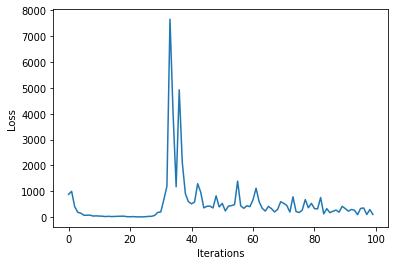

In [68]:
plt.plot(result_loss)
plt.ylabel('Loss')
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

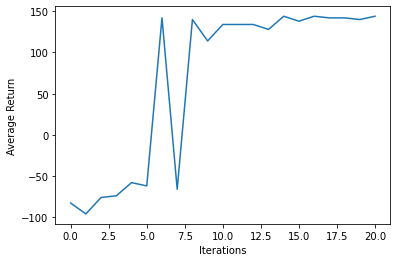

In [69]:
plt.plot(returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

## Evaluation

In [26]:
observers = []
driver = py_driver.PyDriver(
    eval_env, PyTFEagerPolicy(agent.policy), observers, max_steps=1000, max_episodes=10)

In [27]:
time_spec_init = eval_env.reset()
driver.run(time_spec_init)

[0 0 0 0 0 0 0 0 0 0] 0 <class 'numpy.ndarray'> <class 'numpy.ndarray'> 0 0 1
[1 0 0 0 0 0 0 0 0 0] 1
[1 0 0 0 0 0 0 0 0 0] 27 <class 'numpy.ndarray'> <class 'numpy.ndarray'> 9 0 1
[1 0 0 0 0 0 0 0 0 1] 1
[1 0 0 0 0 0 0 0 0 1] 6 <class 'numpy.ndarray'> <class 'numpy.ndarray'> 2 0 1
[1 0 1 0 0 0 0 0 0 1] 1
[1 0 1 0 0 0 0 0 0 1] 24 <class 'numpy.ndarray'> <class 'numpy.ndarray'> 8 0 1
[1 0 1 0 0 0 0 0 1 1] 1
[1 0 1 0 0 0 0 0 1 1] 3 <class 'numpy.ndarray'> <class 'numpy.ndarray'> 1 0 1
[1 1 1 0 0 0 0 0 1 1] 1
[1 1 1 0 0 0 0 0 1 1] 19 <class 'numpy.ndarray'> <class 'numpy.ndarray'> 6 0 2
[1 1 1 0 0 0 2 0 1 1] 1
[1 1 1 0 0 0 2 0 1 1] 9 <class 'numpy.ndarray'> <class 'numpy.ndarray'> 3 0 1
[1 1 1 1 0 0 2 0 1 1] 1
[1 1 1 1 0 0 2 0 1 1] 12 <class 'numpy.ndarray'> <class 'numpy.ndarray'> 4 0 1
[1 1 1 1 1 0 2 0 1 1] 1
[1 1 1 1 1 0 2 0 1 1] 21 <class 'numpy.ndarray'> <class 'numpy.ndarray'> 7 0 1
[1 1 1 1 1 0 2 1 1 1] 1
[1 1 1 1 1 0 2 1 1 1] 19 <class 'numpy.ndarray'> <class 'numpy.ndarray'> 6 0 

(TimeStep(
 {'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
  'observation': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>,
  'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>}),
 ())